In [523]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [525]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [526]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [7]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

# Walk Forward Analysis

In [14]:
import itertools
import time
import numpy as np
import pandas as pd

# ---------- Small helpers ----------
def zscore_in_fold(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m, sd = s.mean(), s.std(ddof=0)
    if np.isfinite(sd) and sd > 0:
        return (s - m) / sd
    return pd.Series(0.0, index=s.index)

def composite_is_score(df_block: pd.DataFrame) -> pd.Series:
    # expects columns: annualized_sharpe_ratio, max_drawdown, trade_count
    z_turn = zscore_in_fold(df_block["trade_count"].fillna(df_block["trade_count"].median()))
    z_mdd  = zscore_in_fold(df_block["max_drawdown"].abs().fillna(df_block["max_drawdown"].abs().median()))
    score  = pd.to_numeric(df_block["annualized_sharpe_ratio"], errors="coerce") \
             - 0.25*z_turn - 0.15*z_mdd
    return score

def make_grid(fixed_params: dict, sweep_params: dict):
    """Yield parameter dicts: fixed merged with each sweep point."""
    keys, values = zip(*sweep_params.items()) if sweep_params else ([], [])
    for prod in (itertools.product(*values) if values else [()]):
        update = dict(zip(keys, prod))
        cfg = fixed_params.copy()
        cfg.update(update)
        yield cfg

def _grid_size(sweep_params: dict) -> int:
    if not sweep_params:
        return 1
    n = 1
    for v in sweep_params.values():
        n *= len(v)
    return n

def _fmt_params(p: dict) -> str:
    keys = [
        'annualized_target_volatility',
        'stop_loss_strategy',
        'atr_multiplier',
        'rolling_atr_window',
        'highest_high_window',
        'cooldown_counter_threshold',
    ]
    return ", ".join(f"{k}={p[k]}" for k in keys if k in p)

def _clean_params(p: dict) -> dict:
    """Remove fold-controlled keys so we can set them explicitly per fold."""
    drop = {"signal_start_date", "use_specific_start_date"}
    return {k: v for k, v in p.items() if k not in drop}

# ---------- Core WFA runner ----------
def run_wfa(
    start_date: str,
    end_date: str,
    ticker_list,
    *,
    is_months=18,
    os_months=3,
    step_equals_os=True,     # non-overlapping for speed
    warmup_days=300,
    min_trades_is=6,         # guardrail
    fixed_params: dict,
    sweep_params: dict,
    tf_fn,                   # your strategy function
    perf_fn,                 # your risk/perf metrics function (portfolio-level)
    include_ticker_metrics=True
):
    """
    Returns df_performance with IS and OS rows.
    Adds: is_score on IS rows; os_score (Sharpe) on OS rows; is_promoted flag on OS row.
    Uses YAML parameter names throughout.
    """
    start_ts = time.perf_counter()
    start_date = pd.Timestamp(start_date).date()
    end_date   = pd.Timestamp(end_date).date()

    IS_LEN = pd.DateOffset(months=is_months)
    OS_LEN = pd.DateOffset(months=os_months)
    STEP   = (OS_LEN if step_equals_os else pd.DateOffset(months=1))

    grid_n = _grid_size(sweep_params)
    print(f"[WFA] init: IS={is_months}m, OS={os_months}m, STEP={'OS_LEN' if step_equals_os else '1m'}, "
          f"warmup={warmup_days}d, tickers={len(ticker_list)}, grid_size={grid_n}", flush=True)

    perf_cols = [
        'sampling_category','start_date','end_date',
        'annualized_return','annualized_sharpe_ratio','calmar_ratio',
        'annualized_std_dev','max_drawdown','max_drawdown_duration',
        'hit_rate','t_statistic','p_value','trade_count',
        # params (YAML names)
        'annualized_target_volatility','stop_loss_strategy','atr_multiplier','rolling_atr_window',
        'highest_high_window','cooldown_counter_threshold',
        # scores
        'is_score','os_score','is_promoted'
    ]
    if include_ticker_metrics:
        ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
        perf_cols += [f'{t}_{c}' for t in ticker_list for c in ticker_perf_cols]

    df_performance = pd.DataFrame(columns=perf_cols)

    fold_idx = 0
    start_is = start_date
    while True:
        end_is = (start_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_os = (end_is + pd.Timedelta(days=1))
        end_os = (start_os + OS_LEN - pd.Timedelta(days=1)).date()

        if end_os > end_date - pd.Timedelta(days=1):
            print("[WFA] done: OS end exceeds end_date; exiting loop.", flush=True)
            break

        fold_idx += 1
        print(f"\n[WFA] Fold {fold_idx}: IS {start_is} → {end_is} | OS {start_os} → {end_os} | warmup={warmup_days}d", flush=True)

        # ---- 1) Evaluate all sweep params in-sample ----
        is_rows = []
        print(f"[WFA] Fold {fold_idx}: evaluating {grid_n} config(s) in-sample…", flush=True)
        t0 = time.perf_counter()
        for j, p in enumerate(make_grid(fixed_params, sweep_params), start=1):
            p_is = _clean_params(p)
            print(f"[WFA] Fold {fold_idx} | IS cfg {j}/{grid_n}: {_fmt_params(p_is)}", flush=True)
            # 1a) In-sample run (pass fold-local signal_start_date)
            df_is = tf_fn(
                start_date=start_is - pd.Timedelta(days=warmup_days),
                end_date=end_is, ticker_list=ticker_list,
                **p_is,
                use_specific_start_date=True,
                signal_start_date=start_is,
            )
            df_is = df_is[df_is.index >= pd.Timestamp(start_is).date()]

            df_is = perf.calculate_asset_level_returns(df_is, end_is, ticker_list)

            # 1b) Portfolio metrics
            is_port = perf_fn(
                df_is,
                strategy_daily_return_col='portfolio_daily_pct_returns',
                strategy_trade_count_col='count_of_positions',
                include_transaction_costs_and_fees=False,
                passive_trade_rate=0.05, annual_trading_days=365,
                transaction_cost_est=0.001
            )
            print(f"[WFA] Fold {fold_idx} | IS cfg {j}/{grid_n} METRICS: "
                  f"Sharpe={is_port.get('annualized_sharpe_ratio',np.nan):.3f}, "
                  f"MDD={is_port.get('max_drawdown',np.nan):.3%}, "
                  f"trades={int(is_port.get('trade_count',0))}", flush=True)

            row = {
                'sampling_category':'in_sample',
                'start_date': start_is,
                'end_date': end_is,
                'is_score': np.nan, 'os_score': np.nan, 'is_promoted': False,
                **{k: p_is.get(k, np.nan) for k in [
                    'annualized_target_volatility','stop_loss_strategy','atr_multiplier',
                    'rolling_atr_window','highest_high_window','cooldown_counter_threshold'
                ]},
                **is_port
            }

            if include_ticker_metrics:
                for t in ticker_list:
                    tmet = perf.calculate_risk_and_performance_metrics(
                        df_is,
                        strategy_daily_return_col=f'{t}_daily_pct_returns',
                        strategy_trade_count_col=f'{t}_position_count',
                        annual_trading_days=365,
                        include_transaction_costs_and_fees=False
                    )
                    for c in ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']:
                        row[f'{t}_{c}'] = tmet[c]

            is_rows.append(row)

        print(f"[WFA] Fold {fold_idx}: IS grid complete in {time.perf_counter()-t0:.1f}s. Scoring…", flush=True)

        # attach IS rows and compute scores within the fold
        is_block = pd.DataFrame(is_rows)

        # guardrail: activity
        pre_n = len(is_block)
        is_block['ok'] = pd.to_numeric(is_block['trade_count'], errors='coerce').fillna(0) >= min_trades_is
        if is_block['ok'].any():
            is_block = is_block[is_block['ok']].copy()
            print(f"[WFA] Fold {fold_idx}: guardrail kept {len(is_block)}/{pre_n} configs (min_trades_is={min_trades_is}).", flush=True)
        else:
            print(f"[WFA] Fold {fold_idx}: guardrail filtered all {pre_n} configs; continuing with all (no guardrail).", flush=True)

        # IS composite score
        is_block['is_score'] = composite_is_score(is_block)

        # pick best by score (tie-breaks implicit by sort order)
        winner = is_block.sort_values(['is_score','annualized_sharpe_ratio','max_drawdown','trade_count'],
                                      ascending=[False, False, True, True]).iloc[0]

        print(f"[WFA] Fold {fold_idx}: WINNER (IS) "
              f"tv={winner.get('annualized_target_volatility')}, "
              f"stop={winner.get('stop_loss_strategy')}, "
              f"k={winner.get('atr_multiplier')}, "
              f"atr_w={winner.get('rolling_atr_window')}, "
              f"hh={winner.get('highest_high_window')}, "
              f"cd={winner.get('cooldown_counter_threshold')} | "
              f"score={winner['is_score']:.3f}, "
              f"Sharpe={winner['annualized_sharpe_ratio']:.3f}, "
              f"MDD={winner['max_drawdown']:.3%}, "
              f"trades={int(winner['trade_count'])}", flush=True)

        # append IS rows to df_performance
        df_performance = pd.concat([df_performance, is_block[perf_cols]], ignore_index=True)

        # ---- 2) Run the promoted config out-of-sample ----
        promoted_params = {
            'annualized_target_volatility': winner.get('annualized_target_volatility', fixed_params.get('annualized_target_volatility')),
            'stop_loss_strategy':           winner.get('stop_loss_strategy', fixed_params.get('stop_loss_strategy')),
            'rolling_atr_window':           winner.get('rolling_atr_window', fixed_params.get('rolling_atr_window')),
            'atr_multiplier':               winner.get('atr_multiplier', fixed_params.get('atr_multiplier')),
            'highest_high_window':          winner.get('highest_high_window', fixed_params.get('highest_high_window')),
            'cooldown_counter_threshold':   winner.get('cooldown_counter_threshold', fixed_params.get('cooldown_counter_threshold')),
        }
        p_os = fixed_params.copy()
        p_os.update(promoted_params)
        p_os = _clean_params(p_os)

        print(f"[WFA] Fold {fold_idx}: running OS with promoted params: {_fmt_params(p_os)}", flush=True)
        t1 = time.perf_counter()

        df_os = tf_fn(
            start_date=start_os - pd.Timedelta(days=warmup_days),
            end_date=end_os, ticker_list=ticker_list,
            **p_os,
            use_specific_start_date=True,
            signal_start_date=start_os,
        )
        df_os = df_os[df_os.index >= pd.Timestamp(start_os).date()]
        df_os = perf.calculate_asset_level_returns(df_os, end_os, ticker_list)

        os_port = perf_fn(
            df_os,
            strategy_daily_return_col='portfolio_daily_pct_returns',
            strategy_trade_count_col='count_of_positions',
            include_transaction_costs_and_fees=False,
            passive_trade_rate=0.05, annual_trading_days=365,
            transaction_cost_est=0.001
        )

        print(f"[WFA] Fold {fold_idx}: OS METRICS: Sharpe={os_port.get('annualized_sharpe_ratio',np.nan):.3f}, "
              f"MDD={os_port.get('max_drawdown',np.nan):.3%}, "
              f"trades={int(os_port.get('trade_count',0))} "
              f"(elapsed {time.perf_counter()-t1:.1f}s)", flush=True)

        os_row = {
            'sampling_category':'out_sample',
            'start_date': start_os,
            'end_date': end_os,
            'is_score': float(winner['is_score']),
            'os_score': float(os_port['annualized_sharpe_ratio']),  # OS score = OS Sharpe
            'is_promoted': True,
            **{k: p_os.get(k, np.nan) for k in [
                'annualized_target_volatility','stop_loss_strategy','atr_multiplier',
                'rolling_atr_window','highest_high_window','cooldown_counter_threshold'
            ]},
            **os_port
        }
        if include_ticker_metrics:
            for t in ticker_list:
                tmet = perf.calculate_risk_and_performance_metrics(
                    df_os,
                    strategy_daily_return_col=f'{t}_daily_pct_returns',
                    strategy_trade_count_col=f'{t}_position_count',
                    annual_trading_days=365,
                    include_transaction_costs_and_fees=False
                )
                for c in ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']:
                    os_row[f'{t}_{c}'] = tmet[c]

        df_performance.loc[len(df_performance)] = os_row

        print(f"[WFA] Fold {fold_idx}: complete. Rolling forward…", flush=True)
        # ---- roll forward ----
        start_is = (start_is + (OS_LEN if step_equals_os else pd.DateOffset(months=1))).date()

    print(f"\n[WFA] finished. folds={fold_idx}, total_rows={len(df_performance)} "
          f"(elapsed {time.perf_counter()-start_ts:.1f}s)", flush=True)

    return df_performance


## Target Volatility Walk Forward Analysis

In [76]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=14,
    atr_multiplier=2.25, highest_high_window=56, cooldown_counter_threshold=1,
    annualized_target_volatility=0.55,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"annualized_target_volatility":[0.40,0.50,0.55,0.60,0.70]}

df_tv = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=5

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 5 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/5 METRICS: Sharpe=0.150, MDD=-13.103%, trades=58
[WFA] Fold 1 | IS cfg 2/5: annualized_target_volatility=0.5, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getti

In [87]:
df_tv

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.062030   
1          in_sample  2022-04-01  2023-09-30           0.082740   
2          in_sample  2022-04-01  2023-09-30           0.089059   
3          in_sample  2022-04-01  2023-09-30           0.098075   
4          in_sample  2022-04-01  2023-09-30           0.107947   
5         out_sample  2023-10-01  2023-12-31           8.559929   
6          in_sample  2022-07-01  2023-12-31           0.515139   
7          in_sample  2022-07-01  2023-12-31           0.614936   
8          in_sample  2022-07-01  2023-12-31           0.671074   
9          in_sample  2022-07-01  2023-12-31           0.711719   
10         in_sample  2022-07-01  2023-12-31           0.772215   
11        out_sample  2024-01-01  2024-03-31           1.008826   
12         in_sample  2022-10-01  2024-03-31           0.781959   
13         in_sample  2022-10-01  2024-03-31           0.889273   
14         in_sample  2022-10-01  2024-03-31           0.917257   
15         in_sample  2022-10-01  2024-03-31           0.930736   
16         in_sample  2022-10-01  2024-03-31           0.970608   
17        out_sample  2024-04-01  2024-06-30          -0.243350   
18         in_sample  2023-01-01  2024-06-30           0.723441   
19         in_sample  2023-01-01  2024-06-30           0.829712   
20         in_sample  2023-01-01  2024-06-30           0.854437   
21         in_sample  2023-01-01  2024-06-30           0.878742   
22         in_sample  2023-01-01  2024-06-30           0.939973   
23        out_sample  2024-07-01  2024-09-30           0.085207   
24         in_sample  2023-04-01  2024-09-30           0.504187   
25         in_sample  2023-04-01  2024-09-30           0.549795   
26         in_sample  2023-04-01  2024-09-30           0.580529   
27         in_sample  2023-04-01  2024-09-30           0.587729   
28         in_sample  2023-04-01  2024-09-30           0.604524   
29        out_sample  2024-10-01  2024-12-31           0.227801   
30         in_sample  2023-07-01  2024-12-31           0.547631   
31         in_sample  2023-07-01  2024-12-31           0.613093   
32         in_sample  2023-07-01  2024-12-31           0.682924   
33         in_sample  2023-07-01  2024-12-31           0.671616   
34         in_sample  2023-07-01  2024-12-31           0.680846   
35        out_sample  2025-01-01  2025-03-31          -0.404289   
36         in_sample  2023-10-01  2025-03-31           0.458461   
37         in_sample  2023-10-01  2025-03-31           0.484041   
38         in_sample  2023-10-01  2025-03-31           0.531333   
39         in_sample  2023-10-01  2025-03-31           0.517713   
40         in_sample  2023-10-01  2025-03-31           0.520803   
41        out_sample  2025-04-01  2025-06-30          -0.267912   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.150180      0.473397            0.386539     -0.131031   
1                  0.251422      0.608804            0.485030     -0.135905   
2                  0.273599      0.613952            0.583024     -0.145059   
3                  0.307117      0.651815            0.623411     -0.150465   
4                  0.337019      0.655483            0.660664     -0.164682   
5                  5.051270    123.856993            0.633967     -0.069111   
6                  1.761367      5.204459            0.428444     -0.098980   
7                  1.684665      4.618796            0.560074     -0.133138   
8                  1.734672      4.973026            0.588984     -0.134943   
9                  1.748907      4.943141            0.629301     -0.143981   
10                 1.774788      4.825491            0.673003     -0.160028   
11                 2.420412      6.985011            0.424984     -0.144427   
12                 2.218749      5.419537            0.480361     -0.144285   
13             

In [89]:
df_tv['vol_tracking_error'] = (np.abs(df_tv['annualized_std_dev'] - df_tv['annualized_target_volatility']) / df_tv['annualized_target_volatility'])

in_sample_cond = (df_tv.sampling_category == 'in_sample')
df_tv_is = df_tv[in_sample_cond].reset_index(drop=True)
df_tv_os = df_tv[~in_sample_cond].reset_index(drop=True)

In [91]:
df_tv.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Target_Volatility_Performance-2022-04-01-2025-10-01.pickle')

In [40]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'vol_tracking_error':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}

In [97]:
df_tv_is.groupby(['annualized_target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                              median      mean       std   
annualized_target_volatility                                               
0.40                                        1.761367  1.609636  0.686733   
0.55                                        1.734672  1.531630  0.587578   
0.50                                        1.684665  1.522892  0.601438   
0.60                                        1.674058  1.510240  0.570507   
0.70                                        1.631542  1.502700  0.559738   

                             annualized_return                      \
                                        median      mean       std   
annualized_target_volatility                                         
0.40                                  0.515139  0.513264  0.232470   
0.55                                  0.671074  0.618087  0.271165   
0.50                                  0.613093  0.580513  0.263852   
0.60                                  0.671616  0.628047  0.276296   
0.70                                  0.680846  0.656702  0.292981   

                             max_drawdown                      \
                                   median      mean       std   
annualized_target_volatility                                    
0.40                            -0.175480 -0.169407  0.049690   
0.55                            -0.227879 -0.212002  0.058041   
0.50                            -0.213488 -0.200800  0.055260   
0.60                            -0.237117 -0.221300  0.059913   
0.70                            -0.242743 -0.233133  0.059493   

                             annualized_std_dev                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.40                                   0.428444  0.433328  0.029262   
0.55                                   0.583024  0.564907  0.032707   
0.50                                   0.493990  0.519426  0.037084   
0.60                                   0.612973  0.587195  0.042597   
0.70                                   0.636773  0.604931  0.066728   

                             vol_tracking_error                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.40                                   0.071111  0.092936  0.058090   
0.55                                   0.060043  0.056659  0.025459   
0.50                                   0.029939  0.061661  0.053161   
0.60                                   0.048835  0.061054  0.034970   
0.70                                   0.090325  0.135813  0.095326   

                             trade_count                         \
                                  median        mean        std   
annualized_target_volatility                                      
0.40                               104.0   97.428571  20.525246   
0.55                               122.0  113.428571  27.748016   
0.50                               116.0  108.857143  25.281275   
0.60                               128.0  117.571429  28.970428   
0.70                               132.0  121.714286  28.848537   

                             BTC-USD_annualized_sharpe_ratio            \
                                                      median      mean   
annualized_target_volatility                                             
0.40                                               -0.155371  0.059218   
0.55                                               -0.039606  0.096297   
0.50                                               -0.081462  0.074563   
0.60                                               -0.035473  0.055127   
0.70                                                0.047208  0.097584   

                                       ETH-USD_annualized_sharpe_ratio

In [99]:
df_tv_os.groupby(['annualized_target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                     \
                                              median      mean      std   
annualized_target_volatility                                              
0.5                                         5.051270  5.051270      NaN   
0.4                                        -0.836667 -1.175719  2.86716   

                             annualized_return                      \
                                        median      mean       std   
annualized_target_volatility                                         
0.5                                   8.559929  8.559929       NaN   
0.4                                  -0.079071  0.067714  0.518424   

                             max_drawdown                      \
                                   median      mean       std   
annualized_target_volatility                                    
0.5                             -0.069111 -0.069111       NaN   
0.4                             -0.095452 -0.091789  0.043373   

                             annualized_std_dev                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.5                                    0.633967  0.633967       NaN   
0.4                                    0.300797  0.301143  0.117193   

                             vol_tracking_error                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.5                                    0.267934  0.267934       NaN   
0.4                                    0.248007  0.291520  0.239067   

                             trade_count                        \
                                  median       mean        std   
annualized_target_volatility                                     
0.5                                 47.0  47.000000        NaN   
0.4                                 16.0  16.666667  10.033278   

                             BTC-USD_annualized_sharpe_ratio               \
                                                      median     mean std   
annualized_target_volatility                                                
0.5                                                  0.80546  0.80546 NaN   
0.4                                                 -1.81793     -inf NaN   

                             ETH-USD_annualized_sharpe_ratio                \
                                                      median      mean std   
annualized_target_volatility                                                 
0.5                                                -0.919299 -0.919299 NaN   
0.4                                                     -inf      -inf NaN   

                             SOL-USD_annualized_sharpe_ratio                \
                                                      median      mean std   
annualized_target_volatility                                                 
0.5                                                 1.392554  1.392554 NaN   
0.4                                                     -inf      -inf NaN   

                             ADA-USD_annualized_sharpe_ratio                \
                                                      median      mean std   
annualized_target_volatility                                                 
0.5                                                 5.401248  5.401248 NaN   
0.4                                                     -inf      -inf NaN   

                             AVAX-USD_annualized_sharpe_ratio               
                                                       median     mean std  
annualized_target_volatility                                                
0.5                                                   4.25525  4.25525 NaN  
0.4                                                      -inf     

In [101]:
df_tv_os

sampling_category  start_date    end_date  annualized_return  \
0        out_sample  2023-10-01  2023-12-31           8.559929   
1        out_sample  2024-01-01  2024-03-31           1.008826   
2        out_sample  2024-04-01  2024-06-30          -0.243350   
3        out_sample  2024-07-01  2024-09-30           0.085207   
4        out_sample  2024-10-01  2024-12-31           0.227801   
5        out_sample  2025-01-01  2025-03-31          -0.404289   
6        out_sample  2025-04-01  2025-06-30          -0.267912   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 5.051270    123.856993            0.633967     -0.069111   
1                 2.420412      6.985011            0.424984     -0.144427   
2                -3.485933     -3.300537            0.136353     -0.073730   
3                 0.373578      3.914356            0.428271     -0.021768   
4                 0.821012      2.909473            0.337605     -0.078296   
5                -5.136470     -3.371731            0.215660     -0.119905   
6                -2.046912     -2.379160            0.263989     -0.112608   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               22 days  0.500000     2.589370  0.011195         47.0   
1               37 days  0.373626     1.294133  0.198931         23.0   
2               90 days  0.054945    -1.477854  0.142938          9.0   
3               85 days  0.043478     0.427849  0.669772          4.0   
4               38 days  0.304348     0.523965  0.601577         32.0   
5               89 days  0.066667    -2.328531  0.022150         14.0   
6               47 days  0.263736    -0.878075  0.382241         18.0   

   annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.5         Chandelier            2.25   
1                           0.4         Chandelier            2.25   
2                           0.4         Chandelier            2.25   
3                           0.4         Chandelier            2.25   
4                           0.4         Chandelier            2.25   
5                           0.4         Chandelier            2.25   
6                           0.4         Chandelier            2.25   

  rolling_atr_window highest_high_window cooldown_counter_threshold  is_score  \
0                 14                  56                          1  0.574715   
1                 14                  56                          1  2.488981   
2                 14                  56                          1  2.899567   
3                 14                  56                          1  2.781900   
4                 14                  56                          1  2.466243   
5                 14                  56                          1  2.506616   
6                 14                  56                          1  2.175352   

   os_score is_promoted  BTC-USD_annualized_return  \
0  5.051270        True                   0.197930   
1  2.420412        True                   0.083092   
2 -3.485933        True                  -0.214787   
3  0.373578        True                   0.000000   
4  0.821012        True                   0.470239   
5 -5.136470        True                  -0.333097   
6 -2.046912        True                  -0.035857   

   BTC-USD_annualized_sharpe_ratio  BTC-USD_annualized_std_dev  \
0                         0.805460                    0.261972   
1                         0.336052                    0.140872   
2                        -2.912832                    0.246354   
3                             -inf                         NaN   
4                         2.080154                    0.240368   
5                        -4.104783                    0.225123   
6                        -0.723028                    0.252532   

   BTC-USD_max_drawdown  ETH-USD_annualized_return  \
0             -0.047620              

In [103]:
df_tv_is

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.062030   
1          in_sample  2022-04-01  2023-09-30           0.082740   
2          in_sample  2022-04-01  2023-09-30           0.089059   
3          in_sample  2022-04-01  2023-09-30           0.098075   
4          in_sample  2022-04-01  2023-09-30           0.107947   
5          in_sample  2022-07-01  2023-12-31           0.515139   
6          in_sample  2022-07-01  2023-12-31           0.614936   
7          in_sample  2022-07-01  2023-12-31           0.671074   
8          in_sample  2022-07-01  2023-12-31           0.711719   
9          in_sample  2022-07-01  2023-12-31           0.772215   
10         in_sample  2022-10-01  2024-03-31           0.781959   
11         in_sample  2022-10-01  2024-03-31           0.889273   
12         in_sample  2022-10-01  2024-03-31           0.917257   
13         in_sample  2022-10-01  2024-03-31           0.930736   
14         in_sample  2022-10-01  2024-03-31           0.970608   
15         in_sample  2023-01-01  2024-06-30           0.723441   
16         in_sample  2023-01-01  2024-06-30           0.829712   
17         in_sample  2023-01-01  2024-06-30           0.854437   
18         in_sample  2023-01-01  2024-06-30           0.878742   
19         in_sample  2023-01-01  2024-06-30           0.939973   
20         in_sample  2023-04-01  2024-09-30           0.504187   
21         in_sample  2023-04-01  2024-09-30           0.549795   
22         in_sample  2023-04-01  2024-09-30           0.580529   
23         in_sample  2023-04-01  2024-09-30           0.587729   
24         in_sample  2023-04-01  2024-09-30           0.604524   
25         in_sample  2023-07-01  2024-12-31           0.547631   
26         in_sample  2023-07-01  2024-12-31           0.613093   
27         in_sample  2023-07-01  2024-12-31           0.682924   
28         in_sample  2023-07-01  2024-12-31           0.671616   
29         in_sample  2023-07-01  2024-12-31           0.680846   
30         in_sample  2023-10-01  2025-03-31           0.458461   
31         in_sample  2023-10-01  2025-03-31           0.484041   
32         in_sample  2023-10-01  2025-03-31           0.531333   
33         in_sample  2023-10-01  2025-03-31           0.517713   
34         in_sample  2023-10-01  2025-03-31           0.520803   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.150180      0.473397            0.386539     -0.131031   
1                  0.251422      0.608804            0.485030     -0.135905   
2                  0.273599      0.613952            0.583024     -0.145059   
3                  0.307117      0.651815            0.623411     -0.150465   
4                  0.337019      0.655483            0.660664     -0.164682   
5                  1.761367      5.204459            0.428444     -0.098980   
6                  1.684665      4.618796            0.560074     -0.133138   
7                  1.734672      4.973026            0.588984     -0.134943   
8                  1.748907      4.943141            0.629301     -0.143981   
9                  1.774788      4.825491            0.673003     -0.160028   
10                 2.218749      5.419537            0.480361     -0.144285   
11                 2.049795      5.056792            0.566170     -0.175857   
12                 2.011750      4.824768            0.602522     -0.190114   
13                 2.003979      4.694758            0.617710     -0.198250   
14                 1.981659      4.662514            0.636773     -0.208173   
15                 2.092921      4.122642            0.457172     -0.175480   
16                 1.947507      3.886449            0.549652     -0.213488   
17                 1.910440      3.749524            0.586714     -0.227879   
18                 1.879845      3.705951            0.612973     -0.237117   
19        

## Cooldown Counter Threshold

In [241]:
import itertools
import time
import numpy as np
import pandas as pd

# ---------- Small helpers ----------
def zscore_in_fold(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m, sd = s.mean(), s.std(ddof=0)
    if np.isfinite(sd) and sd > 0:
        return (s - m) / sd
    return pd.Series(0.0, index=s.index)

def composite_is_score(df_block: pd.DataFrame) -> pd.Series:
    # expects columns: annualized_sharpe_ratio, max_drawdown, trade_count
    z_turn = zscore_in_fold(df_block["trade_count"].fillna(df_block["trade_count"].median()))
    z_mdd  = zscore_in_fold(df_block["max_drawdown"].abs().fillna(df_block["max_drawdown"].abs().median()))
    score  = pd.to_numeric(df_block["annualized_sharpe_ratio"], errors="coerce") \
             - 0.25*z_turn - 0.15*z_mdd
    return score

def make_grid(fixed_params: dict, sweep_params: dict):
    """Yield parameter dicts: fixed merged with each sweep point."""
    keys, values = zip(*sweep_params.items()) if sweep_params else ([], [])
    for prod in (itertools.product(*values) if values else [()]):
        update = dict(zip(keys, prod))
        cfg = fixed_params.copy()
        cfg.update(update)
        return_cfg = cfg.copy()
        yield return_cfg

def _grid_size(sweep_params: dict) -> int:
    if not sweep_params:
        return 1
    n = 1
    for v in sweep_params.values():
        n *= len(v)
    return n

def _clean_params(p: dict) -> dict:
    """Remove fold-controlled keys so we can set them explicitly per fold."""
    drop = {"signal_start_date", "use_specific_start_date"}
    return {k: v for k, v in p.items() if k not in drop}

def _param_keys(sweep_params: dict) -> list:
    """
    Base YAML-named knobs we always want recorded + any swept keys (e.g., weighted_signal_ewm_window).
    Dedup while preserving order.
    """
    base = [
        'annualized_target_volatility',
        'stop_loss_strategy',
        'atr_multiplier',
        'rolling_atr_window',
        'highest_high_window',
        'cooldown_counter_threshold',
    ]
    extra = list(sweep_params.keys()) if sweep_params else []
    seen, out = set(), []
    for k in base + extra:
        if k not in seen:
            seen.add(k); out.append(k)
    return out

def _fmt_params(p: dict, keys: list) -> str:
    return ", ".join(f"{k}={p.get(k)}" for k in keys if k in p)

# ---------- Core WFA runner ----------
def run_wfa(
    start_date: str,
    end_date: str,
    ticker_list,
    *,
    is_months=18,
    os_months=3,
    step_equals_os=True,     # non-overlapping for speed
    warmup_days=300,
    min_trades_is=6,         # guardrail
    fixed_params: dict,
    sweep_params: dict,
    tf_fn,                   # your strategy function
    perf_fn,                 # your risk/perf metrics function (portfolio-level)
    include_ticker_metrics=True,
    promote_top_k: int = 1   # promote top-k IS winners per fold into OS
):
    """
    Returns df_performance with IS and OS rows.
    Adds: is_score on IS rows; os_score (Sharpe) on OS rows; is_promoted flag on OS rows.
    Uses YAML parameter names throughout. Dynamically records any swept keys.
    """
    start_ts = time.perf_counter()
    start_date = pd.Timestamp(start_date).date()
    end_date   = pd.Timestamp(end_date).date()

    IS_LEN = pd.DateOffset(months=is_months)
    OS_LEN = pd.DateOffset(months=os_months)
    STEP   = (OS_LEN if step_equals_os else pd.DateOffset(months=1))

    grid_n = _grid_size(sweep_params)
    param_keys = _param_keys(sweep_params)  # <-- include swept keys like weighted_signal_ewm_window
    print(f"[WFA] init: IS={is_months}m, OS={os_months}m, STEP={'OS_LEN' if step_equals_os else '1m'}, "
          f"warmup={warmup_days}d, tickers={len(ticker_list)}, grid_size={grid_n}, promote_top_k={promote_top_k}", flush=True)
    print(f"[WFA] params tracked: {param_keys}", flush=True)

    perf_cols = [
        'sampling_category','start_date','end_date',
        'annualized_return','annualized_sharpe_ratio','calmar_ratio',
        'annualized_std_dev','max_drawdown','max_drawdown_duration',
        'hit_rate','t_statistic','p_value','trade_count',
        # dynamically tracked params
        *param_keys,
        # scores
        'is_score','os_score','is_promoted',
        # promotion metadata
        'promotion_rank','promotion_set_id'
    ]
    if include_ticker_metrics:
        ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
        perf_cols += [f'{t}_{c}' for t in ticker_list for c in ticker_perf_cols]

    df_performance = pd.DataFrame(columns=perf_cols)

    fold_idx = 0
    start_is = start_date
    while True:
        end_is = (start_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_os = (end_is + pd.Timedelta(days=1))
        end_os = (start_os + OS_LEN - pd.Timedelta(days=1)).date()

        if end_os > end_date - pd.Timedelta(days=1):
            print("[WFA] done: OS end exceeds end_date; exiting loop.", flush=True)
            break

        fold_idx += 1
        print(f"\n[WFA] Fold {fold_idx}: IS {start_is} → {end_is} | OS {start_os} → {end_os} | warmup={warmup_days}d", flush=True)

        # ---- 1) Evaluate all sweep params in-sample ----
        is_rows = []
        print(f"[WFA] Fold {fold_idx}: evaluating {grid_n} config(s) in-sample…", flush=True)
        t0 = time.perf_counter()
        for j, p in enumerate(make_grid(fixed_params, sweep_params), start=1):
            p_is = _clean_params(p)
            print(f"[WFA] Fold {fold_idx} | IS cfg {j}/{grid_n}: {_fmt_params(p_is, param_keys)}", flush=True)

            # 1a) In-sample run (pass fold-local signal_start_date)
            df_is = tf_fn(
                start_date=start_is - pd.Timedelta(days=warmup_days),
                end_date=end_is, ticker_list=ticker_list,
                **p_is,                                # <-- swept key (e.g., weighted_signal_ewm_window) is passed through
                use_specific_start_date=True,
                signal_start_date=start_is,
            )
            df_is = df_is[df_is.index >= pd.Timestamp(start_is).date()]

            df_is = perf.calculate_asset_level_returns(df_is, end_is, ticker_list)

            # 1b) Portfolio metrics
            is_port = perf_fn(
                df_is,
                strategy_daily_return_col='portfolio_daily_pct_returns',
                strategy_trade_count_col='count_of_positions',
                include_transaction_costs_and_fees=False,
                passive_trade_rate=0.05, annual_trading_days=365,
                transaction_cost_est=0.001
            )
            print(f"[WFA] Fold {fold_idx} | IS cfg {j}/{grid_n} METRICS: "
                  f"Sharpe={is_port.get('annualized_sharpe_ratio',np.nan):.3f}, "
                  f"MDD={is_port.get('max_drawdown',np.nan):.3%}, "
                  f"trades={int(is_port.get('trade_count',0))}", flush=True)

            row = {
                'sampling_category':'in_sample',
                'start_date': start_is,
                'end_date': end_is,
                'is_score': np.nan, 'os_score': np.nan, 'is_promoted': False,
                'promotion_rank': np.nan, 'promotion_set_id': None,
                **{k: p_is.get(k, np.nan) for k in param_keys},  # <-- record swept key(s) too
                **is_port
            }

            if include_ticker_metrics:
                for t in ticker_list:
                    tmet = perf.calculate_risk_and_performance_metrics(
                        df_is,
                        strategy_daily_return_col=f'{t}_daily_pct_returns',
                        strategy_trade_count_col=f'{t}_position_count',
                        annual_trading_days=365,
                        include_transaction_costs_and_fees=False
                    )
                    for c in ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']:
                        row[f'{t}_{c}'] = tmet[c]

            is_rows.append(row)

        print(f"[WFA] Fold {fold_idx}: IS grid complete in {time.perf_counter()-t0:.1f}s. Scoring…", flush=True)

        # attach IS rows and compute scores within the fold
        is_block = pd.DataFrame(is_rows)

        # guardrail: activity
        pre_n = len(is_block)
        is_block['ok'] = pd.to_numeric(is_block['trade_count'], errors='coerce').fillna(0) >= min_trades_is
        if is_block['ok'].any():
            is_block = is_block[is_block['ok']].copy()
            print(f"[WFA] Fold {fold_idx}: guardrail kept {len(is_block)}/{pre_n} configs (min_trades_is={min_trades_is}).", flush=True)
        else:
            print(f"[WFA] Fold {fold_idx}: guardrail filtered all {pre_n} configs; continuing with all (no guardrail).", flush=True)

        # IS composite score
        is_block['is_score'] = composite_is_score(is_block)

        # pick top-k by score (tie-breakers implicit)
        winners_block = is_block.sort_values(
            ['is_score','annualized_sharpe_ratio','max_drawdown','trade_count'],
            ascending=[False, False, True, True]
        ).head(max(1, int(promote_top_k))).copy()

        # annotate a promotion set id for this fold
        promotion_set_id = f"fold{fold_idx}_{start_os}"
        winners_block['promotion_rank'] = range(1, len(winners_block) + 1)
        winners_block['promotion_set_id'] = promotion_set_id

        # append IS rows to df_performance (for traceability)
        df_performance = pd.concat([df_performance, is_block[perf_cols]], ignore_index=True)

        print(f"[WFA] Fold {fold_idx}: promoting top-{len(winners_block)} to OS…", flush=True)
        for _, winner in winners_block.iterrows():
            print(f"[WFA] Fold {fold_idx}: WINNER rank {int(winner['promotion_rank'])} "
                  f"{_fmt_params(winner, param_keys)} | "
                  f"IS score={winner['is_score']:.3f}, "
                  f"IS Sharpe={winner['annualized_sharpe_ratio']:.3f}, "
                  f"IS MDD={winner['max_drawdown']:.3%}, "
                  f"IS trades={int(winner['trade_count'])}", flush=True)

            # ---- 2) Run this promoted config out-of-sample ----
            promoted_params = {k: winner.get(k, fixed_params.get(k)) for k in param_keys}  # <-- include swept key(s)
            p_os = fixed_params.copy()
            p_os.update(promoted_params)
            p_os = _clean_params(p_os)

            print(f"[WFA] Fold {fold_idx}: OS run (rank {int(winner['promotion_rank'])}) with params: {_fmt_params(p_os, param_keys)}", flush=True)
            t1 = time.perf_counter()

            df_os = tf_fn(
                start_date=start_os - pd.Timedelta(days=warmup_days),
                end_date=end_os, ticker_list=ticker_list,
                **p_os,                               # <-- swept key passed to tf_fn
                use_specific_start_date=True,
                signal_start_date=start_os,
            )
            df_os = df_os[df_os.index >= pd.Timestamp(start_os).date()]
            df_os = perf.calculate_asset_level_returns(df_os, end_os, ticker_list)

            os_port = perf_fn(
                df_os,
                strategy_daily_return_col='portfolio_daily_pct_returns',
                strategy_trade_count_col='count_of_positions',
                include_transaction_costs_and_fees=False,
                passive_trade_rate=0.05, annual_trading_days=365,
                transaction_cost_est=0.001
            )

            print(f"[WFA] Fold {fold_idx}: OS METRICS (rank {int(winner['promotion_rank'])}): "
                  f"Sharpe={os_port.get('annualized_sharpe_ratio',np.nan):.3f}, "
                  f"MDD={os_port.get('max_drawdown',np.nan):.3%}, "
                  f"trades={int(os_port.get('trade_count',0))} "
                  f"(elapsed {time.perf_counter()-t1:.1f}s)", flush=True)

            os_row = {
                'sampling_category':'out_sample',
                'start_date': start_os,
                'end_date': end_os,
                'is_score': float(winner['is_score']),
                'os_score': float(os_port['annualized_sharpe_ratio']),  # OS score = OS Sharpe
                'is_promoted': True,
                'promotion_rank': int(winner['promotion_rank']),
                'promotion_set_id': promotion_set_id,
                **{k: p_os.get(k, np.nan) for k in param_keys},  # <-- record swept key(s)
                **os_port
            }
            if include_ticker_metrics:
                for t in ticker_list:
                    tmet = perf.calculate_risk_and_performance_metrics(
                        df_os,
                        strategy_daily_return_col=f'{t}_daily_pct_returns',
                        strategy_trade_count_col=f'{t}_position_count',
                        annual_trading_days=365,
                        include_transaction_costs_and_fees=False
                    )
                    for c in ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']:
                        os_row[f'{t}_{c}'] = tmet[c]

            df_performance.loc[len(df_performance)] = os_row

        print(f"[WFA] Fold {fold_idx}: complete. Rolling forward…", flush=True)
        # ---- roll forward ----
        start_is = (start_is + (OS_LEN if step_equals_os else pd.DateOffset(months=1))).date()

    print(f"\n[WFA] finished. folds={fold_idx}, total_rows={len(df_performance)} "
          f"(elapsed {time.perf_counter()-start_ts:.1f}s)", flush=True)

    return df_performance


In [58]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=14,
    atr_multiplier=2.25, highest_high_window=56, cooldown_counter_threshold=1,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"cooldown_counter_threshold": [0, 1, 2, 3, 5]}

df_cooldown = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=5, promote_top_k=1

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 5 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/5 METRICS: Sharpe=0.150, MDD=-13.103%, trades=58
[WFA] Fold 1 | IS cfg 2/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Tre

In [36]:
df_cooldown['vol_tracking_error'] = (np.abs(df_cooldown['annualized_std_dev'] - df_cooldown['annualized_target_volatility']) / df_cooldown['annualized_target_volatility'])

in_sample_cond = (df_cooldown.sampling_category == 'in_sample')
df_cooldown_is = df_cooldown[in_sample_cond].reset_index(drop=True)
df_cooldown_os = df_cooldown[~in_sample_cond].reset_index(drop=True)

In [60]:
df_cooldown.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')
# df_cooldown = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [62]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'vol_tracking_error':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}

In [64]:
df_cooldown.head()

sampling_category  start_date    end_date  annualized_return  \
0         in_sample  2022-04-01  2023-09-30           0.062030   
1         in_sample  2022-04-01  2023-09-30           0.062030   
2         in_sample  2022-04-01  2023-09-30           0.070289   
3         in_sample  2022-04-01  2023-09-30           0.077987   
4         in_sample  2022-04-01  2023-09-30           0.077095   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 0.150180      0.473397            0.386539     -0.131031   
1                 0.150180      0.473397            0.386539     -0.131031   
2                 0.198539      0.600943            0.394386     -0.116965   
3                 0.243459      0.666757            0.398218     -0.116965   
4                 0.238489      0.659127            0.400616     -0.116965   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              292 days  0.100365     0.556783  0.577903         58.0   
1              292 days  0.100365     0.556783  0.577903         58.0   
2              290 days  0.098540     0.616520  0.537808         56.0   
3              290 days  0.098540     0.672333  0.501655         54.0   
4              290 days  0.096715     0.667268  0.504882         54.0   

   annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.4         Chandelier            2.25   
1                           0.4         Chandelier            2.25   
2                           0.4         Chandelier            2.25   
3                           0.4         Chandelier            2.25   
4                           0.4         Chandelier            2.25   

  rolling_atr_window highest_high_window cooldown_counter_threshold  is_score  \
0                 14                  56                          0 -0.313040   
1                 14                  56                          1 -0.313040   
2                 14                  56                          2  0.321013   
3                 14                  56                          3  0.645442   
4                 14                  56                          5  0.640472   

   os_score is_promoted promotion_rank promotion_set_id  \
0       NaN       False            NaN             None   
1       NaN       False            NaN             None   
2       NaN       False            NaN             None   
3       NaN       False            NaN             None   
4       NaN       False            NaN             None   

   BTC-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                  -0.007595                        -0.439854   
1                  -0.007595                        -0.439854   
2                  -0.010426                        -0.465312   
3                  -0.000565                        -0.379679   
4                  -0.000536                        -0.382530   

   BTC-USD_annualized_std_dev  BTC-USD_max_drawdown  \
0                    0.266515             -0.127637   
1                    0.266515             -0.127637   
2                    0.269127             -0.127637   
3                    0.270918             -0.127637   
4                    0.272094             -0.127637   

   ETH-USD_annualized_return  ETH-USD_annualized_sharpe_ratio  \
0                   0.020862                        -0.594587   
1                   0.020862                        -0.594587   
2                   0.020889                        -0.594107   
3                   0.020889                        -0.594107   
4                   0.020889                        -0.594107   

   ETH-USD_annualized_std_dev  ETH-USD_max_drawdown  \
0                    0.130958             -0.036686   
1                    0.130958             -0.036686   
2                    0.130937             -0.036686   
3                    0.130937             -0.036686   
4                    0.130937             -0.0

In [70]:
df_cooldown_is.groupby(['annualized_target_volatility','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                         median   
annualized_target_volatility cooldown_counter_threshold                           
0.4                          5                                         1.974660   
                             3                                         1.925466   
                             2                                         1.810631   
                             0                                         1.761367   
                             1                                         1.761367   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                           1.801299  0.723775   
                             3                           1.759239  0.702739   
                             2                           1.680900  0.689424   
                             0                           1.609636  0.686733   
                             1                           1.609636  0.686733   

                                                        annualized_return  \
                                                                   median   
annualized_target_volatility cooldown_counter_threshold                     
0.4                          5                                   0.571041   
                             3                                   0.562996   
                             2                                   0.523862   
                             0                                   0.515139   
                             1                                   0.515139   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                           0.574705  0.252616   
                             3                           0.564260  0.247231   
                             2                           0.537001  0.237688   
                             0                           0.513264  0.232470   
                             1                           0.513264  0.232470   

                                                        max_drawdown  \
                                                              median   
annualized_target_volatility cooldown_counter_threshold                
0.4                          5                             -0.118575   
                             3                             -0.125623   
                             2                             -0.151502   
                             0                             -0.175480   
                             1                             -0.175480   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                          -0.124728  0.026576   
                             3                          -0.133354  0.032749   
                             2                          -0.146423  0.037497   
                             0                          -0.169407  0.049690   
                             1                          -0.169407  0.049690   

                                                        annualized_std_dev  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          5                                  

In [68]:
df_cooldown_os.groupby(['annualized_target_volatility','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                         median   
annualized_target_volatility cooldown_counter_threshold                           
0.4                          3                                         5.219693   
                             5                                        -0.333129   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           5.219693       NaN   
                             5                          -0.888401  3.068434   

                                                        annualized_return  \
                                                                   median   
annualized_target_volatility cooldown_counter_threshold                     
0.4                          3                                   6.512045   
                             5                                  -0.018583   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           6.512045       NaN   
                             5                           0.178954  0.614757   

                                                        max_drawdown  \
                                                              median   
annualized_target_volatility cooldown_counter_threshold                
0.4                          3                             -0.061202   
                             5                             -0.076421   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                          -0.061202       NaN   
                             5                          -0.069327  0.028143   

                                                        annualized_std_dev  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          3                                    0.538290   
                             5                                    0.335879   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           0.538290       NaN   
                             5                           0.303254  0.141983   

                                                        vol_tracking_error  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          3                                    0.345725   
                             5                                    0.184904   

                                                                           \
                                                             mean     std   
annualized_target_volatility cooldown_counter_threshold                     
0.4                          3                           0.345725     NaN   
                             5                           0.310520  0.2837   

                                                        trade_count        \
                                                             med

### Coodown Walk Forward Promoting Top 2 Winners to Out of Sample

In [22]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=14,
    atr_multiplier=2.25, highest_high_window=56, cooldown_counter_threshold=1,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"cooldown_counter_threshold": [0, 1, 2, 3, 5]}

df_cooldown_top_2 = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=5, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 5 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/5 METRICS: Sharpe=0.150, MDD=-13.103%, trades=58
[WFA] Fold 1 | IS cfg 2/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=2.25, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Tre

In [78]:
df_cooldown_top_2['vol_tracking_error'] = (np.abs(df_cooldown_top_2['annualized_std_dev'] - df_cooldown_top_2['annualized_target_volatility']) / df_cooldown_top_2['annualized_target_volatility'])

df_cooldown_top_2 = df_cooldown_top_2.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_cooldown_top_2.sampling_category == 'in_sample')
df_cooldown_top_2_is = df_cooldown_top_2[in_sample_cond].reset_index(drop=True)
df_cooldown_top_2_os = df_cooldown_top_2[~in_sample_cond].reset_index(drop=True)

In [86]:
df_cooldown_top_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_cooldown = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [80]:
df_cooldown_top_2_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.512045   
1         out_sample  2023-10-01  2023-12-31           6.842869   
2         out_sample  2024-01-01  2024-03-31           1.376439   
3         out_sample  2024-01-01  2024-03-31           1.330826   
4         out_sample  2024-04-01  2024-06-30          -0.179848   
5         out_sample  2024-04-01  2024-06-30          -0.165647   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.211057   
9         out_sample  2024-10-01  2024-12-31           0.167628   
10        out_sample  2025-01-01  2025-03-31          -0.296759   
11        out_sample  2025-01-01  2025-03-31          -0.247584   
12        out_sample  2025-04-01  2025-06-30          -0.122373   
13        out_sample  2025-04-01  2025-06-30          -0.286121   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.219693    106.402715            0.538290     -0.061202   
1                  5.365930    111.808164            0.534997     -0.061202   
2                  3.099172     13.328122            0.454115     -0.103273   
3                  2.975636     11.609181            0.448797     -0.114636   
4                 -2.859152     -3.274038            0.145568     -0.054932   
5                 -2.547227     -3.255767            0.150959     -0.050878   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  0.771742      2.596985            0.365566     -0.081270   
9                  0.592751      2.143541            0.355193     -0.078202   
10                -5.675910     -3.569085            0.119812     -0.083147   
11                -4.351674     -3.654979            0.119593     -0.067739   
12                -1.039836     -1.709797            0.306192     -0.071572   
13                -2.211323     -2.421413            0.265167     -0.118163   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                22 days  0.489130     2.682986  0.008667         37.0   
1                22 days  0.500000     2.756856  0.007052         37.0   
2                37 days  0.362637     1.635773  0.105380         19.0   
3                37 days  0.362637     1.572387  0.119370         19.0   
4                90 days  0.032967    -1.141434  0.256717          6.0   
5                90 days  0.054945    -0.997191  0.321345          7.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                40 days  0.271739     0.501984  0.616891         26.0   
9                38 days  0.304348     0.409707  0.682984         28.0   
10               89 days  0.044444    -2.473118  0.015293         12.0   
11               89 days  0.066667    -1.841657  0.068856         12.0   
12               47 days  0.252747    -0.367164  0.714359         14.0   
13               47 days  0.241758    -0.959211  0.340022         18.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            2.25   
1                            0.4         Chandelier            2.25   
2                            0.4         Chandelier            2.25   
3                            0.4         Chandelier            2.25   
4                            0.4         Chandelier            2.25   
5                            0.4         Chandelier            2.25   
6                            0.4         Chandelier            2.25   
7                            0.4         Chandelier            2.25   
8                            0.4         Chandelier          

In [82]:
df_cooldown_top_2_is.groupby(['annualized_target_volatility','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                         median   
annualized_target_volatility cooldown_counter_threshold                           
0.4                          5                                         1.974660   
                             3                                         1.925466   
                             2                                         1.810631   
                             0                                         1.761367   
                             1                                         1.761367   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                           1.801299  0.723775   
                             3                           1.759239  0.702739   
                             2                           1.680900  0.689424   
                             0                           1.609636  0.686733   
                             1                           1.609636  0.686733   

                                                        annualized_return  \
                                                                   median   
annualized_target_volatility cooldown_counter_threshold                     
0.4                          5                                   0.571041   
                             3                                   0.562996   
                             2                                   0.523862   
                             0                                   0.515139   
                             1                                   0.515139   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                           0.574705  0.252616   
                             3                           0.564260  0.247231   
                             2                           0.537001  0.237688   
                             0                           0.513264  0.232470   
                             1                           0.513264  0.232470   

                                                        max_drawdown  \
                                                              median   
annualized_target_volatility cooldown_counter_threshold                
0.4                          5                             -0.118575   
                             3                             -0.125623   
                             2                             -0.151502   
                             0                             -0.175480   
                             1                             -0.175480   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          5                          -0.124728  0.026576   
                             3                          -0.133354  0.032749   
                             2                          -0.146423  0.037497   
                             0                          -0.169407  0.049690   
                             1                          -0.169407  0.049690   

                                                        annualized_std_dev  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          5                                  

In [84]:
df_cooldown_top_2_os.groupby(['annualized_target_volatility','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                         median   
annualized_target_volatility cooldown_counter_threshold                           
0.4                          3                                         0.373578   
                             5                                         0.373578   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           0.007348  3.339299   
                             5                           0.005075  3.665265   

                                                        annualized_return  \
                                                                   median   
annualized_target_volatility cooldown_counter_threshold                     
0.4                          3                                   0.085207   
                             5                                   0.085207   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           1.056622  2.468760   
                             5                           1.130942  2.580485   

                                                        max_drawdown  \
                                                              median   
annualized_target_volatility cooldown_counter_threshold                
0.4                          3                             -0.067739   
                             5                             -0.071572   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                          -0.073227  0.034353   
                             5                          -0.068166  0.025874   

                                                        annualized_std_dev  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          3                                    0.355193   
                             5                                    0.365566   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           0.329467  0.157224   
                             5                           0.336360  0.156433   

                                                        vol_tracking_error  \
                                                                    median   
annualized_target_volatility cooldown_counter_threshold                      
0.4                          3                                    0.337081   
                             5                                    0.234520   

                                                                             \
                                                             mean       std   
annualized_target_volatility cooldown_counter_threshold                       
0.4                          3                           0.330159  0.252190   
                             5                           0.314373  0.259182   

                                                        trade_count  \
                                                            

In [92]:
df_cooldown_top_2_os.groupby(['annualized_target_volatility','start_date','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                    median   
annualized_target_volatility start_date cooldown_counter_threshold                           
0.4                          2023-10-01 5                                         5.365930   
                                        3                                         5.219693   
                             2024-01-01 5                                         3.099172   
                                        3                                         2.975636   
                             2024-10-01 5                                         0.771742   
                                        3                                         0.592751   
                             2024-07-01 3                                         0.373578   
                                        5                                         0.373578   
                             2025-04-01 5                                        -1.039836   
                                        3                                        -2.211323   
                             2024-04-01 3                                        -2.547227   
                                        5                                        -2.859152   
                             2025-01-01 3                                        -4.351674   
                                        5                                        -5.675910   

                                                                              \
                                                                        mean   
annualized_target_volatility start_date cooldown_counter_threshold             
0.4                          2023-10-01 5                           5.365930   
                                        3                           5.219693   
                             2024-01-01 5                           3.099172   
                                        3                           2.975636   
                             2024-10-01 5                           0.771742   
                                        3                           0.592751   
                             2024-07-01 3                           0.373578   
                                        5                           0.373578   
                             2025-04-01 5                          -1.039836   
                                        3                          -2.211323   
                             2024-04-01 3                          -2.547227   
                                        5                          -2.859152   
                             2025-01-01 3                          -4.351674   
                                        5                          -5.675910   

                                                                        \
                                                                   std   
annualized_target_volatility start_date cooldown_counter_threshold       
0.4                          2023-10-01 5                          NaN   
                                        3                          NaN   
                             2024-01-01 5                          NaN   
                                        3                          NaN   
                             2024-10-01 5                          NaN   
                                        3                          NaN   
                             2024-07-01 3                          NaN   
                                        5                          NaN   
                             2025-04-01 5                          NaN   
                                        3                          NaN   
                             2024-04-01 3                          NaN   
                                        5                          NaN 

## ATR Multiplier Walk Forward Analysis
### Lockdown Cooldown Counter Threshold to 5

In [99]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=14,
    atr_multiplier=2.25, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"atr_multiplier": [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]}

df_atr_multiplier = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=7, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 7 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/7: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.5, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/7 METRICS: Sharpe=0.104, MDD=-7.944%, trades=53
[WFA] Fold 1 | IS cfg 2/7: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend

In [101]:
df_atr_multiplier['vol_tracking_error'] = (np.abs(df_atr_multiplier['annualized_std_dev'] - df_atr_multiplier['annualized_target_volatility']) / df_atr_multiplier['annualized_target_volatility'])

df_atr_multiplier = df_atr_multiplier.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_atr_multiplier.sampling_category == 'in_sample')
df_atr_multiplier_is = df_atr_multiplier[in_sample_cond].reset_index(drop=True)
df_atr_multiplier_os = df_atr_multiplier[~in_sample_cond].reset_index(drop=True)

In [103]:
df_atr_multiplier_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.642604   
1         out_sample  2023-10-01  2023-12-31           3.518351   
2         out_sample  2024-01-01  2024-03-31           1.424936   
3         out_sample  2024-01-01  2024-03-31           1.376439   
4         out_sample  2024-04-01  2024-06-30          -0.179848   
5         out_sample  2024-04-01  2024-06-30          -0.117676   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.255413   
9         out_sample  2024-10-01  2024-12-31           0.097095   
10        out_sample  2025-01-01  2025-03-31          -0.287501   
11        out_sample  2025-01-01  2025-03-31          -0.130303   
12        out_sample  2025-04-01  2025-06-30          -0.205358   
13        out_sample  2025-04-01  2025-06-30          -0.143709   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.969109     55.973267            0.511053     -0.065078   
1                  4.932626     55.904004            0.463485     -0.062936   
2                  3.328357     18.103439            0.416935     -0.078711   
3                  3.099172     13.328122            0.454115     -0.103273   
4                 -2.859152     -3.274038            0.145568     -0.054932   
5                 -3.041687     -3.829211            0.078844     -0.030731   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  0.983394      3.466754            0.386486     -0.073675   
9                  0.303157      1.191287            0.367612     -0.081505   
10                -2.745646     -3.534506            0.172110     -0.081341   
11                -4.925042     -3.850709            0.087950     -0.033839   
12                -2.430536     -2.652879            0.226630     -0.077409   
13                -1.685303     -1.970989            0.250884     -0.072912   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.434783     2.574009  0.011668         37.0   
1                25 days  0.391304     2.556589  0.012227         40.0   
2                45 days  0.307692     1.754949  0.082671         21.0   
3                37 days  0.362637     1.635773  0.105380         19.0   
4                90 days  0.032967    -1.141434  0.256717          6.0   
5                90 days  0.021978    -1.088851  0.279127          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.228261     0.615028  0.540071         26.0   
9                41 days  0.304348     0.258635  0.796501         27.0   
10               72 days  0.088889    -1.187496  0.238192         14.0   
11               89 days  0.011111    -1.809698  0.073718          4.0   
12               47 days  0.142857    -0.996206  0.321821         13.0   
13               47 days  0.186813    -0.633222  0.528195         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.50   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            2.25   
4                            0.4         Chandelier            2.25   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            3.00   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

In [105]:
df_atr_multiplier.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/ATR_Multiplier_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_atr_multiplier = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [109]:
df_atr_multiplier_is.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                        median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier                           
0.4                          5                          1.50                          1.998685   
                                                        2.25                          1.974660   
                                                        1.75                          1.966058   
                                                        3.00                          1.901079   
                                                        2.00                          1.834697   
                                                        2.50                          1.786197   
                                                        2.75                          1.669438   

                                                                                  \
                                                                            mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.50            1.670431   
                                                        2.25            1.801299   
                                                        1.75            1.675898   
                                                        3.00            1.783678   
                                                        2.00            1.474042   
                                                        2.50            1.676678   
                                                        2.75            1.579124   

                                                                                  \
                                                                             std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.50            0.736336   
                                                        2.25            0.723775   
                                                        1.75            0.679776   
                                                        3.00            0.697268   
                                                        2.00            0.742914   
                                                        2.50            0.708883   
                                                        2.75            0.741117   

                                                                       annualized_return  \
                                                                                  median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier                     
0.4                          5                          1.50                    0.522750   
                                                        2.25                    0.571041   
                                                        1.75                    0.487643   
                                                        3.00                    0.626226   
                                                        2.00                    0.486541   
                                                        2.50                    0.555327   
                                                        2.75                    0.538866   

                                                                                  \
                                                                            mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.50            0.422198   
                                                        2.25            0.574705   
                                                        1.75       

In [111]:
df_atr_multiplier_os.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                        median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier                           
0.4                          5                          1.75                          0.678486   
                                                        3.00                          0.303157   
                                                        2.25                          0.120010   
                                                        1.50                         -2.430536   

                                                                                  \
                                                                            mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.75            0.821241   
                                                        3.00           -0.689637   
                                                        2.25            0.120010   
                                                        1.50           -0.807651   

                                                                                  \
                                                                             std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.75            2.997403   
                                                        3.00            1.780904   
                                                        2.25            4.213171   
                                                        1.50            5.125302   

                                                                       annualized_return  \
                                                                                  median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier                     
0.4                          5                          1.75                    0.170310   
                                                        3.00                    0.085207   
                                                        2.25                    0.598295   
                                                        1.50                   -0.130303   

                                                                                  \
                                                                            mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.75            0.857796   
                                                        3.00           -0.035066   
                                                        2.25            0.598295   
                                                        1.50            1.060897   

                                                                                  \
                                                                             std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier             
0.4                          5                          1.75            1.482641   
                                                        3.00            0.218696   
                                                        2.25            1.100461   
                                                        1.50            2.128549   

                                                                       max_drawdown  \
                                                                             median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier                
0.4                          5                          1.75              -0.068995   
                                   

## ATR Window Walk Forward Analysis
### Lockdown ATR Muldiplier to 1.75

In [116]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=14,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"rolling_atr_window": [14, 20, 22, 25, 30, 40]}

df_rolling_atr_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=6, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 6 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/6: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/6 METRICS: Sharpe=0.217, MDD=-9.000%, trades=49
[WFA] Fold 1 | IS cfg 2/6: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Tren

In [118]:
df_rolling_atr_window['vol_tracking_error'] = (np.abs(df_rolling_atr_window['annualized_std_dev'] - df_rolling_atr_window['annualized_target_volatility']) / df_rolling_atr_window['annualized_target_volatility'])

df_rolling_atr_window = df_rolling_atr_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_rolling_atr_window.sampling_category == 'in_sample')
df_rolling_atr_window_is = df_rolling_atr_window[in_sample_cond].reset_index(drop=True)
df_rolling_atr_window_os = df_rolling_atr_window[~in_sample_cond].reset_index(drop=True)

In [120]:
df_rolling_atr_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Rolling_ATR_Widnow_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_atr_multiplier = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [122]:
df_rolling_atr_window.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                           median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                           
0.4                          5                          1.75           22                                2.087397   
                                                                       20                                2.029717   
                                                                       14                                1.973919   
                                                                       40                                1.958528   
                                                                       25                                1.726433   
                                                                       30                                1.444641   

                                                                                                     \
                                                                                               mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           22                  1.715680   
                                                                       20                  1.603156   
                                                                       14                  2.087550   
                                                                       40                  1.335712   
                                                                       25                  0.512024   
                                                                       30                  0.276366   

                                                                                                     \
                                                                                                std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           22                  0.769502   
                                                                       20                  2.004059   
                                                                       14                  1.323532   
                                                                       40                  1.857586   
                                                                       25                  2.765018   
                                                                       30                  2.900482   

                                                                                          annualized_return  \
                                                                                                     median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                     
0.4                          5                          1.75           22                          0.529535   
                                                                       20                          0.512648   
                                                                       14                          0.491514   
                                                                       40                          0.509382   
                                                                       25                          0.415933   
                                                                       30                          0.334386   

                                                                                                     \
                                                                             

In [124]:
df_rolling_atr_window_is.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                           median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                           
0.4                          5                          1.75           25                                2.098600   
                                                                       22                                2.087397   
                                                                       30                                2.079322   
                                                                       20                                2.029717   
                                                                       14                                1.966058   
                                                                       40                                1.958528   

                                                                                                     \
                                                                                               mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           25                  1.735881   
                                                                       22                  1.715680   
                                                                       30                  1.717571   
                                                                       20                  1.745133   
                                                                       14                  1.675898   
                                                                       40                  1.673087   

                                                                                                     \
                                                                                                std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           25                  0.770037   
                                                                       22                  0.769502   
                                                                       30                  0.752010   
                                                                       20                  0.690231   
                                                                       14                  0.679776   
                                                                       40                  0.723152   

                                                                                          annualized_return  \
                                                                                                     median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                     
0.4                          5                          1.75           25                          0.535452   
                                                                       22                          0.529535   
                                                                       30                          0.505415   
                                                                       20                          0.512648   
                                                                       14                          0.487643   
                                                                       40                          0.509382   

                                                                                                     \
                                                                             

In [126]:
df_rolling_atr_window_os.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                           median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                           
0.4                          5                          1.75           14                                4.969109   
                                                                       20                                1.876145   
                                                                       40                                0.154897   
                                                                       30                               -1.389629   
                                                                       25                               -1.967154   

                                                                                                     \
                                                                                               mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           14                  4.969109   
                                                                       20                  1.354696   
                                                                       40                  0.154897   
                                                                       30                 -2.245745   
                                                                       25                 -2.343644   

                                                                                                     \
                                                                                                std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           14                       NaN   
                                                                       20                  3.507895   
                                                                       40                  4.569673   
                                                                       30                  3.685611   
                                                                       25                  3.892357   

                                                                                          annualized_return  \
                                                                                                     median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window                     
0.4                          5                          1.75           14                          3.642604   
                                                                       20                          0.755328   
                                                                       40                          0.570676   
                                                                       30                         -0.026045   
                                                                       25                         -0.169960   

                                                                                                     \
                                                                                               mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window             
0.4                          5                          1.75           14                  3.642604   
                                                                       20                  1.193344   
                                                                       40                  0.570676

In [128]:
df_rolling_atr_window_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.393979   
1         out_sample  2023-10-01  2023-12-31           3.642604   
2         out_sample  2024-01-01  2024-03-31           1.425450   
3         out_sample  2024-01-01  2024-03-31           1.403439   
4         out_sample  2024-04-01  2024-06-30          -0.137297   
5         out_sample  2024-04-01  2024-06-30          -0.131261   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.219510   
9         out_sample  2024-10-01  2024-12-31           0.343441   
10        out_sample  2025-01-01  2025-03-31          -0.263372   
11        out_sample  2025-01-01  2025-03-31          -0.239238   
12        out_sample  2025-04-01  2025-06-30          -0.262087   
13        out_sample  2025-04-01  2025-06-30          -0.169960   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.790073     47.200647            0.498424     -0.071905   
1                  4.969109     55.973267            0.511053     -0.065078   
2                  3.378711     19.339829            0.400575     -0.073705   
3                  3.386144     20.556965            0.396043     -0.068271   
4                 -3.152835     -3.797936            0.109341     -0.036150   
5                 -3.123579     -3.807588            0.099922     -0.034474   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  0.873165      3.217543            0.365693     -0.068223   
9                  1.346787      4.776301            0.396469     -0.071905   
10                -7.076886     -3.627671            0.065757     -0.072601   
11                -6.410566     -3.669317            0.073050     -0.065200   
12                -3.076350     -2.560843            0.232265     -0.102344   
13                -1.967154     -2.247419            0.251147     -0.075625   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.402174     2.484120  0.014817         36.0   
1                25 days  0.434783     2.574009  0.011668         37.0   
2                45 days  0.285714     1.781590  0.078189         22.0   
3                45 days  0.274725     1.786614  0.077367         21.0   
4                90 days  0.021978    -1.179443  0.241330          4.0   
5                90 days  0.021978    -1.154181  0.251482          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                39 days  0.195652     0.565994  0.572791         23.0   
9                38 days  0.228261     0.800450  0.425535         24.0   
10               89 days  0.011111    -3.028519  0.003216          9.0   
11               89 days  0.011111    -2.699201  0.008317          7.0   
12               47 days  0.120879    -1.319653  0.190298         14.0   
13               47 days  0.175824    -0.772361  0.441924         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

## Highest High Window Walk Forward Analysis
### Lockdown Rolling ATR Window to 20

In [132]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"highest_high_window": [20, 25, 30, 35, 40, 45, 50, 56, 60, 65]}

df_highest_high_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=10, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 10 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/10: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=20, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/10 METRICS: Sharpe=0.432, MDD=-17.761%, trades=90
[WFA] Fold 1 | IS cfg 2/10: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=25, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjuste

In [134]:
df_highest_high_window['vol_tracking_error'] = (np.abs(df_highest_high_window['annualized_std_dev'] - df_highest_high_window['annualized_target_volatility']) / df_highest_high_window['annualized_target_volatility'])

df_highest_high_window = df_highest_high_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_highest_high_window.sampling_category == 'in_sample')
df_highest_high_window_is = df_highest_high_window[in_sample_cond].reset_index(drop=True)
df_highest_high_window_os = df_highest_high_window[~in_sample_cond].reset_index(drop=True)

In [136]:
df_highest_high_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Highest_High_Window_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_atr_multiplier = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [212]:
df_highest_high_window.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window','highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                               median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window                           
0.4                          5                          1.75           20                 25                                 2.266189   
                                                                                          20                                 2.262713   
                                                                                          45                                 2.227795   
                                                                                          30                                 2.198436   
                                                                                          35                                 2.192578   
                                                                                          40                                 2.100413   
                                                                                          56                                 2.061562   
                                                                                          65                                 1.980418   
                                                                                          60                                 1.964311   
                                                                                          50                                 1.687307   

                                                                                                                         \
                                                                                                                   mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 25                   1.950617   
                                                                                          20                   1.985184   
                                                                                          45                   1.872569   
                                                                                          30                   1.817833   
                                                                                          35                   1.782278   
                                                                                          40                   0.884505   
                                                                                          56                   2.125751   
                                                                                          65                   1.670900   
                                                                                          60                   1.273964   
                                                                                          50                   0.525079   

                                                                                                                         \
                                                                                                                    std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 25                   0.737804   
                                                                                          20                   0.745948   
                                                                                          45                   0.

In [142]:
df_highest_high_window_is.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window','highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                               median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window                           
0.4                          5                          1.75           20                 25                                 2.266189   
                                                                                          20                                 2.262713   
                                                                                          40                                 2.227795   
                                                                                          45                                 2.227795   
                                                                                          50                                 2.219298   
                                                                                          30                                 2.198436   
                                                                                          35                                 2.192578   
                                                                                          56                                 2.029717   
                                                                                          60                                 2.022770   
                                                                                          65                                 1.923954   

                                                                                                                         \
                                                                                                                   mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 25                   1.950617   
                                                                                          20                   1.985184   
                                                                                          40                   1.891747   
                                                                                          45                   1.872569   
                                                                                          50                   1.891850   
                                                                                          30                   1.817833   
                                                                                          35                   1.782278   
                                                                                          56                   1.745133   
                                                                                          60                   1.731710   
                                                                                          65                   1.666257   

                                                                                                                         \
                                                                                                                    std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 25                   0.737804   
                                                                                          20                   0.745948   
                                                                                          40                   0.

In [144]:
df_highest_high_window_os.groupby(['annualized_target_volatility','cooldown_counter_threshold','atr_multiplier','rolling_atr_window','highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                                                                               median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window                           
0.4                          5                          1.75           20                 56                                 4.790073   
                                                                                          65                                 3.378711   
                                                                                          60                                -0.328148   
                                                                                          50                                -0.797226   
                                                                                          40                                -2.640839   

                                                                                                                         \
                                                                                                                   mean   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 56                   4.790073   
                                                                                          65                   1.681735   
                                                                                          60                  -0.328148   
                                                                                          50                  -1.069487   
                                                                                          40                  -2.640839   

                                                                                                                         \
                                                                                                                    std   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window             
0.4                          5                          1.75           20                 56                        NaN   
                                                                                          65                   4.220932   
                                                                                          60                   2.319143   
                                                                                          50                   3.451844   
                                                                                          40                   4.263029   

                                                                                                              annualized_return  \
                                                                                                                         median   
annualized_target_volatility cooldown_counter_threshold atr_multiplier rolling_atr_window highest_high_window                     
0.4                          5                          1.75           20                 56                           3.393979   
                                                                                          65                           1.425450   
                                                                                          60                           0.082520   
                                                                                          50                          -0.023027   
                                                                                          40                          -0.09621

In [214]:
df_highest_high_window_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.393979   
1         out_sample  2023-10-01  2023-12-31           3.393979   
2         out_sample  2024-01-01  2024-03-31           1.425450   
3         out_sample  2024-01-01  2024-03-31           1.419399   
4         out_sample  2024-04-01  2024-06-30          -0.131261   
5         out_sample  2024-04-01  2024-06-30          -0.131261   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.335237   
9         out_sample  2024-10-01  2024-12-31           0.335237   
10        out_sample  2025-01-01  2025-03-31          -0.245693   
11        out_sample  2025-01-01  2025-03-31          -0.277637   
12        out_sample  2025-04-01  2025-06-30          -0.170197   
13        out_sample  2025-04-01  2025-06-30          -0.170197   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.790073     47.200647            0.498424     -0.071905   
1                  4.790073     47.200647            0.498424     -0.071905   
2                  3.378711     19.339829            0.400575     -0.073705   
3                  3.312202     19.257735            0.366378     -0.073705   
4                 -3.123579     -3.807588            0.099922     -0.034474   
5                 -3.123579     -3.807588            0.099922     -0.034474   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  1.311734      4.552603            0.398203     -0.073636   
9                  1.311734      4.552603            0.398203     -0.073636   
10                -6.322829     -3.658234            0.080298     -0.067162   
11                -5.655255     -3.544524            0.159316     -0.078328   
12                -1.968029     -2.248593            0.251731     -0.075690   
13                -1.968029     -2.248593            0.251731     -0.075690   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.402174     2.484120  0.014817         36.0   
1                25 days  0.402174     2.484120  0.014817         36.0   
2                45 days  0.285714     1.781590  0.078189         22.0   
3                45 days  0.285714     1.746659  0.084108         22.0   
4                90 days  0.021978    -1.154181  0.251482          4.0   
5                90 days  0.021978    -1.154181  0.251482          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.228261     0.782412  0.436004         24.0   
9                38 days  0.228261     0.782412  0.436004         24.0   
10               89 days  0.011111    -2.674453  0.008906          7.0   
11               72 days  0.011111    -2.439574  0.016688          9.0   
12               47 days  0.175824    -0.772957  0.441573         12.0   
13               47 days  0.175824    -0.772957  0.441573         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

In [150]:
df_highest_high_window_is[df_highest_high_window_is.highest_high_window == 65]

sampling_category  start_date    end_date  annualized_return  \
9          in_sample  2022-04-01  2023-09-30           0.068567   
19         in_sample  2022-07-01  2023-12-31           0.323277   
29         in_sample  2022-10-01  2024-03-31           0.576878   
39         in_sample  2023-01-01  2024-06-30           0.561725   
49         in_sample  2023-04-01  2024-09-30           0.428562   
59         in_sample  2023-07-01  2024-12-31           0.494103   
69         in_sample  2023-10-01  2025-03-31           0.482021   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
9                  0.199168      0.801249            0.389036     -0.085575   
19                 1.442317      3.781325            0.407038     -0.085493   
29                 2.121721      6.738905            0.427701     -0.085604   
39                 2.054873      6.403244            0.427068     -0.087725   
49                 1.923954      4.306011            0.373664     -0.099527   
59                 2.036883      3.639111            0.400393     -0.135776   
69                 1.884883      3.548737            0.421382     -0.135829   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
9               304 days  0.078467     0.707643  0.479468         40.0   
19              196 days  0.143898     2.120328  0.034427         74.0   
29              104 days  0.195255     2.897021  0.003918         93.0   
39              110 days  0.199269     2.809566  0.005139         93.0   
49              204 days  0.149362     2.717404  0.006788         73.0   
59              254 days  0.170909     2.830963  0.004811         91.0   
69              254 days  0.167883     2.620055  0.009036         96.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
9                            0.4         Chandelier            1.75   
19                           0.4         Chandelier            1.75   
29                           0.4         Chandelier            1.75   
39                           0.4         Chandelier            1.75   
49                           0.4         Chandelier            1.75   
59                           0.4         Chandelier            1.75   
69                           0.4         Chandelier            1.75   

    rolling_atr_window  highest_high_window  cooldown_counter_threshold  \
9                   20                   65                           5   
19                  20                   65                           5   
29                  20                   65                           5   
39                  20                   65                           5   
49                  20                   65                           5   
59                  20                   65                           5   
69                  20                   65                           5   

    is_score  os_score  is_promoted  promotion_rank promotion_set_id  \
9   0.703030       NaN        False             NaN             None   
19  1.937431       NaN        False             NaN             None   
29  2.720630       NaN        False             NaN             None   
39  2.362697       NaN        False             NaN             None   
49  2.255701       NaN        False             NaN             None   
59  2.178805       NaN        False             NaN             None   
69  2.220788       NaN        False             NaN             None   

    BTC-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
9                    0.051558                         0.054576   
19                   0.035445                        -0.157088   
29                   0.087605                         0.463991   
39                   0.061313                         0.164681   
49                  -0.009791                        -0.833094   
59                   0.071382                         0.267315   
69                   0.034832  

In [152]:
df_highest_high_window_is[df_highest_high_window_is.highest_high_window == 50]

sampling_category  start_date    end_date  annualized_return  \
6          in_sample  2022-04-01  2023-09-30           0.073612   
16         in_sample  2022-07-01  2023-12-31           0.415075   
26         in_sample  2022-10-01  2024-03-31           0.706139   
36         in_sample  2023-01-01  2024-06-30           0.686220   
46         in_sample  2023-04-01  2024-09-30           0.540876   
56         in_sample  2023-07-01  2024-12-31           0.600949   
66         in_sample  2023-10-01  2025-03-31           0.588375   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
6                  0.225778      0.816784            0.383738     -0.090124   
16                 1.687307      4.855156            0.395845     -0.085492   
26                 2.379795      8.079896            0.425699     -0.087395   
36                 2.331449      7.823028            0.423445     -0.087718   
46                 2.219298      5.664395            0.384365     -0.095487   
56                 2.273317      5.524642            0.413017     -0.108776   
66                 2.126003      4.431147            0.432522     -0.132782   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
6               284 days  0.096715     0.694587  0.487609         58.0   
16              152 days  0.165756     2.389212  0.017222         92.0   
26               98 days  0.206204     3.195983  0.001474        100.0   
36              110 days  0.204753     3.134778  0.001812         94.0   
46              202 days  0.158470     3.054065  0.002367         74.0   
56              250 days  0.180000     3.099711  0.002036         93.0   
66              250 days  0.177007     2.897453  0.003913         98.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
6                            0.4         Chandelier            1.75   
16                           0.4         Chandelier            1.75   
26                           0.4         Chandelier            1.75   
36                           0.4         Chandelier            1.75   
46                           0.4         Chandelier            1.75   
56                           0.4         Chandelier            1.75   
66                           0.4         Chandelier            1.75   

    rolling_atr_window  highest_high_window  cooldown_counter_threshold  \
6                   20                   50                           5   
16                  20                   50                           5   
26                  20                   50                           5   
36                  20                   50                           5   
46                  20                   50                           5   
56                  20                   50                           5   
66                  20                   50                           5   

    is_score  os_score  is_promoted  promotion_rank promotion_set_id  \
6   0.389649       NaN        False             NaN             None   
16  1.867717       NaN        False             NaN             None   
26  2.506930       NaN        False             NaN             None   
36  2.601236       NaN        False             NaN             None   
46  2.558540       NaN        False             NaN             None   
56  2.583330       NaN        False             NaN             None   
66  2.444467       NaN        False             NaN             None   

    BTC-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
6                    0.067500                         0.248304   
16                   0.054113                         0.087859   
26                   0.121694                         0.751050   
36                   0.094736                         0.477936   
46                  -0.009790                        -0.833085   
56                   0.071384                         0.267338   
66                   0.034834  

## Highest High Window Walk Forward on a Micro Grid with Overlapping Timeframes

In [157]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"highest_high_window": [50, 56, 60, 65]}

df_highest_high_window_overlap = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=False, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=1m, warmup=300d, tickers=5, grid_size=4, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 4 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/4: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=50, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/4 METRICS: Sharpe=0.226, MDD=-9.012%, trades=58
[WFA] Fold 1 | IS cfg 2/4: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Si

In [159]:
df_highest_high_window_overlap['vol_tracking_error'] = (np.abs(df_highest_high_window_overlap['annualized_std_dev'] - df_highest_high_window_overlap['annualized_target_volatility']) / df_highest_high_window_overlap['annualized_target_volatility'])

df_highest_high_window_overlap = df_highest_high_window_overlap.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_highest_high_window_overlap.sampling_category == 'in_sample')
df_highest_high_window_overlap_is = df_highest_high_window_overlap[in_sample_cond].reset_index(drop=True)
df_highest_high_window_overlap_os = df_highest_high_window_overlap[~in_sample_cond].reset_index(drop=True)

In [161]:
df_highest_high_window_overlap.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Highest_High_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_atr_multiplier = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cooldown_Counter_Threshold_Performance-2022-04-01-2025-10-01.pickle')

In [206]:
df_highest_high_window_overlap.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
50                                 2.092252  1.745412  0.773710   
56                                 1.908069  1.538468  1.424506   
60                                 1.891077  1.026091  2.469176   
65                                 1.884883  0.980915  2.751784   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
50                           0.538594  0.468141  0.205935    -0.087759   
56                           0.465467  0.490767  0.646390    -0.087540   
60                           0.443849  0.455282  0.545068    -0.087540   
65                           0.431218  0.528767  0.767037    -0.086666   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
50                  -0.093185  0.021080           0.401512  0.396725   
56                  -0.080281  0.032428           0.416990  0.407776   
60                  -0.080590  0.030069           0.398982  0.369315   
65                  -0.087137  0.033160           0.400393  0.361848   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
50                   0.033391           0.040208  0.054911  0.062289   
56                   0.070470           0.061724  0.094750  0.148640   
60                   0.102030           0.065881  0.151623  0.217772   
65                   0.119676           0.067669  0.186744  0.250637   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
50                         88.0  77.409091  26.901335   
56                         75.0  60.071429  36.511722   
60                         59.0  52.323529  36.008181   
65                         71.0  56.166667  35.074387   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.231317  0.242452  0.674726   
56                                         0.075408 -0.047708  1.043990   
60                                         0.121455 -0.146151  1.599302   
65                                        -0.157088 -0.683559  1.465022   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.846161  0.028781  1.346783   
56                                         0.854811  0.482427  1.113453   
60                                         0.845246  0.254002  1.811028   
65                                         0.845246  0.354121  1.538578   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.322534  0.300086  0.421564   
56                                         0.197186 -0.187032  1.968697   
60                                         0.197295 -0.863012  3.951628   
65                                         0.197078 -0.782544  3.881790   

                    ADA-USD_annualized_shar

In [208]:
df_highest_high_window_overlap_is.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
50                                 2.172577  1.932664  0.588893   
56                                 1.997991  1.755595  0.571022   
60                                 1.997991  1.745611  0.599663   
65                                 1.923954  1.692338  0.566996   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
50                           0.572753  0.513662  0.174753    -0.087799   
56                           0.498053  0.443826  0.157960    -0.087718   
60                           0.498053  0.440466  0.162618    -0.087799   
65                           0.482021  0.417286  0.150093    -0.087693   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
50                  -0.096635  0.015299           0.412212  0.404241   
56                  -0.096396  0.015441           0.411956  0.408100   
60                  -0.096636  0.015177           0.406667  0.406096   
65                  -0.102308  0.022739           0.404684  0.403124   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
50                   0.019034           0.039947  0.043497  0.019640   
56                   0.018852           0.039833  0.044338  0.024065   
60                   0.019861           0.046283  0.045007  0.023924   
65                   0.020926           0.054052  0.045264  0.025268   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
50                         92.0  86.631579  13.098815   
56                         84.0  83.052632  14.143996   
60                         84.0  81.684211  15.154950   
65                         84.0  79.894737  16.545878   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.094426  0.083457  0.463656   
56                                         0.094401  0.079754  0.463975   
60                                         0.094401  0.054317  0.463997   
65                                         0.053409 -0.056203  0.378712   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.864221  0.463604  0.730988   
56                                         0.863327  0.462951  0.730532   
60                                         0.863327  0.463004  0.730438   
65                                         0.863327  0.403466  0.832816   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         0.208433  0.184470  0.313859   
56                                         0.197078  0.142290  0.308429   
60                                         0.197078  0.142290  0.308429   
65                                         0.197078  0.144603  0.310352   

                    ADA-USD_annualized_shar

In [210]:
df_highest_high_window_overlap_os.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
50                                 0.728580  0.559481  0.849519   
60                                 0.551079  0.049599  3.567372   
56                                 0.373578  0.949122  2.631038   
65                                -0.812375 -0.370790  4.451601   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
50                           0.191459  0.179842  0.161517    -0.073636   
60                           0.085207  0.474048  0.815861    -0.067162   
56                           0.085207  0.589864  1.156599    -0.060843   
65                           0.000000  0.721325  1.265406    -0.071905   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
50                  -0.071338  0.041596           0.376582  0.349122   
60                  -0.060265  0.032295           0.364617  0.319398   
56                  -0.046260  0.033073           0.446471  0.406896   
65                  -0.060933  0.032642           0.246693  0.283422   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
50                   0.067162           0.058545  0.127195  0.167905   
60                   0.142893           0.236381  0.296316  0.277101   
56                   0.140086           0.197317  0.231582  0.245824   
65                   0.182352           0.383268  0.455554  0.267610   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
50                         24.0  19.000000  11.357817   
60                         17.0  15.133333  10.446234   
56                          8.0  11.555556  12.115188   
65                         12.0  15.181818  12.544466   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         1.752899  1.752899  0.438534   
60                                         0.866842 -0.492414  2.611849   
56                                        -1.470627 -0.532066  2.219878   
65                                        -2.388016 -1.875535  1.995230   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                        -3.319413 -2.725097  1.031572   
60                                        -0.892325 -0.187223  3.089688   
56                                         0.767149  0.605778  2.861492   
65                                        -0.252424  0.220182  2.784608   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
50                                         1.157233  1.032324  0.219558   
60                                         0.812615 -2.773086  6.496426   
56                                         0.849293 -2.272734  5.681890   
65                                         0.442602 -3.718507  7.640074   

                    ADA-USD_annualized_shar

In [179]:
df_highest_high_window_overlap_os.groupby(['highest_high_window','promotion_rank']).size()

highest_high_window  promotion_rank
50                   2.0               3
56                   1.0               4
                     2.0               5
60                   1.0               8
                     2.0               7
65                   1.0               7
                     2.0               4
dtype: int64

In [169]:
df_highest_high_window_overlap_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.393979   
1         out_sample  2023-10-01  2023-12-31           3.393979   
2         out_sample  2023-11-01  2024-01-31           1.959368   
3         out_sample  2023-11-01  2024-01-31           1.959368   
4         out_sample  2023-12-01  2024-02-29           1.940468   
5         out_sample  2023-12-01  2024-02-29           1.940468   
6         out_sample  2024-01-01  2024-03-31           1.425450   
7         out_sample  2024-01-01  2024-03-31           1.425450   
8         out_sample  2024-02-01  2024-04-30           1.536539   
9         out_sample  2024-02-01  2024-04-30           1.536539   
10        out_sample  2024-03-01  2024-05-31           0.101521   
11        out_sample  2024-03-01  2024-05-31           0.101521   
12        out_sample  2024-04-01  2024-06-30          -0.131261   
13        out_sample  2024-04-01  2024-06-30          -0.131261   
14        out_sample  2024-05-01  2024-07-31           0.000000   
15        out_sample  2024-05-01  2024-07-31           0.000000   
16        out_sample  2024-06-01  2024-08-31           0.000000   
17        out_sample  2024-06-01  2024-08-31           0.000000   
18        out_sample  2024-07-01  2024-09-30           0.085207   
19        out_sample  2024-07-01  2024-09-30           0.085207   
20        out_sample  2024-08-01  2024-10-31          -0.059928   
21        out_sample  2024-08-01  2024-10-31          -0.064590   
22        out_sample  2024-09-01  2024-11-30           0.493812   
23        out_sample  2024-09-01  2024-11-30           0.554780   
24        out_sample  2024-10-01  2024-12-31           0.335237   
25        out_sample  2024-10-01  2024-12-31           0.335237   
26        out_sample  2024-11-01  2025-01-31           0.191459   
27        out_sample  2024-11-01  2025-01-31           0.191459   
28        out_sample  2024-12-01  2025-02-28          -0.353834   
29        out_sample  2024-12-01  2025-02-28          -0.353834   
30        out_sample  2025-01-01  2025-03-31          -0.245693   
31        out_sample  2025-01-01  2025-03-31          -0.245693   
32        out_sample  2025-02-01  2025-04-30          -0.096312   
33        out_sample  2025-02-01  2025-04-30          -0.096312   
34        out_sample  2025-03-01  2025-05-31           0.012831   
35        out_sample  2025-03-01  2025-05-31           0.012831   
36        out_sample  2025-04-01  2025-06-30          -0.170197   
37        out_sample  2025-04-01  2025-06-30          -0.170197   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.790073     47.200647            0.498424     -0.071905   
1                  4.790073     47.200647            0.498424     -0.071905   
2                  3.795822     25.279426            0.447519     -0.077508   
3                  3.795822     25.279426            0.447519     -0.077508   
4                  5.230879     54.044129            0.241654     -0.035905   
5                  5.230879     54.044129            0.241654     -0.035905   
6                  3.378711     19.339829            0.400575     -0.073705   
7                  3.378711     19.339829            0.400575     -0.073705   
8                  3.407228     17.516434            0.503350     -0.087720   
9                  3.407228     17.516434            0.503350     -0.087720   
10                 0.343279      1.156656            0.478927     -0.087771   
11                 0.343279      1.156656            0.478927     -0.087771   
12                -3.123579     -3.807588            0.099922     -0.034474   
13                -3.123579     -3.807588            0.099922     -0.034474   
14                      NaN           NaN                 NaN      0.000000   
15                      NaN           NaN                 NaN      0.000000   
16                      NaN           NaN     

## Highest High Window Micro Grid Walk Forward

In [182]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"highest_high_window": [56, 60]}

df_highest_high_window_non_overlap = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=2, promote_top_k=2

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 2 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/2: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/2 METRICS: Sharpe=0.281, MDD=-8.558%, trades=49
[WFA] Fold 1 | IS cfg 2/2: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=60, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Tren

In [218]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_highest_high_window_non_overlap['trade_count'] == 0.0)
df_highest_high_window_non_overlap['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_highest_high_window_non_overlap['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_highest_high_window_non_overlap['vol_tracking_error'] = (np.abs(df_highest_high_window_non_overlap['annualized_std_dev'] - df_highest_high_window_non_overlap['annualized_target_volatility']) / df_highest_high_window_non_overlap['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_highest_high_window_non_overlap = df_highest_high_window_non_overlap.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_highest_high_window_non_overlap.sampling_category == 'in_sample')
df_highest_high_window_non_overlap_is = df_highest_high_window_non_overlap[in_sample_cond].reset_index(drop=True)
df_highest_high_window_non_overlap_os = df_highest_high_window_non_overlap[~in_sample_cond].reset_index(drop=True)

In [220]:
df_highest_high_window_non_overlap.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Highest_High_Window_Performance_Top_2_wo_Overlap-2022-04-01-2025-10-01.pickle')
# df_highest_high_window_non_overlap = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Highest_High_Window_Performance_Top_2_wo_Overlap-2022-04-01-2025-10-01.pickle')

In [224]:
df_highest_high_window_non_overlap.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
56                                 1.712462  0.761114  2.854087   
60                                 1.693244  0.754402  2.855182   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
56                           0.405734  0.560742  0.920287    -0.080591   
60                           0.398586  0.558656  0.921033    -0.080591   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
56                  -0.078683  0.027453           0.400063  0.359939   
60                  -0.079094  0.027561           0.401175  0.358909   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
56                   0.125675           0.071091  0.182078  0.271685   
60                   0.125270           0.069262  0.181886  0.271690   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
56                         42.5  49.500000  37.989371   
60                         40.5  48.714286  37.501648   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.052105 -0.567896  1.814146   
60                                        -0.041238 -0.582792  1.808075   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.844198  0.043969  1.818541   
60                                         0.844198  0.044025  1.818514   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.197295 -0.508255  2.792575   
60                                         0.197295 -0.508255  2.792575   

                    ADA-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.077237 -1.363213  7.042126   
60                                         0.044345 -1.395596  7.033479   

                    AVAX-USD_annualized_sharpe_ratio                      
                                              median      mean       std  
highest_high_window                                                       
56                                          1.060558  0.567288  2.112925  
60                                          1.060558  0.567053  2.112335

In [226]:
df_highest_high_window_non_overlap_is.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
56                                 2.029717  1.745133  0.690231   
60                                 2.022770  1.731710  0.721577   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
56                           0.512648  0.451094  0.187308    -0.087718   
60                           0.513658  0.446923  0.192302    -0.093678   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
56                  -0.097604  0.017607           0.411956  0.411675   
60                  -0.098425  0.016917           0.406667  0.409616   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
56                   0.018747            0.02989  0.043759  0.030927   
60                   0.019423            0.04361  0.043374  0.028935   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
56                         93.0  83.428571  17.135316   
60                         92.0  81.857143  18.352371   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.249779  0.124216  0.507603   
60                                         0.149468  0.096551  0.507881   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.863327  0.429691  0.797086   
60                                         0.863327  0.429778  0.796938   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.197295  0.170714  0.308724   
60                                         0.197295  0.170714  0.308724   

                    ADA-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.077237  0.208311  0.873486   
60                                         0.044345  0.166676  0.867712   

                    AVAX-USD_annualized_sharpe_ratio                      
                                              median      mean       std  
highest_high_window                                                       
56                                          1.060593  0.605145  1.274194  
60                                          1.060593  0.604809  1.272737

In [228]:
df_highest_high_window_non_overlap_os.groupby(['highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                     median      mean       std   
highest_high_window                                               
56                                 0.373578 -0.222906  3.861799   
60                                 0.373578 -0.222906  3.861799   

                    annualized_return                     max_drawdown  \
                               median      mean       std       median   
highest_high_window                                                      
56                           0.085207  0.670389  1.331118    -0.071905   
60                           0.085207  0.670389  1.331118    -0.071905   

                                        annualized_std_dev            \
                         mean       std             median      mean   
highest_high_window                                                    
56                  -0.059763  0.022083           0.398203  0.308203   
60                  -0.059763  0.022083           0.398203  0.308203   

                              vol_tracking_error                      \
                          std             median      mean       std   
highest_high_window                                                    
56                   0.166204           0.246059  0.320398  0.338126   
60                   0.166204           0.246059  0.320398  0.338126   

                    trade_count                        \
                         median       mean        std   
highest_high_window                                     
56                         12.0  15.571429  12.136133   
60                         12.0  15.571429  12.136133   

                    BTC-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                        -2.096768 -1.375359  2.477193   
60                                        -2.096768 -1.375359  2.477193   

                    ETH-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                        -1.292705 -0.631044  2.966186   
60                                        -1.292705 -0.631044  2.966186   

                    SOL-USD_annualized_sharpe_ratio                      \
                                             median      mean       std   
highest_high_window                                                       
56                                         0.444038 -1.696449  4.779772   
60                                         0.444038 -1.696449  4.779772   

                    ADA-USD_annualized_sharpe_ratio                       \
                                             median      mean        std   
highest_high_window                                                        
56                                        -6.863548 -6.863548  17.730179   
60                                        -6.863548 -6.863548  17.730179   

                    AVAX-USD_annualized_sharpe_ratio                      
                                              median      mean       std  
highest_high_window                                                       
56                                          0.799679  0.478956  3.899053  
60                                          0.799679  0.478956  3.899053

In [230]:
df_highest_high_window_non_overlap_os.groupby(['promotion_set_id','highest_high_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                \
                                                      median      mean std   
promotion_set_id highest_high_window                                         
fold1_2023-10-01 56                                 4.790073  4.790073 NaN   
                 60                                 4.790073  4.790073 NaN   
fold2_2024-01-01 56                                 3.378711  3.378711 NaN   
                 60                                 3.378711  3.378711 NaN   
fold5_2024-10-01 56                                 1.311734  1.311734 NaN   
                 60                                 1.311734  1.311734 NaN   
fold4_2024-07-01 56                                 0.373578  0.373578 NaN   
                 60                                 0.373578  0.373578 NaN   
fold7_2025-04-01 56                                -1.968029 -1.968029 NaN   
                 60                                -1.968029 -1.968029 NaN   
fold3_2024-04-01 56                                -3.123579 -3.123579 NaN   
                 60                                -3.123579 -3.123579 NaN   
fold6_2025-01-01 56                                -6.322829 -6.322829 NaN   
                 60                                -6.322829 -6.322829 NaN   

                                     annualized_return                \
                                                median      mean std   
promotion_set_id highest_high_window                                   
fold1_2023-10-01 56                           3.393979  3.393979 NaN   
                 60                           3.393979  3.393979 NaN   
fold2_2024-01-01 56                           1.425450  1.425450 NaN   
                 60                           1.425450  1.425450 NaN   
fold5_2024-10-01 56                           0.335237  0.335237 NaN   
                 60                           0.335237  0.335237 NaN   
fold4_2024-07-01 56                           0.085207  0.085207 NaN   
                 60                           0.085207  0.085207 NaN   
fold7_2025-04-01 56                          -0.170197 -0.170197 NaN   
                 60                          -0.170197 -0.170197 NaN   
fold3_2024-04-01 56                          -0.131261 -0.131261 NaN   
                 60                          -0.131261 -0.131261 NaN   
fold6_2025-01-01 56                          -0.245693 -0.245693 NaN   
                 60                          -0.245693 -0.245693 NaN   

                                     max_drawdown                \
                                           median      mean std   
promotion_set_id highest_high_window                              
fold1_2023-10-01 56                     -0.071905 -0.071905 NaN   
                 60                     -0.071905 -0.071905 NaN   
fold2_2024-01-01 56                     -0.073705 -0.073705 NaN   
                 60                     -0.073705 -0.073705 NaN   
fold5_2024-10-01 56                     -0.073636 -0.073636 NaN   
                 60                     -0.073636 -0.073636 NaN   
fold4_2024-07-01 56                     -0.021768 -0.021768 NaN   
                 60                     -0.021768 -0.021768 NaN   
fold7_2025-04-01 56                     -0.075690 -0.075690 NaN   
                 60                     -0.075690 -0.075690 NaN   
fold3_2024-04-01 56                     -0.034474 -0.034474 NaN   
                 60                     -0.034474 -0.034474 NaN   
fold6_2025-01-01 56                     -0.067162 -0.067162 NaN   
                 60                     -0.067162 -0.067162 NaN   

                                     annualized_std_dev                \
                                                 median      mean std   
promotion_set_id highest_high_window                                    
fold1_2023-10-01 56                            0.498424  0.498424 NaN   
                 60                            0.4984

In [232]:
df_highest_high_window_non_overlap_is

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.081451   
1          in_sample  2022-04-01  2023-09-30           0.070816   
2          in_sample  2022-07-01  2023-12-31           0.343892   
3          in_sample  2022-07-01  2023-12-31           0.329018   
4          in_sample  2022-10-01  2024-03-31           0.619060   
5          in_sample  2022-10-01  2024-03-31           0.619060   
6          in_sample  2023-01-01  2024-06-30           0.608112   
7          in_sample  2023-01-01  2024-06-30           0.608112   
8          in_sample  2023-04-01  2024-09-30           0.467576   
9          in_sample  2023-04-01  2024-09-30           0.461934   
10         in_sample  2023-07-01  2024-12-31           0.524920   
11         in_sample  2023-07-01  2024-12-31           0.525862   
12         in_sample  2023-10-01  2025-03-31           0.512648   
13         in_sample  2023-10-01  2025-03-31           0.513658   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.281351      0.951774            0.391844     -0.085578   
1                  0.210350      0.755954            0.390375     -0.093678   
2                  1.479504      4.022529            0.399551     -0.085492   
3                  1.422177      3.848549            0.401776     -0.085492   
4                  2.218336      7.083510            0.430194     -0.087395   
5                  2.218336      7.083510            0.430194     -0.087395   
6                  2.168195      6.932586            0.428602     -0.087718   
7                  2.168195      6.932586            0.428602     -0.087718   
8                  2.029717      4.896753            0.388207     -0.095487   
9                  2.022770      4.915839            0.382556     -0.093969   
10                 2.093408      4.825689            0.411956     -0.108776   
11                 2.115831      4.871518            0.406667     -0.107946   
12                 1.945420      3.860832            0.431374     -0.132782   
13                 1.964311      3.868440            0.427139     -0.132782   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               283 days  0.087591     0.777222  0.437364         49.0   
1               284 days  0.083942     0.693232  0.488458         45.0   
2               152 days  0.153005     2.152082  0.031827         84.0   
3               155 days  0.149362     2.083274  0.037689         80.0   
4               103 days  0.197080     3.010369  0.002730         93.0   
5               103 days  0.197080     3.010369  0.002730         93.0   
6               110 days  0.201097     2.943745  0.003381         93.0   
7               110 days  0.201097     2.943745  0.003381         93.0   
8               204 days  0.154827     2.836760  0.004726         74.0   
9               204 days  0.154827     2.831154  0.004808         73.0   
10              250 days  0.176364     2.890892  0.003994         93.0   
11              250 days  0.176364     2.921623  0.003625         92.0   
12              250 days  0.173358     2.686321  0.007444         98.0   
13              250 days  0.173358     2.712141  0.006895         97.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

In [188]:
df_highest_high_window_non_overlap_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.393979   
1         out_sample  2023-10-01  2023-12-31           3.393979   
2         out_sample  2024-01-01  2024-03-31           1.425450   
3         out_sample  2024-01-01  2024-03-31           1.425450   
4         out_sample  2024-04-01  2024-06-30          -0.131261   
5         out_sample  2024-04-01  2024-06-30          -0.131261   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.335237   
9         out_sample  2024-10-01  2024-12-31           0.335237   
10        out_sample  2025-01-01  2025-03-31          -0.245693   
11        out_sample  2025-01-01  2025-03-31          -0.245693   
12        out_sample  2025-04-01  2025-06-30          -0.170197   
13        out_sample  2025-04-01  2025-06-30          -0.170197   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.790073     47.200647            0.498424     -0.071905   
1                  4.790073     47.200647            0.498424     -0.071905   
2                  3.378711     19.339829            0.400575     -0.073705   
3                  3.378711     19.339829            0.400575     -0.073705   
4                 -3.123579     -3.807588            0.099922     -0.034474   
5                 -3.123579     -3.807588            0.099922     -0.034474   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  1.311734      4.552603            0.398203     -0.073636   
9                  1.311734      4.552603            0.398203     -0.073636   
10                -6.322829     -3.658234            0.080298     -0.067162   
11                -6.322829     -3.658234            0.080298     -0.067162   
12                -1.968029     -2.248593            0.251731     -0.075690   
13                -1.968029     -2.248593            0.251731     -0.075690   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.402174     2.484120  0.014817         36.0   
1                25 days  0.402174     2.484120  0.014817         36.0   
2                45 days  0.285714     1.781590  0.078189         22.0   
3                45 days  0.285714     1.781590  0.078189         22.0   
4                90 days  0.021978    -1.154181  0.251482          4.0   
5                90 days  0.021978    -1.154181  0.251482          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.228261     0.782412  0.436004         24.0   
9                38 days  0.228261     0.782412  0.436004         24.0   
10               89 days  0.011111    -2.674453  0.008906          7.0   
11               89 days  0.011111    -2.674453  0.008906          7.0   
12               47 days  0.175824    -0.772957  0.441573         12.0   
13               47 days  0.175824    -0.772957  0.441573         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

## Walk Forward Analysis for Trend Following Signal Exponential Weighting Window
### Locking in Highest High Window as 56

In [243]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"weighted_signal_ewm_window": [3, 4, 5, 6]}

df_weighted_signal_ewm_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=4, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'weighted_signal_ewm_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 4 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/4: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=5, weighted_signal_ewm_window=3
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/4 METRICS: Sharpe=0.285, MDD=-8.475%, trades=49
[WFA] Fold 1 | IS cfg 2/4: annualize

In [245]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_weighted_signal_ewm_window['trade_count'] == 0.0)
df_weighted_signal_ewm_window['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_weighted_signal_ewm_window['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_weighted_signal_ewm_window['vol_tracking_error'] = (np.abs(df_weighted_signal_ewm_window['annualized_std_dev'] - df_weighted_signal_ewm_window['annualized_target_volatility']) / df_weighted_signal_ewm_window['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_weighted_signal_ewm_window = df_weighted_signal_ewm_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_weighted_signal_ewm_window.sampling_category == 'in_sample')
df_weighted_signal_ewm_window_is = df_weighted_signal_ewm_window[in_sample_cond].reset_index(drop=True)
df_weighted_signal_ewm_window_os = df_weighted_signal_ewm_window[~in_sample_cond].reset_index(drop=True)

In [247]:
df_weighted_signal_ewm_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Weighted_Signal_EWM_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_weighted_signal_ewm_window = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Weighted_Signal_EWM_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [249]:
df_weighted_signal_ewm_window.groupby(['weighted_signal_ewm_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                            median      mean       std   
weighted_signal_ewm_window                                               
5                                         2.029496  0.953801  2.884941   
4                                         1.987568  1.578871  1.912647   
3                                         1.962340  1.526648  1.796577   
6                                         1.303084  0.034713  2.770860   

                           annualized_return                     max_drawdown  \
                                      median      mean       std       median   
weighted_signal_ewm_window                                                      
5                                   0.488189  0.470691  0.495704    -0.086927   
4                                   0.490112  0.688856  0.935585    -0.085535   
3                                   0.453154  0.568175  0.711630    -0.087451   
6                                   0.310095  0.225599  0.313622    -0.087290   

                                               annualized_std_dev            \
                                mean       std             median      mean   
weighted_signal_ewm_window                                                    
5                          -0.092762  0.020297           0.387595  0.352451   
4                          -0.079893  0.029601           0.406266  0.392260   
3                          -0.094561  0.018605           0.404583  0.380577   
6                          -0.081525  0.030094           0.384436  0.337112   

                                     vol_tracking_error                      \
                                 std             median      mean       std   
weighted_signal_ewm_window                                                    
5                           0.114129           0.037517  0.169322  0.255052   
4                           0.096710           0.050283  0.114931  0.210840   
3                           0.087292           0.028315  0.101594  0.196635   
6                           0.137739           0.115897  0.251798  0.276359   

                           trade_count                        \
                                median       mean        std   
weighted_signal_ewm_window                                     
5                                 82.0  67.444444  33.223151   
4                                 61.5  56.166667  36.946727   
3                                 83.0  69.666667  30.923292   
6                                 61.0  51.833333  39.251713   

                           BTC-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window                                             
5                                                 0.115236 -0.191367   
4                                                 0.249779 -0.012734   
3                                                 0.103584 -0.440496   
6                                                 0.105284 -0.692271   

                                     ETH-USD_annualized_sharpe_ratio  \
                                 std                          median   
weighted_signal_ewm_window                                             
5                           1.635146                        0.884199   
4                           1.293895                        0.853763   
3                           1.165340                        0.834750   
6                           1.863788                        0.855310   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
5                           0.800695  1.287690   
4                           0.073609  1.914107   
3                           0.060633  1.149908   
6                          -0.220166  1.533807   

                      

In [251]:
df_weighted_signal_ewm_window_is.groupby(['weighted_signal_ewm_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                            median      mean       std   
weighted_signal_ewm_window                                               
4                                         2.029717  1.745133  0.690231   
5                                         2.029496  1.630932  0.817971   
6                                         2.012433  1.630912  0.797331   
3                                         1.962340  1.673735  0.659426   

                           annualized_return                     max_drawdown  \
                                      median      mean       std       median   
weighted_signal_ewm_window                                                      
4                                   0.512648  0.451094  0.187308    -0.087718   
5                                   0.488189  0.415911  0.193973    -0.091634   
6                                   0.507216  0.416164  0.190582    -0.090384   
3                                   0.453154  0.425297  0.175440    -0.087763   

                                               annualized_std_dev            \
                                mean       std             median      mean   
weighted_signal_ewm_window                                                    
4                          -0.097604  0.017607           0.411956  0.411675   
5                          -0.099186  0.018129           0.387595  0.375740   
6                          -0.099230  0.017790           0.386037  0.381135   
3                          -0.099614  0.017874           0.404583  0.407988   

                                     vol_tracking_error                      \
                                 std             median      mean       std   
weighted_signal_ewm_window                                                    
4                           0.018747           0.029890  0.043759  0.030927   
5                           0.049113           0.033125  0.081568  0.107724   
6                           0.057300           0.083132  0.106647  0.099227   
3                           0.017939           0.026547  0.035646  0.031531   

                           trade_count                        \
                                median       mean        std   
weighted_signal_ewm_window                                     
4                                 93.0  83.428571  17.135316   
5                                 89.0  82.285714  17.065699   
6                                 89.0  81.857143  15.952310   
3                                 91.0  83.000000  16.891813   

                           BTC-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window                                             
4                                                 0.249779  0.124216   
5                                                 0.115236  0.125184   
6                                                 0.105687  0.039612   
3                                                 0.156536  0.075804   

                                     ETH-USD_annualized_sharpe_ratio  \
                                 std                          median   
weighted_signal_ewm_window                                             
4                           0.507603                        0.863327   
5                           0.456877                        0.871991   
6                           0.485707                        0.875632   
3                           0.459656                        0.852744   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
4                           0.429691  0.797086   
5                           0.429552  0.805521   
6                           0.442323  0.790359   
3                           0.414670  0.812244   

                      

In [253]:
df_weighted_signal_ewm_window_os.groupby(['weighted_signal_ewm_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                            median      mean       std   
weighted_signal_ewm_window                                               
4                                         1.311734  1.346104  3.037987   
3                                         1.011843  1.011843  4.746681   
5                                        -1.416157 -1.416157  6.937267   
6                                        -3.136206 -2.199966  3.075548   

                           annualized_return                     max_drawdown  \
                                      median      mean       std       median   
weighted_signal_ewm_window                                                      
4                                   0.335237  1.021722  1.455016    -0.071905   
3                                   1.068247  1.068247  1.795444    -0.076879   
5                                   0.662420  0.662420  1.282772    -0.070276   
6                                  -0.130738 -0.041192  0.251953    -0.066584   

                                               annualized_std_dev            \
                                mean       std             median      mean   
weighted_signal_ewm_window                                                    
4                          -0.055098  0.025043           0.400575  0.365079   
3                          -0.076879  0.006938           0.284637  0.284637   
5                          -0.070276  0.004859           0.270937  0.270937   
6                          -0.056738  0.026444           0.255323  0.275479   

                                     vol_tracking_error                      \
                                 std             median      mean       std   
weighted_signal_ewm_window                                                    
4                           0.153655           0.070676  0.214572  0.315495   
3                           0.188042           0.332414  0.332414  0.407870   
5                           0.269527           0.476460  0.476460  0.456305   
6                           0.197758           0.361693  0.455010  0.326758   

                           trade_count                   \
                                median  mean        std   
weighted_signal_ewm_window                                
4                                 22.0  18.0  13.856406   
3                                 23.0  23.0  18.384776   
5                                 15.5  15.5  12.020815   
6                                  7.0   9.8   8.318654   

                           BTC-USD_annualized_sharpe_ratio            \
                                                    median      mean   
weighted_signal_ewm_window                                             
4                                                -0.174835 -0.252397   
3                                                -2.247546 -2.247546   
5                                                -1.299298 -1.299298   
6                                                -2.876901 -1.973066   

                                     ETH-USD_annualized_sharpe_ratio  \
                                 std                          median   
weighted_signal_ewm_window                                             
4                           2.223708                       -2.332985   
3                           1.095272                       -1.178499   
5                           4.120771                        3.398696   
6                           2.769494                       -2.538878   

                                                \
                                mean       std   
weighted_signal_ewm_window                       
4                          -0.757251  3.619644   
3                          -1.178499  1.634495   
5                           3.398696       NaN   
6                          -2.538878  1.116876   

                           SOL-USD_annualized_sharpe_rati

In [255]:
df_weighted_signal_ewm_window_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           2.337817   
1         out_sample  2023-10-01  2023-12-31           3.393979   
2         out_sample  2024-01-01  2024-03-31           1.569477   
3         out_sample  2024-01-01  2024-03-31           1.425450   
4         out_sample  2024-04-01  2024-06-30          -0.130738   
5         out_sample  2024-04-01  2024-06-30          -0.131261   
6         out_sample  2024-07-01  2024-09-30           0.086498   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.336864   
9         out_sample  2024-10-01  2024-12-31           0.335237   
10        out_sample  2025-01-01  2025-03-31          -0.243796   
11        out_sample  2025-01-01  2025-03-31          -0.244636   
12        out_sample  2025-04-01  2025-06-30          -0.201324   
13        out_sample  2025-04-01  2025-06-30          -0.254789   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  4.368254     32.482035            0.417602     -0.071973   
1                  4.790073     47.200647            0.498424     -0.071905   
2                  3.489231     21.292096            0.461522     -0.073712   
3                  3.378711     19.339829            0.400575     -0.073705   
4                 -3.136206     -3.808424            0.099480     -0.034329   
5                 -3.123579     -3.807588            0.099922     -0.034474   
6                  0.363372      3.643050            0.543706     -0.023743   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  1.317623      4.580768            0.398356     -0.073539   
9                  1.311734      4.552603            0.398203     -0.073636   
10                -6.318499     -3.661495            0.080528     -0.066584   
11                -6.321545     -3.660051            0.080353     -0.066840   
12                -2.344567     -2.461634            0.151672     -0.081785   
13                -3.226119     -2.980115            0.255323     -0.085496   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.413043     2.282657  0.024780         36.0   
1                25 days  0.402174     2.484120  0.014817         36.0   
2                45 days  0.285714     1.833563  0.070024         24.0   
3                45 days  0.285714     1.781590  0.078189         22.0   
4                90 days  0.021978    -1.157592  0.250093          4.0   
5                90 days  0.021978    -1.154181  0.251482          4.0   
6                85 days  0.032609     0.404053  0.687122          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.228261     0.785339  0.434295         24.0   
9                38 days  0.228261     0.782412  0.436004         24.0   
10               89 days  0.011111    -2.669077  0.009039          7.0   
11               89 days  0.011111    -2.671942  0.008968          7.0   
12               47 days  0.153846    -0.956819  0.341222         10.0   
13               47 days  0.153846    -1.377854  0.171665         10.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

## Multi-Parameter Walk Forward Confirmation Run

In [258]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "atr_multiplier": [1.60, 1.75, 1.90],
    "rolling_atr_window": [14, 20, 22],
    "cooldown_counter_threshold": [3, 5, 7],
    # weighted_signal_ewm_window is fixed in `fixed` at 4
}

df_multi_param_wfa = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=27, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 27 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/27: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.6, rolling_atr_window=14, highest_high_window=56, cooldown_counter_threshold=3
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/27 METRICS: Sharpe=0.304, MDD=-7.456%, trades=54
[WFA] Fold 1 | IS cfg 2/27: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, 

In [260]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_multi_param_wfa['trade_count'] == 0.0)
df_multi_param_wfa['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_multi_param_wfa['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_multi_param_wfa['vol_tracking_error'] = (np.abs(df_multi_param_wfa['annualized_std_dev'] - df_multi_param_wfa['annualized_target_volatility']) / df_multi_param_wfa['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_multi_param_wfa = df_multi_param_wfa.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_multi_param_wfa.sampling_category == 'in_sample')
df_multi_param_wfa_is = df_multi_param_wfa[in_sample_cond].reset_index(drop=True)
df_multi_param_wfa_os = df_multi_param_wfa[~in_sample_cond].reset_index(drop=True)

In [262]:
df_multi_param_wfa.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Multi_Param_Walk_Forward_1_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_multi_param_wfa = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Multi_Param_Walk_Forward_1_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [274]:
df_multi_param_wfa.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.60           20                 7                                         2.229818   
1.75           20                 7                                         2.221081   
1.60           14                 7                                         2.207973   
               22                 7                                         2.185743   
1.75           22                 5                                         2.087397   
               14                 7                                         2.078363   
1.90           22                 7                                         2.068000   
               20                 7                                         2.051298   
               14                 7                                         2.036809   
1.75           20                 5                                         2.029717   
1.60           22                 5                                         2.014355   
               20                 5                                         2.004842   
1.75           22                 7                                         1.989184   
1.60           14                 5                                         1.966860   
               22                 3                                         1.966323   
1.75           14                 5                                         1.966058   
1.90           22                 5                                         1.955501   
               20                 5                                         1.938156   
1.60           20                 3                                         1.918938   
               14                 3                                         1.908662   
1.75           22                 3                                         1.887977   
               14                 3                                         1.865001   
               20                 3                                         1.861914   
1.90           14                 5                                         1.844803   
               22                 3                                         1.795993   
               20                 3                                         1.733287   
               14                 3                                         1.720453   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.60           20                 7                           0.676019   
1.75           20                 7                           1.705618   
1.60           14                 7                           2.310381   
               22                 7                           0.601331   
1.75           22                 5                           1.715680   
               14                 7                           1.989261   
1.90           22                 7                           1.780573   
               20                 7                           1.758313   
               14                 7                           1.732047   
1.75           20                 5                           1.745133   
1.60           22                 5                           1.657604   
               20                 5                           1.658956   
1.75           22                 7                           1.114933   
1.60           14                 5                           1.679402   
               22                 3                           1.667041   
1.75           14                 5                           1.675898   
1.90          

In [276]:
df_multi_param_wfa_is.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.75           22                 7                                         2.263400   
1.60           20                 7                                         2.250028   
1.75           20                 7                                         2.243444   
1.60           22                 7                                         2.235283   
               14                 7                                         2.178371   
1.75           22                 5                                         2.087397   
               14                 7                                         2.077814   
1.90           22                 7                                         2.068000   
               20                 7                                         2.051298   
               14                 7                                         2.036809   
1.75           20                 5                                         2.029717   
1.60           22                 5                                         2.014355   
               20                 5                                         2.004842   
               14                 5                                         1.966860   
               22                 3                                         1.966323   
1.75           14                 5                                         1.966058   
1.90           22                 5                                         1.955501   
               20                 5                                         1.938156   
1.60           20                 3                                         1.918938   
               14                 3                                         1.908662   
1.75           22                 3                                         1.887977   
               14                 3                                         1.865001   
               20                 3                                         1.861914   
1.90           14                 5                                         1.844803   
               22                 3                                         1.795993   
               20                 3                                         1.733287   
               14                 3                                         1.720453   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           22                 7                           1.919885   
1.60           20                 7                           1.894260   
1.75           20                 7                           1.966264   
1.60           22                 7                           1.892631   
               14                 7                           1.899725   
1.75           22                 5                           1.715680   
               14                 7                           1.825437   
1.90           22                 7                           1.780573   
               20                 7                           1.758313   
               14                 7                           1.732047   
1.75           20                 5                           1.745133   
1.60           22                 5                           1.657604   
               20                 5                           1.658956   
               14                 5                           1.679402   
               22                 3                           1.667041   
1.75           14                 5                           1.675898   
1.90          

In [278]:
df_multi_param_wfa_os.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.60           14                 7                                         5.184970   
1.75           14                 7                                         3.136030   
               20                 7                                         1.118281   
               22                 7                                         0.373578   
1.60           20                 7                                        -3.587825   
               22                 7                                        -3.918220   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.60           14                 7                           5.184970   
1.75           14                 7                           3.136030   
               20                 7                           1.340713   
               22                 7                          -0.763288   
1.60           20                 7                          -3.587825   
               22                 7                          -3.918220   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.60           14                 7                                NaN   
1.75           14                 7                                NaN   
               20                 7                           3.568360   
               22                 7                           2.651559   
1.60           20                 7                           2.418202   
               22                 7                           1.956759   

                                                             annualized_return  \
                                                                        median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                     
1.60           14                 7                                   3.724004   
1.75           14                 7                                   1.293365   
               20                 7                                   0.287263   
               22                 7                                   0.085207   
1.60           20                 7                                  -0.131088   
               22                 7                                  -0.152930   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.60           14                 7                           3.724004   
1.75           14                 7                           1.293365   
               20                 7                           1.251042   
               22                 7                           0.079730   
1.60           20                 7                          -0.131088   
               22                 7                          -0.152930   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.60           14                 7                                NaN   
1.75           14                 7                                NaN   
               20                 7                           2.014904   
               22                 7                           0.213102   
1.60      

In [294]:
df_multi_param_wfa_os.groupby(['rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                               median   
rolling_atr_window cooldown_counter_threshold                           
14                 7                                         4.160500   
20                 7                                         0.373578   
22                 7                                        -2.534582   

                                                                   \
                                                   mean       std   
rolling_atr_window cooldown_counter_threshold                       
14                 7                           4.160500  1.448819   
20                 7                          -0.067441  3.904723   
22                 7                          -2.025261  2.731060   

                                              annualized_return            \
                                                         median      mean   
rolling_atr_window cooldown_counter_threshold                               
14                 7                                   2.508685  2.508685   
20                 7                                   0.085207  0.856148   
22                 7                                  -0.105573 -0.013334   

                                                        max_drawdown  \
                                                    std       median   
rolling_atr_window cooldown_counter_threshold                          
14                 7                           1.718722    -0.057382   
20                 7                           1.778088    -0.035149   
22                 7                           0.200166    -0.035806   

                                                                   \
                                                   mean       std   
rolling_atr_window cooldown_counter_threshold                       
14                 7                          -0.057382  0.030164   
20                 7                          -0.049183  0.025529   
22                 7                          -0.050075  0.030335   

                                              annualized_std_dev            \
                                                          median      mean   
rolling_atr_window cooldown_counter_threshold                                
14                 7                                    0.443318  0.443318   
20                 7                                    0.400175  0.306667   
22                 7                                    0.222475  0.244439   

                                                        vol_tracking_error  \
                                                    std             median   
rolling_atr_window cooldown_counter_threshold                                
14                 7                           0.037637           0.108295   
20                 7                           0.173435           0.273472   
22                 7                           0.167674           0.443811   

                                                                  trade_count  \
                                                   mean       std      median   
rolling_atr_window cooldown_counter_threshold                                   
14                 7                           0.108295  0.094093        31.0   
20                 7                           0.334565  0.347746        12.0   
22                 7                           0.420444  0.379216         4.0   

                                                                \
                                               mean        std   
rolling_atr_window cooldown_counter_threshold                    
14                 7                           31.0  14.142136   
20                 7                           15.0  12.261049   
22                 7                           10.0   8.944272   

                                              BTC-USD_annua

In [290]:
df_multi_param_wfa_os.groupby(['atr_multiplier','rolling_atr_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                                   median      mean       std   
atr_multiplier rolling_atr_window                                               
1.60           14                                5.184970  5.184970       NaN   
1.75           14                                3.136030  3.136030       NaN   
               20                                1.118281  1.340713  3.568360   
               22                                0.373578 -0.763288  2.651559   
1.60           20                               -3.587825 -3.587825  2.418202   
               22                               -3.918220 -3.918220  1.956759   

                                  annualized_return                      \
                                             median      mean       std   
atr_multiplier rolling_atr_window                                         
1.60           14                          3.724004  3.724004       NaN   
1.75           14                          1.293365  1.293365       NaN   
               20                          0.287263  1.251042  2.014904   
               22                          0.085207  0.079730  0.213102   
1.60           20                         -0.131088 -0.131088  0.035522   
               22                         -0.152930 -0.152930  0.066972   

                                  max_drawdown                      \
                                        median      mean       std   
atr_multiplier rolling_atr_window                                    
1.60           14                    -0.036053 -0.036053       NaN   
1.75           14                    -0.078711 -0.078711       NaN   
               20                    -0.035149 -0.049042  0.027000   
               22                    -0.035806 -0.046359  0.031235   
1.60           20                    -0.049536 -0.049536  0.031528   
               22                    -0.055649 -0.055649  0.040324   

                                  annualized_std_dev                      \
                                              median      mean       std   
atr_multiplier rolling_atr_window                                          
1.60           14                           0.469932  0.469932       NaN   
1.75           14                           0.416705  0.416705       NaN   
               20                           0.403892  0.369968  0.152864   
               22                           0.403272  0.314430  0.175973   
1.60           20                           0.148416  0.148416  0.129952   
               22                           0.139454  0.139454  0.117410   

                                  vol_tracking_error                      \
                                              median      mean       std   
atr_multiplier rolling_atr_window                                          
1.60           14                           0.174829  0.174829       NaN   
1.75           14                           0.041762  0.041762       NaN   
               20                           0.070676  0.216807  0.307141   
               22                           0.070676  0.266497  0.394534   
1.60           20                           0.628961  0.628961  0.324879   
               22                           0.651364  0.651364  0.293524   

                                  trade_count                        \
                                       median       mean        std   
atr_multiplier rolling_atr_window                                     
1.60           14                        41.0  41.000000        NaN   
1.75           14                        21.0  21.000000        NaN   
               20                        22.0  17.800000  13.535139   
               22                         4.0  10.666667  11.547005   
1.60           20                         8.0   8.000000   5.656854   
               22                         9.0   9.000000   

In [292]:
df_multi_param_wfa_os.groupby(['atr_multiplier','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                           median      mean   
atr_multiplier cooldown_counter_threshold                                     
1.75           7                                         1.118281  0.838859   
1.60           7                                        -2.534582 -1.965424   

                                                    annualized_return  \
                                                std            median   
atr_multiplier cooldown_counter_threshold                               
1.75           7                           3.147046          0.287263   
1.60           7                           4.292317         -0.105970   

                                                              max_drawdown  \
                                               mean       std       median   
atr_multiplier cooldown_counter_threshold                                    
1.75           7                           0.865307  1.545508    -0.035806   
1.60           7                           0.631194  1.729384    -0.036053   

                                                               \
                                               mean       std   
atr_multiplier cooldown_counter_threshold                       
1.75           7                          -0.051444  0.026733   
1.60           7                          -0.049285  0.026815   

                                          annualized_std_dev            \
                                                      median      mean   
atr_multiplier cooldown_counter_threshold                                
1.75           7                                    0.403892  0.356648   
1.60           7                                    0.222475  0.209134   

                                                    vol_tracking_error  \
                                                std             median   
atr_multiplier cooldown_counter_threshold                                
1.75           7                           0.143720           0.070676   
1.60           7                           0.170126           0.443811   

                                                              trade_count  \
                                               mean       std      median   
atr_multiplier cooldown_counter_threshold                                   
1.75           7                           0.213921  0.301378        21.0   
1.60           7                           0.547096  0.302255        12.0   

                                                                 \
                                                mean        std   
atr_multiplier cooldown_counter_threshold                         
1.75           7                           15.777778  11.861469   
1.60           7                           15.000000  15.231546   

                                          BTC-USD_annualized_sharpe_ratio  \
                                                                   median   
atr_multiplier cooldown_counter_threshold                                   
1.75           7                                                 1.107039   
1.60           7                                                -3.023255   

                                                               \
                                               mean       std   
atr_multiplier cooldown_counter_threshold                       
1.75           7                           0.170225  2.229668   
1.60           7                          -2.948031  1.852215   

                                          ETH-USD_annualized_sharpe_ratio  \
                                                                   median   
atr_multiplier cooldown_counter_threshold                                   
1.75           7                                                -2.328398   
1.60           7                                                -0.869959   

 

In [272]:
df_multi_param_wfa_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           3.724004   
1         out_sample  2023-10-01  2023-12-31           4.719720   
2         out_sample  2024-01-01  2024-03-31           1.296717   
3         out_sample  2024-01-01  2024-03-31           1.293365   
4         out_sample  2024-04-01  2024-06-30          -0.133696   
5         out_sample  2024-04-01  2024-06-30          -0.136058   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.290040   
9         out_sample  2024-10-01  2024-12-31           0.287263   
10        out_sample  2025-01-01  2025-03-31          -0.105970   
11        out_sample  2025-01-01  2025-03-31          -0.105573   
12        out_sample  2025-04-01  2025-06-30          -0.156206   
13        out_sample  2025-04-01  2025-06-30          -0.200286   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.184970    103.293841            0.469932     -0.036053   
1                  5.824032    145.455880            0.509389     -0.032448   
2                  3.188360     17.593241            0.400175     -0.073705   
3                  3.136030     16.431861            0.416705     -0.078711   
4                 -3.800688     -3.803698            0.108112     -0.035149   
5                 -3.793715     -3.799919            0.111746     -0.035806   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  1.130272      3.558616            0.403272     -0.081504   
9                  1.118281      3.497202            0.403892     -0.082141   
10                -5.297753     -3.889890            0.056526     -0.027242   
11                -5.301858     -3.890525            0.056433     -0.027136   
12                -1.877898     -2.174684            0.240305     -0.071829   
13                -2.534582     -2.379751            0.222475     -0.084163   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.369565     2.685061  0.008618         41.0   
1                25 days  0.413043     3.005846  0.003422         35.0   
2                49 days  0.274725     1.687252  0.095018         22.0   
3                49 days  0.296703     1.659609  0.100474         21.0   
4                90 days  0.010989    -1.413004  0.161104          4.0   
5                90 days  0.010989    -1.417129  0.159898          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.206522     0.690357  0.491727         24.0   
9                38 days  0.206522     0.684179  0.495601         24.0   
10               89 days  0.011111    -1.830109  0.070581          4.0   
11               89 days  0.011111    -1.829320  0.070700          4.0   
12               47 days  0.175824    -0.722148  0.472076         12.0   
13               47 days  0.120879    -1.034070  0.303874         14.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.60   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

## Multi-Parameter Walk Forward Analysis - 2
### Locking Rolling ATR Window = 20, ATR Multiple = 1.75, Weighted Exponential Moving Average Window = 4 and Highest High Window = 56

In [296]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=5,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "atr_multiplier": [1.75],
    "rolling_atr_window": [20],
    "cooldown_counter_threshold": [5, 7],
    # weighted_signal_ewm_window is fixed in `fixed` at 4
}

df_multi_param_wfa_2 = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=2, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 2 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/2: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=5
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/2 METRICS: Sharpe=0.281, MDD=-8.558%, trades=49
[WFA] Fold 1 | IS cfg 2/2: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_

In [301]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_multi_param_wfa_2['trade_count'] == 0.0)
df_multi_param_wfa_2['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_multi_param_wfa_2['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_multi_param_wfa_2['vol_tracking_error'] = (np.abs(df_multi_param_wfa_2['annualized_std_dev'] - df_multi_param_wfa_2['annualized_target_volatility']) / df_multi_param_wfa_2['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_multi_param_wfa_2 = df_multi_param_wfa_2.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_multi_param_wfa_2.sampling_category == 'in_sample')
df_multi_param_wfa_2_is = df_multi_param_wfa_2[in_sample_cond].reset_index(drop=True)
df_multi_param_wfa_2_os = df_multi_param_wfa_2[~in_sample_cond].reset_index(drop=True)

In [304]:
df_multi_param_wfa_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Multi_Param_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_multi_param_wfa_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Multi_Param_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [306]:
df_multi_param_wfa_2.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.75           20                 7                                         2.022323   
                                  5                                         1.712462   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.942084   
                                  5                           0.761114   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           2.907616   
                                  5                           2.854087   

                                                             annualized_return  \
                                                                        median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                     
1.75           20                 7                                   0.470513   
                                  5                                   0.405734   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.678984   
                                  5                           0.560742   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           1.230993   
                                  5                           0.920287   

                                                             max_drawdown  \
                                                                   median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                
1.75           20                 7                             -0.075197   
                                  5                             -0.080591   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                          -0.070183   
                                  5                          -0.078683   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.028832   
                                  5                           0.027453   

                                                             annualized_std_dev  \
                                                                         median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                      
1.75           20                 7                                    0.407837   
                                  5                                    0.400063   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window

In [308]:
df_multi_param_wfa_2_is.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.75           20                 7                                         2.243444   
                                  5                                         2.029717   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           1.966264   
                                  5                           1.745133   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.738814   
                                  5                           0.690231   

                                                             annualized_return  \
                                                                        median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                     
1.75           20                 7                                   0.565741   
                                  5                                   0.512648   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.506342   
                                  5                           0.451094   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.204100   
                                  5                           0.187308   

                                                             max_drawdown  \
                                                                   median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                
1.75           20                 7                             -0.088022   
                                  5                             -0.087718   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                          -0.089948   
                                  5                          -0.097604   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 7                           0.015460   
                                  5                           0.017607   

                                                             annualized_std_dev  \
                                                                         median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                      
1.75           20                 7                                    0.416917   
                                  5                                    0.411956   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window

In [310]:
df_multi_param_wfa_2_os.groupby(['atr_multiplier','rolling_atr_window','cooldown_counter_threshold']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                              median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                           
1.75           20                 5                                         0.373578   
                                  7                                         0.373578   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                          -0.222906   
                                  7                          -0.082097   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                           3.861799   
                                  7                           3.914602   

                                                             annualized_return  \
                                                                        median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                     
1.75           20                 5                                   0.085207   
                                  7                                   0.085207   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                           0.670389   
                                  7                           0.851627   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                           1.331118   
                                  7                           1.781023   

                                                             max_drawdown  \
                                                                   median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                
1.75           20                 5                             -0.071905   
                                  7                             -0.035149   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                          -0.059763   
                                  7                          -0.050417   

                                                                        \
                                                                   std   
atr_multiplier rolling_atr_window cooldown_counter_threshold             
1.75           20                 5                           0.022083   
                                  7                           0.025505   

                                                             annualized_std_dev  \
                                                                         median   
atr_multiplier rolling_atr_window cooldown_counter_threshold                      
1.75           20                 5                                    0.398203   
                                  7                                    0.400175   

                                                                        \
                                                                  mean   
atr_multiplier rolling_atr_window

In [312]:
df_multi_param_wfa_2_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           4.719720   
1         out_sample  2023-10-01  2023-12-31           3.393979   
2         out_sample  2024-01-01  2024-03-31           1.296717   
3         out_sample  2024-01-01  2024-03-31           1.425450   
4         out_sample  2024-04-01  2024-06-30          -0.133696   
5         out_sample  2024-04-01  2024-06-30          -0.131261   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.085207   
8         out_sample  2024-10-01  2024-12-31           0.287263   
9         out_sample  2024-10-01  2024-12-31           0.335237   
10        out_sample  2025-01-01  2025-03-31          -0.123628   
11        out_sample  2025-01-01  2025-03-31          -0.245693   
12        out_sample  2025-04-01  2025-06-30          -0.170197   
13        out_sample  2025-04-01  2025-06-30          -0.170197   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.824032    145.455880            0.509389     -0.032448   
1                  4.790073     47.200647            0.498424     -0.071905   
2                  3.188360     17.593241            0.400175     -0.073705   
3                  3.378711     19.339829            0.400575     -0.073705   
4                 -3.800688     -3.803698            0.108112     -0.035149   
5                 -3.123579     -3.807588            0.099922     -0.034474   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.373578      3.914356            0.428271     -0.021768   
8                  1.118281      3.497202            0.403892     -0.082141   
9                  1.311734      4.552603            0.398203     -0.073636   
10                -5.310214     -3.861502            0.072778     -0.032016   
11                -6.322829     -3.658234            0.080298     -0.067162   
12                -1.968029     -2.248593            0.251731     -0.075690   
13                -1.968029     -2.248593            0.251731     -0.075690   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.413043     3.005846  0.003422         35.0   
1                25 days  0.402174     2.484120  0.014817         36.0   
2                49 days  0.274725     1.687252  0.095018         22.0   
3                45 days  0.285714     1.781590  0.078189         22.0   
4                90 days  0.010989    -1.413004  0.161104          4.0   
5                90 days  0.021978    -1.154181  0.251482          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.427849  0.669772          4.0   
8                38 days  0.206522     0.684179  0.495601         24.0   
9                38 days  0.228261     0.782412  0.436004         24.0   
10               89 days  0.011111    -1.922713  0.057714          4.0   
11               89 days  0.011111    -2.674453  0.008906          7.0   
12               47 days  0.175824    -0.772957  0.441573         12.0   
13               47 days  0.175824    -0.772957  0.441573         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                            0.4         Chandelier            1.75   
1                            0.4         Chandelier            1.75   
2                            0.4         Chandelier            1.75   
3                            0.4         Chandelier            1.75   
4                            0.4         Chandelier            1.75   
5                            0.4         Chandelier            1.75   
6                            0.4         Chandelier            1.75   
7                            0.4         Chandelier            1.75   
8                            0.4         Chandelier          

## Analyze Signal Performance with New Configuration

In [329]:
## New Configuration
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.9
donchian_signal_weight=0.1
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=20
volatility_window=30
stop_loss_strategy='Chandelier' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=1.75 ## New Config, Original Value was 2.5
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=7 ## New Config, old value was 0
annualized_target_volatility=0.40  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [321]:
df_final_new_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_new_config = df_final_new_config[df_final_new_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_new_config = perf.calculate_asset_level_returns(df_final_new_config, end_date, ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


In [327]:
portfolio_perf_metrics_new_config = calculate_risk_and_performance_metrics(df_final_new_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_new_config

{'annualized_return': 0.2567021669094567,
 'annualized_sharpe_ratio': 1.2018948772535216,
 'calmar_ratio': 1.3855781029125787,
 'annualized_std_dev': 0.39684053885498133,
 'max_drawdown': -0.1852671937943097,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.7525770632234905,
 'p_value': 0.006000701465265656,
 'trade_count': 158.0}

In [339]:
## New Configuration with Target Volatility of 0.55
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.9
donchian_signal_weight=0.1
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=20
volatility_window=30
stop_loss_strategy='Chandelier' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=1.75 ## New Config, Original Value was 2.5
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=7 ## New Config, old value was 0
annualized_target_volatility=0.55  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [341]:
df_final_new_config_tv = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_new_config_tv = df_final_new_config_tv[df_final_new_config_tv.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_new_config_tv = perf.calculate_asset_level_returns(df_final_new_config_tv, end_date, ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


In [343]:
portfolio_perf_metrics_new_config_tv = calculate_risk_and_performance_metrics(df_final_new_config_tv, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                              strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_new_config_tv

{'annualized_return': 0.32495847622839014,
 'annualized_sharpe_ratio': 1.238344022844383,
 'calmar_ratio': 1.652279171624573,
 'annualized_std_dev': 0.4877109503860947,
 'max_drawdown': -0.19667286364741904,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.14285714285714285,
 't_statistic': 2.698236872886679,
 'p_value': 0.007067193060778116,
 'trade_count': 176.0}

In [331]:
## Original Configuration
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.9
donchian_signal_weight=0.1
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=20
volatility_window=30
stop_loss_strategy='Default' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=2.5 ## New Config but value did not change
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=0 ## New Config, old value was 0
annualized_target_volatility=0.55  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [333]:
df_final_orig_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_orig_config = df_final_orig_config[df_final_orig_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_orig_config = perf.calculate_asset_level_returns(df_final_orig_config, end_date, ticker_list)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


In [335]:
portfolio_perf_metrics_orig_config = calculate_risk_and_performance_metrics(df_final_orig_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_orig_config

{'annualized_return': 0.25577109032189904,
 'annualized_sharpe_ratio': 0.8070078002612073,
 'calmar_ratio': 0.7036799447301474,
 'annualized_std_dev': 0.5180922398434832,
 'max_drawdown': -0.3634764529490522,
 'max_drawdown_duration': Timedelta('506 days 00:00:00'),
 'hit_rate': 0.1896551724137931,
 't_statistic': 1.8109945953132789,
 'p_value': 0.0703881675909014,
 'trade_count': 217.0}

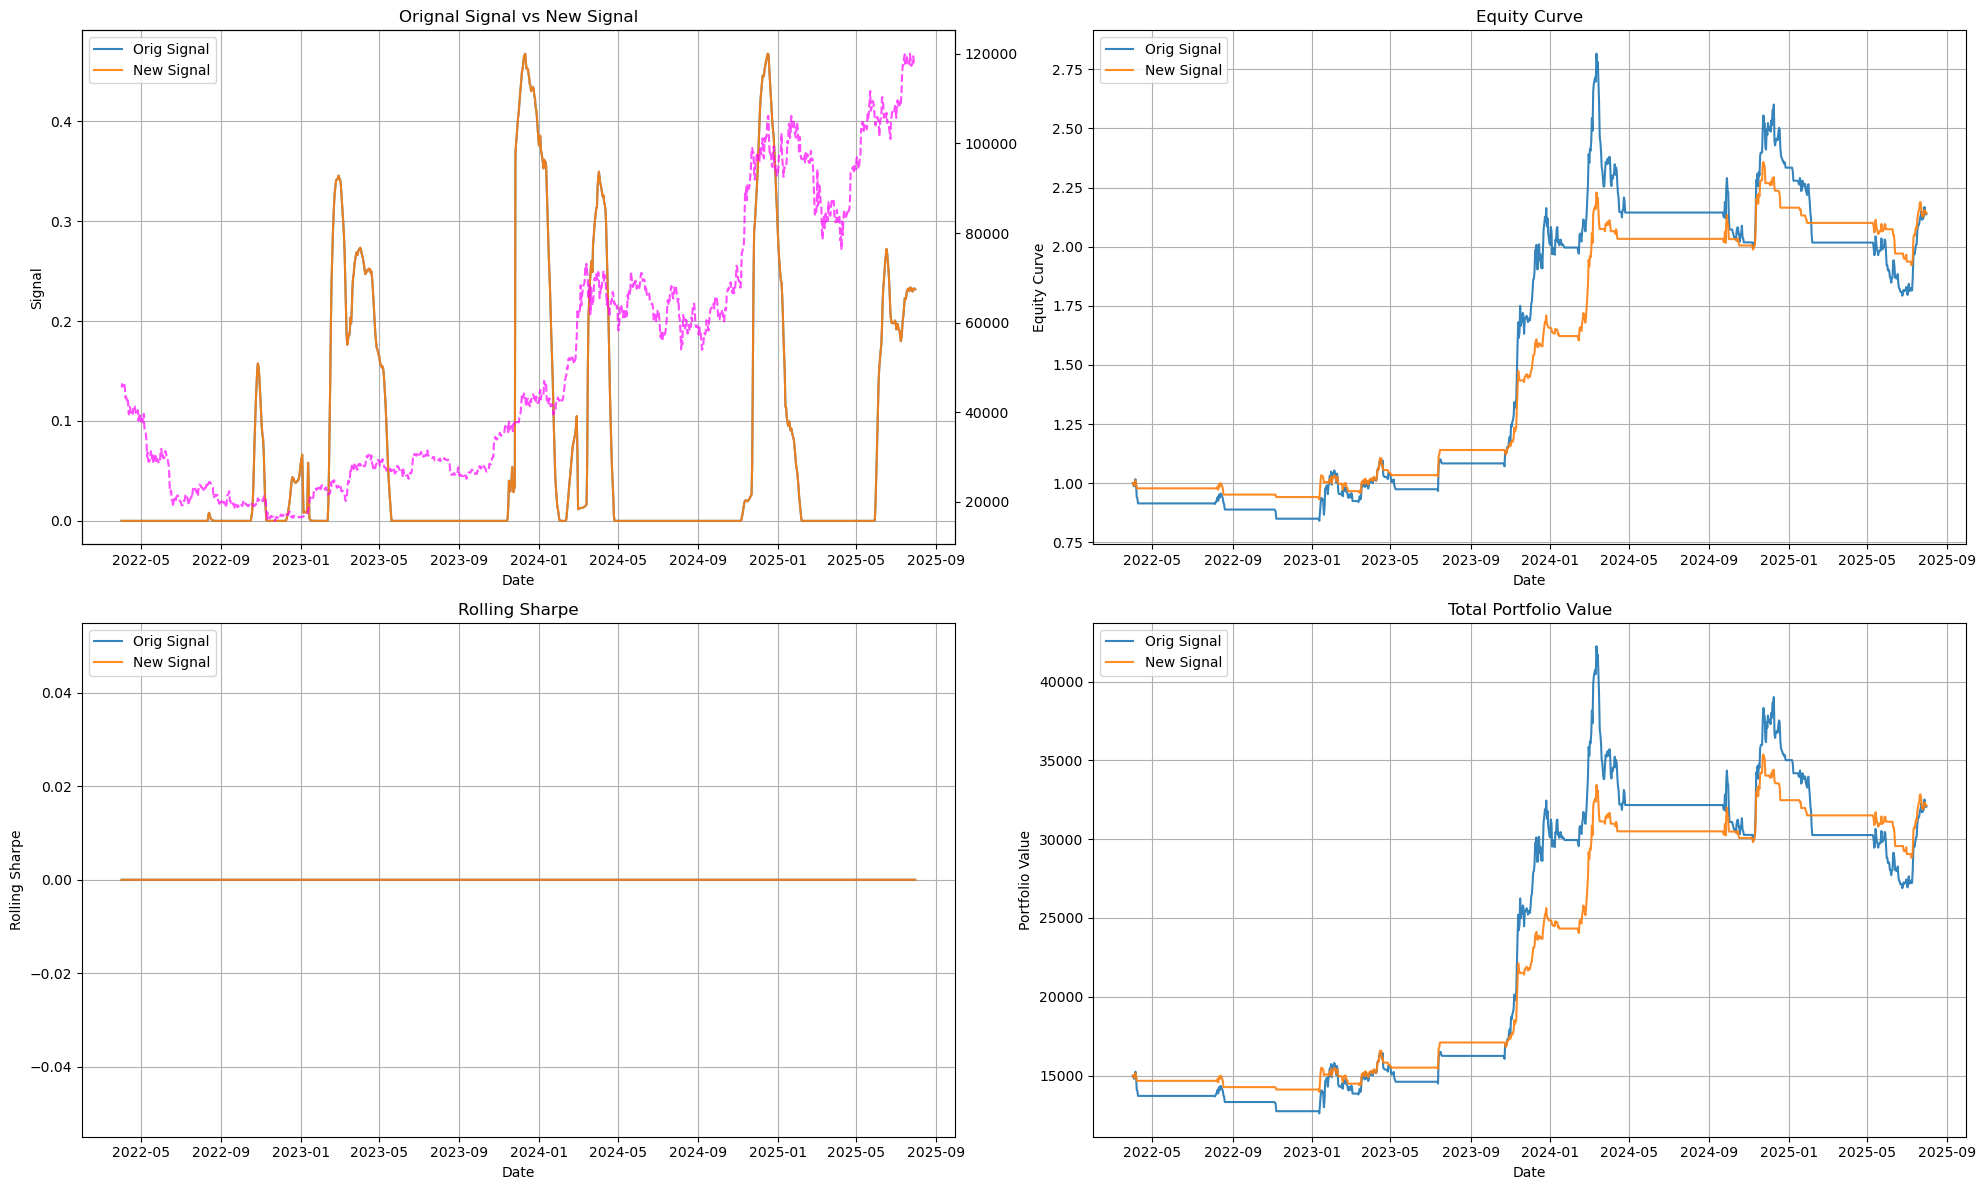

In [337]:
plot_signal_performance(df_final_orig_config, df_final_new_config, ticker='BTC-USD')

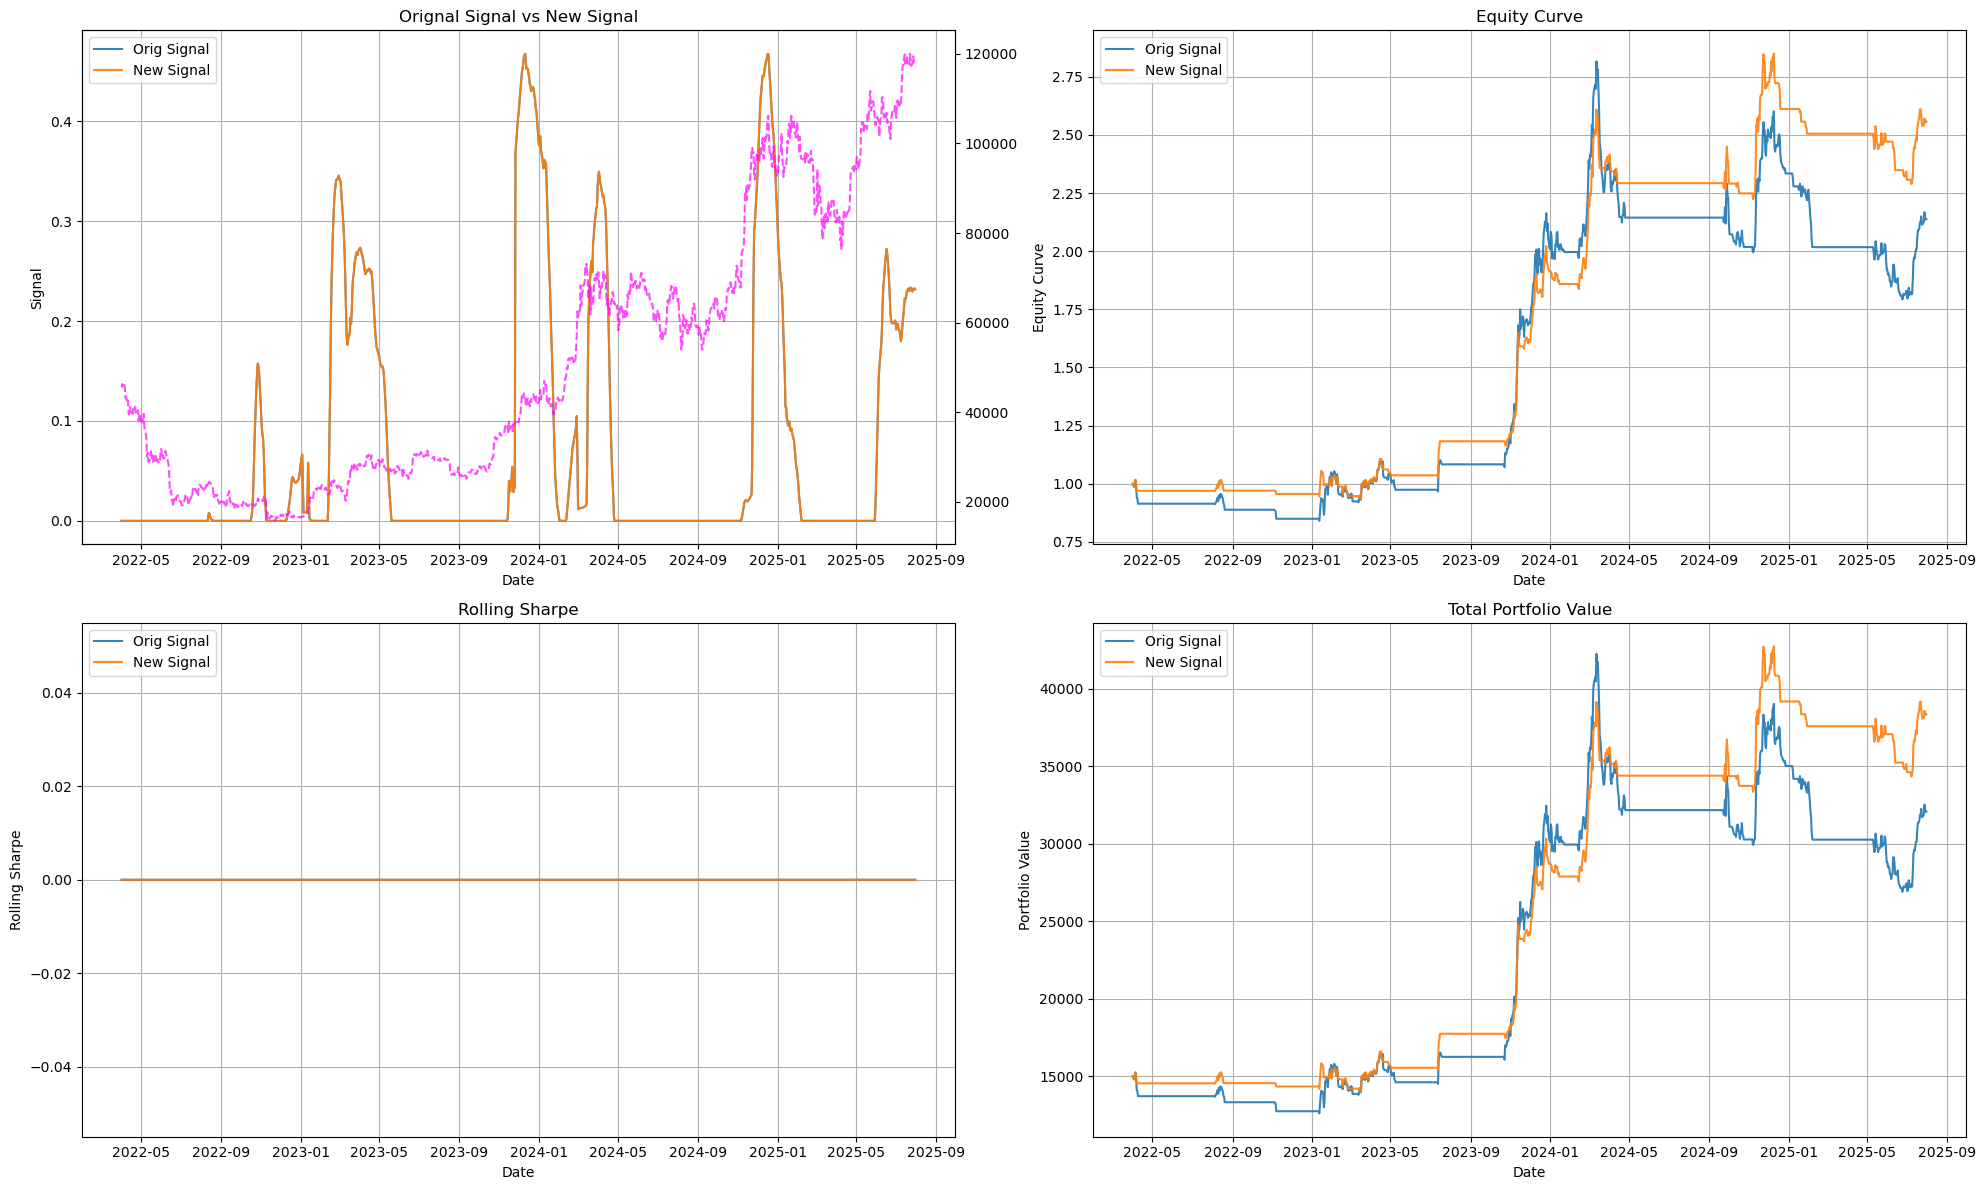

In [345]:
plot_signal_performance(df_final_orig_config, df_final_new_config_tv, ticker='BTC-USD')

## Annualized Target Volatility Walk Forward Re-Run with New Config

In [348]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.40,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "annualized_target_volatility": [0.40, 0.45, 0.50, 0.55, 0.60]
}

df_target_volatility_2 = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=5, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 5 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/5: annualized_target_volatility=0.4, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/5 METRICS: Sharpe=0.353, MDD=-8.013%, trades=47
[WFA] Fold 1 | IS cfg 2/5: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr

In [350]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_target_volatility_2['trade_count'] == 0.0)
df_target_volatility_2['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_target_volatility_2['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_target_volatility_2['vol_tracking_error'] = (np.abs(df_target_volatility_2['annualized_std_dev'] - df_target_volatility_2['annualized_target_volatility']) / df_target_volatility_2['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_target_volatility_2 = df_target_volatility_2.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_target_volatility_2.sampling_category == 'in_sample')
df_target_volatility_2_is = df_target_volatility_2[in_sample_cond].reset_index(drop=True)
df_target_volatility_2_os = df_target_volatility_2[~in_sample_cond].reset_index(drop=True)

In [352]:
df_target_volatility_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Target_Volatility_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_target_volatility_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Target_Volatility_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [354]:
df_target_volatility_2.groupby(['annualized_target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                              median      mean       std   
annualized_target_volatility                                               
0.55                                        2.148539  1.904217  0.659538   
0.50                                        2.146655  2.339636  1.430627   
0.60                                        2.137940  1.880852  0.642325   
0.45                                        2.010212  0.924869  2.822225   
0.40                                        1.845928  0.566549  2.649500   

                             annualized_return                      \
                                        median      mean       std   
annualized_target_volatility                                         
0.55                                  0.731289  0.625968  0.243888   
0.50                                  0.651931  1.281919  2.001829   
0.60                                  0.739054  0.640784  0.248567   
0.45                                  0.517789  0.793617  1.563573   
0.40                                  0.425144  0.368158  0.419917   

                             max_drawdown                      \
                                   median      mean       std   
annualized_target_volatility                                    
0.55                            -0.121495 -0.127031  0.016668   
0.50                            -0.107679 -0.108581  0.026985   
0.60                            -0.125631 -0.131418  0.015282   
0.45                            -0.080650 -0.079557  0.032200   
0.40                            -0.075690 -0.073085  0.027799   

                             annualized_std_dev                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.55                                   0.517070  0.512330  0.016428   
0.50                                   0.482260  0.482620  0.031643   
0.60                                   0.549392  0.536622  0.022693   
0.45                                   0.441006  0.398819  0.140099   
0.40                                   0.403892  0.354039  0.126670   

                             vol_tracking_error                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.55                                   0.059872  0.068490  0.029869   
0.50                                   0.048079  0.058327  0.038703   
0.60                                   0.084347  0.105630  0.037822   
0.45                                   0.050283  0.189418  0.268737   
0.40                                   0.070676  0.183486  0.279488   

                             trade_count                        \
                                  median       mean        std   
annualized_target_volatility                                     
0.55                               106.0  95.285714  22.903524   
0.50                                98.5  86.000000  25.264317   
0.60                               107.0  96.571429  23.782747   
0.45                                44.0  52.642857  40.987066   
0.40                                47.0  48.846154  38.148495   

                             BTC-USD_annualized_sharpe_ratio            \
                                                      median      mean   
annualized_target_volatility                                             
0.55                                                0.610415  0.509951   
0.50                                                0.608766  0.609204   
0.60                                                0.612720  0.487763   
0.45                                                0.594487 -0.230897   
0.40                                                0.497604 -0.363668   

                                       ETH-USD_annualized_sharpe_ratio  \
    

In [356]:
df_target_volatility_2_is.groupby(['annualized_target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                              median      mean       std   
annualized_target_volatility                                               
0.40                                        2.243444  1.966264  0.738814   
0.45                                        2.178254  1.931328  0.682678   
0.55                                        2.148539  1.904217  0.659538   
0.50                                        2.140062  1.881155  0.652607   
0.60                                        2.137940  1.880852  0.642325   

                             annualized_return                      \
                                        median      mean       std   
annualized_target_volatility                                         
0.40                                  0.565741  0.506342  0.204100   
0.45                                  0.623558  0.550856  0.215636   
0.55                                  0.731289  0.625968  0.243888   
0.50                                  0.642808  0.578000  0.224763   
0.60                                  0.739054  0.640784  0.248567   

                             max_drawdown                      \
                                   median      mean       std   
annualized_target_volatility                                    
0.40                            -0.088022 -0.089948  0.015460   
0.45                            -0.103284 -0.101974  0.021051   
0.55                            -0.121495 -0.127031  0.016668   
0.50                            -0.112874 -0.116179  0.017631   
0.60                            -0.125631 -0.131418  0.015282   

                             annualized_std_dev                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.40                                   0.416917  0.419650  0.019287   
0.45                                   0.445964  0.445116  0.018179   
0.55                                   0.517070  0.512330  0.016428   
0.50                                   0.478225  0.473404  0.019375   
0.60                                   0.549392  0.536622  0.022693   

                             vol_tracking_error                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.40                                   0.042292  0.055147  0.039903   
0.45                                   0.035272  0.035374  0.017593   
0.55                                   0.059872  0.068490  0.029869   
0.50                                   0.043551  0.053192  0.038750   
0.60                                   0.084347  0.105630  0.037822   

                             trade_count                        \
                                  median       mean        std   
annualized_target_volatility                                     
0.40                                90.0  80.714286  16.459185   
0.45                               100.0  88.571429  20.435730   
0.55                               106.0  95.285714  22.903524   
0.50                               101.0  91.571429  21.329613   
0.60                               107.0  96.571429  23.782747   

                             BTC-USD_annualized_sharpe_ratio            \
                                                      median      mean   
annualized_target_volatility                                             
0.40                                                0.501342  0.497348   
0.45                                                0.594487  0.519222   
0.55                                                0.610415  0.509951   
0.50                                                0.583968  0.506901   
0.60                                                0.612720  0.487763   

                                       ETH-USD_annualized_sharpe_ratio  \
    

In [358]:
df_target_volatility_2_os.groupby(['annualized_target_volatility']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                              median      mean       std   
annualized_target_volatility                                               
0.50                                        5.549004  5.549004       NaN   
0.45                                        0.408499 -0.081591  3.798391   
0.40                                       -0.797226 -1.066452  3.201517   

                             annualized_return                      \
                                        median      mean       std   
annualized_target_volatility                                         
0.50                                  6.209355  6.209355       NaN   
0.45                                  0.093478  1.036377  2.261189   
0.40                                 -0.019211  0.206944  0.561502   

                             max_drawdown                      \
                                   median      mean       std   
annualized_target_volatility                                    
0.50                            -0.055399 -0.055399       NaN   
0.45                            -0.047820 -0.057139  0.025113   
0.40                            -0.054427 -0.053411  0.026556   

                             annualized_std_dev                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.50                                   0.547134  0.547134       NaN   
0.45                                   0.436048  0.352522  0.192861   
0.40                                   0.325953  0.277493  0.158129   

                             vol_tracking_error                      \
                                         median      mean       std   
annualized_target_volatility                                          
0.50                                   0.094267  0.094267       NaN   
0.45                                   0.248777  0.343461  0.317486   
0.40                                   0.220675  0.333215  0.368239   

                             trade_count                        \
                                  median       mean        std   
annualized_target_volatility                                     
0.50                                47.0  47.000000        NaN   
0.45                                12.0  16.714286  14.499589   
0.40                                 8.0  11.666667   9.330952   

                             BTC-USD_annualized_sharpe_ratio            \
                                                      median      mean   
annualized_target_volatility                                             
0.50                                                1.325329  1.325329   
0.45                                               -1.162868 -1.106037   
0.40                                               -3.023255 -1.569090   

                                       ETH-USD_annualized_sharpe_ratio  \
                                   std                          median   
annualized_target_volatility                                             
0.50                               NaN                       -1.139042   
0.45                          2.766231                       -1.030426   
0.40                          2.939931                       -0.252424   

                                                  \
                                  mean       std   
annualized_target_volatility                       
0.50                         -1.139042       NaN   
0.45                         -0.478769  2.501000   
0.40                         -0.357713  3.559909   

                             SOL-USD_annualized_sharpe_ratio            \
                                                      median      mean   
annualized_target_volatility                                             
0.50                                                1.189120  1.189120   
0.45      

In [360]:
df_target_volatility_2_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.040983   
1         out_sample  2023-10-01  2023-12-31           6.209355   
2         out_sample  2024-01-01  2024-03-31           1.296717   
3         out_sample  2024-01-01  2024-03-31           1.212240   
4         out_sample  2024-04-01  2024-06-30          -0.133696   
5         out_sample  2024-04-01  2024-06-30          -0.149255   
6         out_sample  2024-07-01  2024-09-30           0.085207   
7         out_sample  2024-07-01  2024-09-30           0.093478   
8         out_sample  2024-10-01  2024-12-31           0.287263   
9         out_sample  2024-10-01  2024-12-31           0.384985   
10        out_sample  2025-01-01  2025-03-31          -0.123628   
11        out_sample  2025-01-01  2025-03-31          -0.149022   
12        out_sample  2025-04-01  2025-06-30          -0.170197   
13        out_sample  2025-04-01  2025-06-30          -0.178768   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.648056    126.328103            0.515683     -0.047820   
1                  5.549004    112.083405            0.547134     -0.055399   
2                  3.188360     17.593241            0.400175     -0.073705   
3                  2.862759     13.873141            0.472147     -0.087380   
4                 -3.800688     -3.803698            0.108112     -0.035149   
5                 -3.691679     -3.778728            0.121672     -0.039499   
6                  0.373578      3.914356            0.428271     -0.021768   
7                  0.408499      3.744328            0.561950     -0.024965   
8                  1.118281      3.497202            0.403892     -0.082141   
9                  1.349070      4.715462            0.436048     -0.081643   
10                -5.310214     -3.861502            0.072778     -0.032016   
11                -5.210400     -3.820253            0.083543     -0.039008   
12                -1.968029     -2.248593            0.251731     -0.075690   
13                -1.937443     -2.244218            0.276614     -0.079657   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.391304     2.905974  0.004597         42.0   
1                25 days  0.402174     2.854050  0.005345         47.0   
2                49 days  0.274725     1.687252  0.095018         22.0   
3                50 days  0.274725     1.518558  0.132379         26.0   
4                90 days  0.010989    -1.413004  0.161104          4.0   
5                90 days  0.010989    -1.412568  0.161231          4.0   
6                85 days  0.043478     0.427849  0.669772          4.0   
7                85 days  0.043478     0.417565  0.677249          4.0   
8                38 days  0.206522     0.684179  0.495601         24.0   
9                38 days  0.195652     0.787016  0.433317         24.0   
10               89 days  0.011111    -1.922713  0.057714          4.0   
11               89 days  0.011111    -1.984192  0.050315          5.0   
12               47 days  0.175824    -0.772957  0.441573         12.0   
13               47 days  0.164835    -0.769248  0.443760         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.50         Chandelier            1.75   
2                           0.40         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.40         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.40         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.40         Chandelier          

## Notional Threshold Percent Walk Forward Analysis
### Lock in Annualized Target Volatility of 0.45

In [364]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "notional_threshold_pct": [0.10, 0.15, 0.20]
}

df_notional_threshold_pct = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=3, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'notional_threshold_pct']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 3 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/3: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, notional_threshold_pct=0.1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/3 METRICS: Sharpe=0.426, MDD=-7.862%, trades=46
[WFA] Fold 1 | IS cfg 2/3: annualized_tar

In [366]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_notional_threshold_pct['trade_count'] == 0.0)
df_notional_threshold_pct['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_notional_threshold_pct['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_notional_threshold_pct['vol_tracking_error'] = (np.abs(df_notional_threshold_pct['annualized_std_dev'] - df_notional_threshold_pct['annualized_target_volatility']) / df_notional_threshold_pct['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_notional_threshold_pct = df_notional_threshold_pct.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_notional_threshold_pct.sampling_category == 'in_sample')
df_notional_threshold_pct_is = df_notional_threshold_pct[in_sample_cond].reset_index(drop=True)
df_notional_threshold_pct_os = df_notional_threshold_pct[~in_sample_cond].reset_index(drop=True)

In [368]:
df_notional_threshold_pct.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Notional_Threshold_Pct_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_notional_threshold_pct = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Notional_Threshold_Pct_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [370]:
df_notional_threshold_pct.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.188927  1.681971  2.745914   
0.20                                  1.990960  0.959598  2.824741   
0.15                                  1.633099  0.759499  1.959188   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            0.629318  1.096019  1.775629    -0.088028   
0.20                            0.556930  0.825614  1.504844    -0.086637   
0.15                            0.400201  0.326777  0.318591    -0.090274   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.088803  0.029878           0.452281  0.418718   
0.20                   -0.083522  0.035964           0.505249  0.446098   
0.15                   -0.089301  0.033251           0.470299  0.438430   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.120858           0.045615  0.125714  0.244828   
0.20                    0.165011           0.158635  0.265878  0.241690   
0.15                    0.127914           0.084144  0.174999  0.218724   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                          84.5  69.300000  36.301362   
0.20                          29.5  35.142857  27.126079   
0.15                          64.0  46.727273  32.190343   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.606108  0.090492  1.719300   
0.20                                          0.569923 -0.147603  2.079882   
0.15                                          0.493485 -0.030091  1.678758   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.718836  0.456046  1.296986   
0.20                                          0.710473  0.056938  1.787275   
0.15                                          0.592793 -0.346941  1.799883   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.268688 -0.701175  3.073279   
0.20                                          0.110176 -0.658287  1.185134   
0.15                                         -0.043909 -0.459096  0.889166   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.220420 -0.225608  4.087195   
0.20                                          0.588082 -0.898021  6.574972   
0.15                                          0.237114 -1.948171  6.374281   



In [372]:
df_notional_threshold_pct_is.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.178254  1.931328  0.682678   
0.20                                  2.156419  1.948849  0.697443   
0.15                                  2.098603  1.807093  0.685364   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            0.623558  0.550856  0.215636    -0.103284   
0.20                            0.621029  0.586615  0.237259    -0.110808   
0.15                            0.567290  0.506037  0.206207    -0.104272   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.101974  0.021051           0.445964  0.445116   
0.20                   -0.110085  0.022200           0.509120  0.509932   
0.15                   -0.106052  0.019561           0.480739  0.479356   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.018179           0.035272  0.035374  0.017593   
0.20                    0.018024           0.131378  0.133182  0.040053   
0.15                    0.016386           0.068308  0.065236  0.036414   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                         100.0  88.571429  20.435730   
0.20                          66.0  59.000000  13.515423   
0.15                          76.0  68.000000  15.631165   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.594487  0.519222  0.472125   
0.20                                          0.569923  0.472573  0.438540   
0.15                                          0.511935  0.496126  0.396669   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.718836  0.405688  0.651416   
0.20                                          0.719592  0.284796  0.793744   
0.15                                          0.613948  0.303064  0.754853   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.268688  0.198177  0.270031   
0.20                                          0.109563 -0.579826  0.989540   
0.15                                         -0.043942 -0.647597  0.930875   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.220420  0.297913  0.918585   
0.20                                          0.588082  0.562630  1.001378   
0.15                                          0.250703  0.287783  0.861091   



In [373]:
df_notional_threshold_pct_os.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.862759  1.100138  5.639737   
0.20                                  0.443148 -0.029653  3.810290   
0.15                                 -0.786127 -1.073789  2.193921   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            1.212240  2.368067  3.252844    -0.047820   
0.20                            0.100881  1.064612  2.171857    -0.042989   
0.15                           -0.023046  0.013072  0.217018    -0.060216   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.058070  0.025763           0.472147  0.357124   
0.20                   -0.056959  0.025752           0.450874  0.382264   
0.15                   -0.059987  0.033462           0.375490  0.366810   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.237926           0.145963  0.336509  0.416639   
0.20                    0.221727           0.374285  0.398575  0.289610   
0.15                    0.207980           0.347795  0.367084  0.281973   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                          26.0  24.333333  18.556221   
0.20                          11.0  11.285714   9.141741   
0.15                           7.5   9.500000   7.852813   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.638699 -0.909877  3.238644   
0.20                                         -0.964198 -0.871142  2.997453   
0.15                                         -2.964435 -1.257930  2.996573   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.632301  0.632301  3.291116   
0.20                                         -0.478499 -0.474730  3.446560   
0.15                                         -2.621959 -2.621959  3.031311   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                         -3.848910 -3.848910  7.045889   
0.20                                          0.143752 -0.841363  1.819631   
0.15                                          0.200657  0.200657  0.080476   

                       ADA-USD_annualized_sharpe_ratio                        \
                                                median       mean        std   
notional_threshold_pct                                                         
0.10                                         -2.057929  -2.057929  10.951949   
0.20                                         -6.010299  -6.010299  16.511215   
0.15                                        -17.599845 -17.599845    

In [376]:
df_notional_threshold_pct_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           5.781964   
1         out_sample  2023-10-01  2023-12-31           6.040983   
2         out_sample  2024-01-01  2024-03-31           1.587361   
3         out_sample  2024-01-01  2024-03-31           1.212240   
4         out_sample  2024-04-01  2024-06-30          -0.149255   
5         out_sample  2024-04-01  2024-06-30          -0.149255   
6         out_sample  2024-07-01  2024-09-30           0.100881   
7         out_sample  2024-07-01  2024-09-30           0.103162   
8         out_sample  2024-10-01  2024-12-31           0.277461   
9         out_sample  2024-10-01  2024-12-31           0.448514   
10        out_sample  2025-01-01  2025-03-31          -0.138097   
11        out_sample  2025-01-01  2025-03-31          -0.149022   
12        out_sample  2025-04-01  2025-06-30          -0.179081   
13        out_sample  2025-04-01  2025-06-30          -0.179081   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.398138    134.497145            0.619910     -0.042989   
1                  5.648056    126.328103            0.515683     -0.047820   
2                  3.323176     16.865717            0.450874     -0.094118   
3                  2.862759     13.873141            0.472147     -0.087380   
4                 -3.691679     -3.778728            0.121672     -0.039499   
5                 -3.691679     -3.778728            0.121672     -0.039499   
6                  0.443148      3.392533            0.594587     -0.029736   
7                  0.488421      4.228338            0.594587     -0.024398   
8                  0.968776      2.917061            0.469408     -0.095117   
9                  1.530092      5.943795            0.525308     -0.075459   
10                -5.149774     -3.838062            0.081925     -0.035981   
11                -5.210400     -3.820253            0.083543     -0.039008   
12                -2.060675     -2.212693            0.281572     -0.080934   
13                -2.060675     -2.212693            0.281572     -0.080934   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.402174     2.778599  0.006631         28.0   
1                25 days  0.391304     2.905974  0.004597         42.0   
2                45 days  0.252747     1.745244  0.084355         14.0   
3                50 days  0.274725     1.518558  0.132379         26.0   
4                90 days  0.010989    -1.412568  0.161231          4.0   
5                90 days  0.010989    -1.412568  0.161231          4.0   
6                85 days  0.043478     0.420434  0.675160          2.0   
7                85 days  0.043478     0.459654  0.646861          3.0   
8                38 days  0.195652     0.593618  0.554240         20.0   
9                38 days  0.217391     0.876327  0.383160         16.0   
10               89 days  0.011111    -1.922689  0.057717          4.0   
11               89 days  0.011111    -1.984192  0.050315          5.0   
12               47 days  0.164835    -0.819225  0.414822         11.0   
13               47 days  0.164835    -0.819225  0.414822         11.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

In [378]:
df_notional_threshold_pct_is

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.105316   
1          in_sample  2022-04-01  2023-09-30           0.090945   
2          in_sample  2022-04-01  2023-09-30           0.104985   
3          in_sample  2022-07-01  2023-12-31           0.480980   
4          in_sample  2022-07-01  2023-12-31           0.400201   
5          in_sample  2022-07-01  2023-12-31           0.523117   
6          in_sample  2022-10-01  2024-03-31           0.740237   
7          in_sample  2022-10-01  2024-03-31           0.683891   
8          in_sample  2022-10-01  2024-03-31           0.821966   
9          in_sample  2023-01-01  2024-06-30           0.716225   
10         in_sample  2023-01-01  2024-06-30           0.671161   
11         in_sample  2023-01-01  2024-06-30           0.786948   
12         in_sample  2023-04-01  2024-09-30           0.554598   
13         in_sample  2023-04-01  2024-09-30           0.567290   
14         in_sample  2023-04-01  2024-09-30           0.590743   
15         in_sample  2023-07-01  2024-12-31           0.623558   
16         in_sample  2023-07-01  2024-12-31           0.597295   
17         in_sample  2023-07-01  2024-12-31           0.657521   
18         in_sample  2023-10-01  2025-03-31           0.635077   
19         in_sample  2023-10-01  2025-03-31           0.531478   
20         in_sample  2023-10-01  2025-03-31           0.621029   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.426124      1.339611            0.423242     -0.078617   
1                  0.337497      1.007437            0.465553     -0.090274   
2                  0.426793      1.238625            0.495364     -0.084759   
3                  1.876610      6.201196            0.431093     -0.077562   
4                  1.633099      4.683215            0.499991     -0.085454   
5                  1.919947      5.909904            0.543136     -0.088515   
6                  2.387806      8.347745            0.464150     -0.088675   
7                  2.283200      7.736851            0.495637     -0.088394   
8                  2.488002      8.648063            0.514999     -0.095046   
9                  2.307091      6.934517            0.458597     -0.103284   
10                 2.227676      6.436625            0.487865     -0.104272   
11                 2.382955      7.101878            0.501377     -0.110808   
12                 2.178254      4.953831            0.426892     -0.111953   
13                 2.169175      5.098705            0.470299     -0.111261   
14                 2.156419      5.016983            0.488064     -0.117749   
15                 2.199600      4.920422            0.445964     -0.126729   
16                 2.098603      4.553492            0.480739     -0.131173   
17                 2.205857      5.107014            0.509120     -0.128749   
18                 2.143815      5.000559            0.465873     -0.127001   
19                 1.900401      4.040539            0.455412     -0.131537   
20                 2.061972      4.283961            0.517464     -0.144966   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               283 days  0.089416     0.936084  0.349643         46.0   
1               284 days  0.085766     0.831784  0.405894         36.0   
2               284 days  0.082117     0.940915  0.347164         31.0   
3               152 days  0.151184     2.611518  0.009261         87.0   
4               152 days  0.142077     2.323365  0.020525         64.0   
5               152 days  0.142077     2.647405  0.008345         56.0   
6               103 days  0.189781     3.195334  0.001477        100.0   
7               103 days  0.182482     3.073031  0.002225         76.0   
8               103 days  0.184307     3.305984  0.001008         66.0   
9               110 days  0.191956     3.091308  

## Notional Threshold Percent Walk Forward With Overlapping Timeframes

In [382]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "notional_threshold_pct": [0.10, 0.20]
}

df_notional_threshold_pct_w_overlap = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=False, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=1m, warmup=300d, tickers=5, grid_size=2, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'notional_threshold_pct']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 2 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/2: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, notional_threshold_pct=0.1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/2 METRICS: Sharpe=0.426, MDD=-7.862%, trades=46
[WFA] Fold 1 | IS cfg 2/2: annualized_target_

In [384]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_notional_threshold_pct_w_overlap['trade_count'] == 0.0)
df_notional_threshold_pct_w_overlap['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_notional_threshold_pct_w_overlap['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_notional_threshold_pct_w_overlap['vol_tracking_error'] = (np.abs(df_notional_threshold_pct_w_overlap['annualized_std_dev'] - df_notional_threshold_pct_w_overlap['annualized_target_volatility']) / df_notional_threshold_pct_w_overlap['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_notional_threshold_pct_w_overlap = df_notional_threshold_pct.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_notional_threshold_pct_w_overlap.sampling_category == 'in_sample')
df_notional_threshold_pct_w_overlap_is = df_notional_threshold_pct_w_overlap[in_sample_cond].reset_index(drop=True)
df_notional_threshold_pct_w_overlap_os = df_notional_threshold_pct_w_overlap[~in_sample_cond].reset_index(drop=True)

In [385]:
df_notional_threshold_pct_w_overlap.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Notional_Threshold_Pct_w_Overlap_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_notional_threshold_pct_w_overlap = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Notional_Threshold_Pct_w_Overlap_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [386]:
df_notional_threshold_pct_w_overlap.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.188927  1.681971  2.745914   
0.20                                  1.990960  0.959598  2.824741   
0.15                                  1.633099  0.759499  1.959188   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            0.629318  1.096019  1.775629    -0.088028   
0.20                            0.556930  0.825614  1.504844    -0.086637   
0.15                            0.400201  0.326777  0.318591    -0.090274   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.088803  0.029878           0.452281  0.418718   
0.20                   -0.083522  0.035964           0.505249  0.446098   
0.15                   -0.089301  0.033251           0.470299  0.438430   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.120858           0.045615  0.125714  0.244828   
0.20                    0.165011           0.158635  0.265878  0.241690   
0.15                    0.127914           0.084144  0.174999  0.218724   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                          84.5  69.300000  36.301362   
0.20                          29.5  35.142857  27.126079   
0.15                          64.0  46.727273  32.190343   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.606108  0.090492  1.719300   
0.20                                          0.569923 -0.147603  2.079882   
0.15                                          0.493485 -0.030091  1.678758   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.718836  0.456046  1.296986   
0.20                                          0.710473  0.056938  1.787275   
0.15                                          0.592793 -0.346941  1.799883   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.268688 -0.701175  3.073279   
0.20                                          0.110176 -0.658287  1.185134   
0.15                                         -0.043909 -0.459096  0.889166   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.220420 -0.225608  4.087195   
0.20                                          0.588082 -0.898021  6.574972   
0.15                                          0.237114 -1.948171  6.374281   



In [387]:
df_notional_threshold_pct_w_overlap_is.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.178254  1.931328  0.682678   
0.20                                  2.156419  1.948849  0.697443   
0.15                                  2.098603  1.807093  0.685364   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            0.623558  0.550856  0.215636    -0.103284   
0.20                            0.621029  0.586615  0.237259    -0.110808   
0.15                            0.567290  0.506037  0.206207    -0.104272   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.101974  0.021051           0.445964  0.445116   
0.20                   -0.110085  0.022200           0.509120  0.509932   
0.15                   -0.106052  0.019561           0.480739  0.479356   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.018179           0.035272  0.035374  0.017593   
0.20                    0.018024           0.131378  0.133182  0.040053   
0.15                    0.016386           0.068308  0.065236  0.036414   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                         100.0  88.571429  20.435730   
0.20                          66.0  59.000000  13.515423   
0.15                          76.0  68.000000  15.631165   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.594487  0.519222  0.472125   
0.20                                          0.569923  0.472573  0.438540   
0.15                                          0.511935  0.496126  0.396669   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.718836  0.405688  0.651416   
0.20                                          0.719592  0.284796  0.793744   
0.15                                          0.613948  0.303064  0.754853   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.268688  0.198177  0.270031   
0.20                                          0.109563 -0.579826  0.989540   
0.15                                         -0.043942 -0.647597  0.930875   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.220420  0.297913  0.918585   
0.20                                          0.588082  0.562630  1.001378   
0.15                                          0.250703  0.287783  0.861091   



In [388]:
df_notional_threshold_pct_w_overlap_os.groupby(['notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
notional_threshold_pct                                               
0.10                                  2.862759  1.100138  5.639737   
0.20                                  0.443148 -0.029653  3.810290   
0.15                                 -0.786127 -1.073789  2.193921   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
notional_threshold_pct                                                      
0.10                            1.212240  2.368067  3.252844    -0.047820   
0.20                            0.100881  1.064612  2.171857    -0.042989   
0.15                           -0.023046  0.013072  0.217018    -0.060216   

                                           annualized_std_dev            \
                            mean       std             median      mean   
notional_threshold_pct                                                    
0.10                   -0.058070  0.025763           0.472147  0.357124   
0.20                   -0.056959  0.025752           0.450874  0.382264   
0.15                   -0.059987  0.033462           0.375490  0.366810   

                                 vol_tracking_error                      \
                             std             median      mean       std   
notional_threshold_pct                                                    
0.10                    0.237926           0.145963  0.336509  0.416639   
0.20                    0.221727           0.374285  0.398575  0.289610   
0.15                    0.207980           0.347795  0.367084  0.281973   

                       trade_count                        \
                            median       mean        std   
notional_threshold_pct                                     
0.10                          26.0  24.333333  18.556221   
0.20                          11.0  11.285714   9.141741   
0.15                           7.5   9.500000   7.852813   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.638699 -0.909877  3.238644   
0.20                                         -0.964198 -0.871142  2.997453   
0.15                                         -2.964435 -1.257930  2.996573   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                          0.632301  0.632301  3.291116   
0.20                                         -0.478499 -0.474730  3.446560   
0.15                                         -2.621959 -2.621959  3.031311   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
notional_threshold_pct                                                       
0.10                                         -3.848910 -3.848910  7.045889   
0.20                                          0.143752 -0.841363  1.819631   
0.15                                          0.200657  0.200657  0.080476   

                       ADA-USD_annualized_sharpe_ratio                        \
                                                median       mean        std   
notional_threshold_pct                                                         
0.10                                         -2.057929  -2.057929  10.951949   
0.20                                         -6.010299  -6.010299  16.511215   
0.15                                        -17.599845 -17.599845    

In [389]:
df_notional_threshold_pct_w_overlap_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           5.781964   
1         out_sample  2023-10-01  2023-12-31           6.040983   
2         out_sample  2024-01-01  2024-03-31           1.587361   
3         out_sample  2024-01-01  2024-03-31           1.212240   
4         out_sample  2024-04-01  2024-06-30          -0.149255   
5         out_sample  2024-04-01  2024-06-30          -0.149255   
6         out_sample  2024-07-01  2024-09-30           0.100881   
7         out_sample  2024-07-01  2024-09-30           0.103162   
8         out_sample  2024-10-01  2024-12-31           0.277461   
9         out_sample  2024-10-01  2024-12-31           0.448514   
10        out_sample  2025-01-01  2025-03-31          -0.138097   
11        out_sample  2025-01-01  2025-03-31          -0.149022   
12        out_sample  2025-04-01  2025-06-30          -0.179081   
13        out_sample  2025-04-01  2025-06-30          -0.179081   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.398138    134.497145            0.619910     -0.042989   
1                  5.648056    126.328103            0.515683     -0.047820   
2                  3.323176     16.865717            0.450874     -0.094118   
3                  2.862759     13.873141            0.472147     -0.087380   
4                 -3.691679     -3.778728            0.121672     -0.039499   
5                 -3.691679     -3.778728            0.121672     -0.039499   
6                  0.443148      3.392533            0.594587     -0.029736   
7                  0.488421      4.228338            0.594587     -0.024398   
8                  0.968776      2.917061            0.469408     -0.095117   
9                  1.530092      5.943795            0.525308     -0.075459   
10                -5.149774     -3.838062            0.081925     -0.035981   
11                -5.210400     -3.820253            0.083543     -0.039008   
12                -2.060675     -2.212693            0.281572     -0.080934   
13                -2.060675     -2.212693            0.281572     -0.080934   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.402174     2.778599  0.006631         28.0   
1                25 days  0.391304     2.905974  0.004597         42.0   
2                45 days  0.252747     1.745244  0.084355         14.0   
3                50 days  0.274725     1.518558  0.132379         26.0   
4                90 days  0.010989    -1.412568  0.161231          4.0   
5                90 days  0.010989    -1.412568  0.161231          4.0   
6                85 days  0.043478     0.420434  0.675160          2.0   
7                85 days  0.043478     0.459654  0.646861          3.0   
8                38 days  0.195652     0.593618  0.554240         20.0   
9                38 days  0.217391     0.876327  0.383160         16.0   
10               89 days  0.011111    -1.922689  0.057717          4.0   
11               89 days  0.011111    -1.984192  0.050315          5.0   
12               47 days  0.164835    -0.819225  0.414822         11.0   
13               47 days  0.164835    -0.819225  0.414822         11.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Donchian Exit Gate Walk Forward Analysis
### Locking in Notional Threshold Percent of 0.10

In [399]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "use_donchian_exit_gate": [True, False]
}

df_donchian_exit_gate = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=2, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'use_donchian_exit_gate']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 2 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/2: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, use_donchian_exit_gate=True
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/2 METRICS: Sharpe=0.426, MDD=-7.862%, trades=46
[WFA] Fold 1 | IS cfg 2/2: annualized_ta

In [400]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_donchian_exit_gate['trade_count'] == 0.0)
df_donchian_exit_gate['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_donchian_exit_gate['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_donchian_exit_gate['vol_tracking_error'] = (np.abs(df_donchian_exit_gate['annualized_std_dev'] - df_donchian_exit_gate['annualized_target_volatility']) / df_donchian_exit_gate['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_donchian_exit_gate = df_donchian_exit_gate.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_donchian_exit_gate.sampling_category == 'in_sample')
df_donchian_exit_gate_is = df_donchian_exit_gate[in_sample_cond].reset_index(drop=True)
df_donchian_exit_gate_os = df_donchian_exit_gate[~in_sample_cond].reset_index(drop=True)

In [401]:
df_donchian_exit_gate.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Exit_Gate_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_donchian_exit_gate = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Exit_Gate_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [407]:
df_donchian_exit_gate.groupby(['use_donchian_exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
use_donchian_exit_gate                                               
False                                 2.010212  0.924869  2.822225   
True                                  2.010212  0.924869  2.822225   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
use_donchian_exit_gate                                                      
False                           0.517789  0.793617  1.563573     -0.08065   
True                            0.517789  0.793617  1.563573     -0.08065   

                                         annualized_std_dev            \
                            mean     std             median      mean   
use_donchian_exit_gate                                                  
False                  -0.079557  0.0322           0.441006  0.398819   
True                   -0.079557  0.0322           0.441006  0.398819   

                                 vol_tracking_error                      \
                             std             median      mean       std   
use_donchian_exit_gate                                                    
False                   0.140099           0.050283  0.189418  0.268737   
True                    0.140099           0.050283  0.189418  0.268737   

                       trade_count                        \
                            median       mean        std   
use_donchian_exit_gate                                     
False                         44.0  52.642857  40.987066   
True                          44.0  52.642857  40.987066   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.594487 -0.230897  2.002739   
True                                          0.594487 -0.230897  2.002739   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                           0.6907  0.084067  1.526509   
True                                            0.6907  0.084067  1.526509   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.268688 -0.449733  2.815497   
True                                          0.268688 -0.449733  2.815497   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.167485 -1.463709  5.493449   
True                                          0.167485 -1.463709  5.493449   

                       AVAX-USD_annualized_sharpe_ratio                      
                                                 median      mean       std  
use_donchian_exit_gate                                                       
False                                          1.209301  0.720132  2.049336  
True                                           1.209301  0.720132  2.049336

In [409]:
df_donchian_exit_gate_is.groupby(['use_donchian_exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
use_donchian_exit_gate                                               
False                                 2.178254  1.931328  0.682678   
True                                  2.178254  1.931328  0.682678   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
use_donchian_exit_gate                                                      
False                           0.623558  0.550856  0.215636    -0.103284   
True                            0.623558  0.550856  0.215636    -0.103284   

                                           annualized_std_dev            \
                            mean       std             median      mean   
use_donchian_exit_gate                                                    
False                  -0.101974  0.021051           0.445964  0.445116   
True                   -0.101974  0.021051           0.445964  0.445116   

                                 vol_tracking_error                      \
                             std             median      mean       std   
use_donchian_exit_gate                                                    
False                   0.018179           0.035272  0.035374  0.017593   
True                    0.018179           0.035272  0.035374  0.017593   

                       trade_count                       \
                            median       mean       std   
use_donchian_exit_gate                                    
False                        100.0  88.571429  20.43573   
True                         100.0  88.571429  20.43573   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.594487  0.519222  0.472125   
True                                          0.594487  0.519222  0.472125   

                       ETH-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.718836  0.405688  0.651416   
True                                          0.718836  0.405688  0.651416   

                       SOL-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                         0.268688  0.198177  0.270031   
True                                          0.268688  0.198177  0.270031   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                          0.22042  0.297913  0.918585   
True                                           0.22042  0.297913  0.918585   

                       AVAX-USD_annualized_sharpe_ratio                      
                                                 median      mean       std  
use_donchian_exit_gate                                                       
False                                          1.209316  0.765655  1.200982  
True                                           1.209316  0.765655  1.200982

In [411]:
df_donchian_exit_gate_os.groupby(['use_donchian_exit_gate']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                        median      mean       std   
use_donchian_exit_gate                                               
False                                 0.408499 -0.081591  3.798391   
True                                  0.408499 -0.081591  3.798391   

                       annualized_return                     max_drawdown  \
                                  median      mean       std       median   
use_donchian_exit_gate                                                      
False                           0.093478  1.036377  2.261189     -0.04782   
True                            0.093478  1.036377  2.261189     -0.04782   

                                           annualized_std_dev            \
                            mean       std             median      mean   
use_donchian_exit_gate                                                    
False                  -0.057139  0.025113           0.436048  0.352522   
True                   -0.057139  0.025113           0.436048  0.352522   

                                 vol_tracking_error                      \
                             std             median      mean       std   
use_donchian_exit_gate                                                    
False                   0.192861           0.248777  0.343461  0.317486   
True                    0.192861           0.248777  0.343461  0.317486   

                       trade_count                        \
                            median       mean        std   
use_donchian_exit_gate                                     
False                         12.0  16.714286  14.499589   
True                          12.0  16.714286  14.499589   

                       BTC-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                        -1.162868 -1.106037  2.766231   
True                                         -1.162868 -1.106037  2.766231   

                       ETH-USD_annualized_sharpe_ratio                   \
                                                median      mean    std   
use_donchian_exit_gate                                                    
False                                        -1.030426 -0.478769  2.501   
True                                         -1.030426 -0.478769  2.501   

                       SOL-USD_annualized_sharpe_ratio                     \
                                                median      mean      std   
use_donchian_exit_gate                                                      
False                                         0.638193 -1.583576  4.85633   
True                                          0.638193 -1.583576  4.85633   

                       ADA-USD_annualized_sharpe_ratio                      \
                                                median      mean       std   
use_donchian_exit_gate                                                       
False                                        -9.802126 -5.574159  9.852118   
True                                         -9.802126 -5.574159  9.852118   

                       AVAX-USD_annualized_sharpe_ratio                      
                                                 median      mean       std  
use_donchian_exit_gate                                                       
False                                          0.853854  0.613912  3.814152  
True                                           0.853854  0.613912  3.814152

In [413]:
df_donchian_exit_gate_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.040983   
1         out_sample  2023-10-01  2023-12-31           6.040983   
2         out_sample  2024-01-01  2024-03-31           1.212240   
3         out_sample  2024-01-01  2024-03-31           1.212240   
4         out_sample  2024-04-01  2024-06-30          -0.149255   
5         out_sample  2024-04-01  2024-06-30          -0.149255   
6         out_sample  2024-07-01  2024-09-30           0.093478   
7         out_sample  2024-07-01  2024-09-30           0.093478   
8         out_sample  2024-10-01  2024-12-31           0.384985   
9         out_sample  2024-10-01  2024-12-31           0.384985   
10        out_sample  2025-01-01  2025-03-31          -0.149022   
11        out_sample  2025-01-01  2025-03-31          -0.149022   
12        out_sample  2025-04-01  2025-06-30          -0.178768   
13        out_sample  2025-04-01  2025-06-30          -0.178768   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.648056    126.328103            0.515683     -0.047820   
1                  5.648056    126.328103            0.515683     -0.047820   
2                  2.862759     13.873141            0.472147     -0.087380   
3                  2.862759     13.873141            0.472147     -0.087380   
4                 -3.691679     -3.778728            0.121672     -0.039499   
5                 -3.691679     -3.778728            0.121672     -0.039499   
6                  0.408499      3.744328            0.561950     -0.024965   
7                  0.408499      3.744328            0.561950     -0.024965   
8                  1.349070      4.715462            0.436048     -0.081643   
9                  1.349070      4.715462            0.436048     -0.081643   
10                -5.210400     -3.820253            0.083543     -0.039008   
11                -5.210400     -3.820253            0.083543     -0.039008   
12                -1.937443     -2.244218            0.276614     -0.079657   
13                -1.937443     -2.244218            0.276614     -0.079657   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.391304     2.905974  0.004597         42.0   
1                25 days  0.391304     2.905974  0.004597         42.0   
2                50 days  0.274725     1.518558  0.132379         26.0   
3                50 days  0.274725     1.518558  0.132379         26.0   
4                90 days  0.010989    -1.412568  0.161231          4.0   
5                90 days  0.010989    -1.412568  0.161231          4.0   
6                85 days  0.043478     0.417565  0.677249          4.0   
7                85 days  0.043478     0.417565  0.677249          4.0   
8                38 days  0.195652     0.787016  0.433317         24.0   
9                38 days  0.195652     0.787016  0.433317         24.0   
10               89 days  0.011111    -1.984192  0.050315          5.0   
11               89 days  0.011111    -1.984192  0.050315          5.0   
12               47 days  0.164835    -0.769248  0.443760         12.0   
13               47 days  0.164835    -0.769248  0.443760         12.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Donchian Entry Window Walk Forward Analysis

In [416]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "entry_rolling_donchian_window": [50, 56, 60]
}

df_donchian_entry_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=3, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'entry_rolling_donchian_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 3 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/3: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, entry_rolling_donchian_window=50
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/3 METRICS: Sharpe=0.435, MDD=-7.802%, trades=46
[WFA] Fold 1 | IS cfg 2/3: a

In [418]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_donchian_entry_window['trade_count'] == 0.0)
df_donchian_entry_window['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_donchian_entry_window['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_donchian_entry_window['vol_tracking_error'] = (np.abs(df_donchian_entry_window['annualized_std_dev'] - df_donchian_entry_window['annualized_target_volatility']) / df_donchian_entry_window['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_donchian_entry_window = df_donchian_entry_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_donchian_entry_window.sampling_category == 'in_sample')
df_donchian_entry_window_is = df_donchian_entry_window[in_sample_cond].reset_index(drop=True)
df_donchian_entry_window_os = df_donchian_entry_window[~in_sample_cond].reset_index(drop=True)

In [420]:
df_donchian_entry_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Entry_Window_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_donchian_exit_gate = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Entry_Window_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [422]:
df_donchian_entry_window.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
50                                           2.156872  1.404396  2.394103   
60                                           2.140160  1.073387  2.437661   
56                                           2.010212  0.924869  2.822225   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
50                                     0.593701  0.910098  1.668716   
60                                     0.572326  0.454579  0.297395   
56                                     0.517789  0.793617  1.563573   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
50                               -0.083495 -0.084895  0.035577   
60                               -0.088699 -0.092725  0.028097   
56                               -0.080650 -0.079557  0.032200   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.440874  0.418925  0.115012   
60                                      0.435891  0.405688  0.121652   
56                                      0.441006  0.398819  0.140099   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.050763  0.150305  0.214193   
60                                      0.032709  0.116665  0.262067   
56                                      0.050283  0.189418  0.268737   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
50                                   65.0  59.250000  41.032415   
60                                   89.0  73.111111  37.757266   
56                                   44.0  52.642857  40.987066   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.597919 -0.017039   
60                                                   0.507948  0.128251   
56                                                   0.594487 -0.230897   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             1.516557                        0.725518   
60                             1.892857                        0.697269   
56                             2.002739                        0.690700   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
50                             0.391052  1.263618   
60                             0.007325  1.287510   
56                             0.084067  1.526509   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                          

In [424]:
df_donchian_entry_window_is.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
50                                           2.184796  1.932638  0.679405   
56                                           2.178254  1.931328  0.682678   
60                                           2.168777  1.932290  0.676393   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
50                                     0.620694  0.553242  0.215525   
56                                     0.623558  0.550856  0.215636   
60                                     0.606059  0.550668  0.213774   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
50                               -0.103336 -0.105634  0.025336   
56                               -0.103284 -0.101974  0.021051   
60                               -0.103258 -0.102005  0.021182   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.449068  0.446487  0.018497   
56                                      0.445964  0.445116  0.018179   
60                                      0.443545  0.447446  0.014493   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.038491  0.034719  0.018824   
56                                      0.035272  0.035374  0.017593   
60                                      0.032709  0.029067  0.009446   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
50                                  100.0  89.142857  20.235518   
56                                  100.0  88.571429  20.435730   
60                                   99.0  89.857143  19.961868   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.630789  0.560039   
56                                                   0.594487  0.519222   
60                                                   0.507948  0.532207   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             0.408652                        0.735584   
56                             0.472125                        0.718836   
60                             0.408904                        0.706598   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
50                             0.419402  0.655999   
56                             0.405688  0.651416   
60                             0.410377  0.646343   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                          

In [426]:
df_donchian_entry_window_os.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
50                                           0.408656  0.664858  3.727989   
56                                           0.408499 -0.081591  3.798391   
60                                          -1.932773 -1.932773  4.642682   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
50                                     0.093465  1.409696  2.655778   
56                                     0.093478  1.036377  2.261189   
60                                     0.118266  0.118266  0.377507   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
50                               -0.047833 -0.055861  0.026672   
56                               -0.047820 -0.057139  0.025113   
60                               -0.060243 -0.060243  0.030168   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.426252  0.380339  0.180755   
56                                      0.436048  0.352522  0.192861   
60                                      0.259533  0.259533  0.249408   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.247276  0.312127  0.263670   
56                                      0.248777  0.343461  0.317486   
60                                      0.423259  0.423259  0.554240   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
50                                   12.0  17.400000  16.211107   
56                                   12.0  16.714286  14.499589   
60                                   14.5  14.500000  13.435029   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                  -1.182156 -1.026925   
56                                                  -1.162868 -1.106037   
60                                                  -1.285595 -1.285595   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             2.279390                       -0.345693   
56                             2.766231                       -1.030426   
60                             4.745509                       -2.814035   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
50                             0.324901  2.425883   
56                            -0.478769  2.501000   
60                            -2.814035       NaN   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                          

## Donchian Entry Window Walk Forward with Overlapping Timeframes

In [430]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.9, donchian_signal_weight=0.1, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "entry_rolling_donchian_window": [50, 56]
}

df_donchian_entry_window_w_overlap = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=False, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=1m, warmup=300d, tickers=5, grid_size=2, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'entry_rolling_donchian_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 2 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/2: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, entry_rolling_donchian_window=50
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/2 METRICS: Sharpe=0.435, MDD=-7.802%, trades=46
[WFA] Fold 1 | IS cfg 2/2: annua

In [432]:
df_donchian_entry_window_w_overlap = df_donchian_entry_window_non_overlap

In [433]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_donchian_entry_window_w_overlap['trade_count'] == 0.0)
df_donchian_entry_window_w_overlap['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_donchian_entry_window_w_overlap['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_donchian_entry_window_w_overlap['vol_tracking_error'] = (np.abs(df_donchian_entry_window_w_overlap['annualized_std_dev'] - df_donchian_entry_window_w_overlap['annualized_target_volatility']) / df_donchian_entry_window_w_overlap['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_donchian_entry_window_w_overlap = df_donchian_entry_window_w_overlap.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_donchian_entry_window_w_overlap.sampling_category == 'in_sample')
df_donchian_entry_window_w_overlap_is = df_donchian_entry_window_w_overlap[in_sample_cond].reset_index(drop=True)
df_donchian_entry_window_w_overlap_os = df_donchian_entry_window_w_overlap[~in_sample_cond].reset_index(drop=True)

In [434]:
df_donchian_entry_window_w_overlap.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Entry_Window_w_Overlap_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_donchian_entry_window_w_overlap = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Donchian_Entry_Window_w_Overlap_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [435]:
df_donchian_entry_window_w_overlap.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
50                                           1.927930  1.118703  2.375193   
56                                           1.918023  1.111332  2.370770   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
50                                     0.524348  0.657315  1.106775   
56                                     0.512167  0.647683  1.097094   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
50                               -0.081894 -0.083525  0.036648   
56                               -0.081748 -0.081868  0.034572   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.441552  0.409105  0.120655   
56                                      0.440302  0.409012  0.121754   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.056149  0.163349  0.230085   
56                                      0.055407  0.166501  0.230704   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
50                                   44.0  52.131579  39.775159   
56                                   44.0  51.789474  39.544814   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.526774  0.096916   
56                                                   0.503312  0.058002   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             1.713199                        0.716641   
56                             1.699276                        0.691512   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
50                             0.132159  1.670837   
56                             0.118219  1.661586   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.310931 -0.672768   
56                                                   0.309028 -0.672353   

                                        ADA-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             3.679361                        0.170743   
56                             3.672295                        0.188082   

                                                   \
                                   mean       std   
entry_rolling_donchian_

In [436]:
df_donchian_entry_window_w_overlap_is.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
50                                           2.184796  1.961722  0.549810   
56                                           2.178254  1.958050  0.547123   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
50                                     0.598222  0.549458  0.180729   
56                                     0.594702  0.545471  0.179777   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
50                               -0.103343 -0.105494  0.023101   
56                               -0.103284 -0.102098  0.019582   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.442994  0.444034  0.019931   
56                                      0.442349  0.442334  0.019701   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
50                                      0.031025  0.037633  0.025539   
56                                      0.031521  0.039097  0.024688   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
50                                   91.0  88.473684  16.919313   
56                                   89.0  87.894737  16.963669   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.526774  0.531133   
56                                                   0.501643  0.484268   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             0.380492                        0.735584   
56                             0.429338                        0.718836   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
50                             0.431979  0.629139   
56                             0.417691  0.624593   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
50                                                   0.269764  0.188254   
56                                                   0.268116  0.186057   

                                        ADA-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
50                             0.287432                        0.216113   
56                             0.287616                        0.220420   

                                                  \
                                   mean      std   
entry_rolling_donchian_wi

In [437]:
df_donchian_entry_window_w_overlap_os.groupby(['entry_rolling_donchian_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                               median      mean       std   
entry_rolling_donchian_window                                               
56                                           0.225979  0.264614  3.120975   
50                                           0.224813  0.275685  3.129518   

                              annualized_return                      \
                                         median      mean       std   
entry_rolling_donchian_window                                         
56                                     0.077681  0.749895  1.555546   
50                                     0.077416  0.765172  1.568672   

                              max_drawdown                      \
                                    median      mean       std   
entry_rolling_donchian_window                                    
56                               -0.070216 -0.061638  0.034777   
50                               -0.070249 -0.061555  0.034759   

                              annualized_std_dev                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
56                                      0.436048  0.371771  0.170877   
50                                      0.426252  0.370067  0.168315   

                              vol_tracking_error                      \
                                          median      mean       std   
entry_rolling_donchian_window                                          
56                                      0.190796  0.308893  0.273724   
50                                      0.195537  0.303855  0.274457   

                              trade_count                        \
                                   median       mean        std   
entry_rolling_donchian_window                                     
56                                   12.0  15.684211  13.216373   
50                                   12.0  15.789474  13.323242   

                              BTC-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
56                                                   0.571006 -0.520502   
50                                                   0.554368 -0.492379   

                                        ETH-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
56                             2.495313                       -1.435210   
50                             2.524824                       -1.434549   

                                                   \
                                   mean       std   
entry_rolling_donchian_window                       
56                            -0.399051  2.615260   
50                            -0.385712  2.630141   

                              SOL-USD_annualized_sharpe_ratio            \
                                                       median      mean   
entry_rolling_donchian_window                                             
56                                                   1.128762 -2.155061   
50                                                   1.131835 -2.159988   

                                        ADA-USD_annualized_sharpe_ratio  \
                                    std                          median   
entry_rolling_donchian_window                                             
56                             5.928024                       -2.805014   
50                             5.938772                       -2.743731   

                                                   \
                                   mean       std   
entry_rolling_donchian_

In [438]:
df_donchian_entry_window_w_overlap_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.046045   
1         out_sample  2023-10-01  2023-12-31           6.040983   
2         out_sample  2023-11-01  2024-01-31           3.086633   
3         out_sample  2023-11-01  2024-01-31           3.089805   
4         out_sample  2023-12-01  2024-02-29           1.942880   
5         out_sample  2023-12-01  2024-02-29           2.176443   
6         out_sample  2024-01-01  2024-03-31           1.212240   
7         out_sample  2024-01-01  2024-03-31           1.237375   
8         out_sample  2024-02-01  2024-04-30           1.485079   
9         out_sample  2024-02-01  2024-04-30           1.512463   
10        out_sample  2024-03-01  2024-05-31           0.077681   
11        out_sample  2024-03-01  2024-05-31           0.077416   
12        out_sample  2024-04-01  2024-06-30          -0.149255   
13        out_sample  2024-04-01  2024-06-30          -0.149542   
14        out_sample  2024-05-01  2024-07-31           0.000000   
15        out_sample  2024-05-01  2024-07-31           0.000000   
16        out_sample  2024-06-01  2024-08-31           0.000000   
17        out_sample  2024-06-01  2024-08-31           0.000000   
18        out_sample  2024-07-01  2024-09-30           0.093478   
19        out_sample  2024-07-01  2024-09-30           0.093465   
20        out_sample  2024-08-01  2024-10-31          -0.067331   
21        out_sample  2024-08-01  2024-10-31          -0.066289   
22        out_sample  2024-09-01  2024-11-30           0.592590   
23        out_sample  2024-09-01  2024-11-30           0.585514   
24        out_sample  2024-10-01  2024-12-31           0.384985   
25        out_sample  2024-10-01  2024-12-31           0.385032   
26        out_sample  2024-11-01  2025-01-31           0.268869   
27        out_sample  2024-11-01  2025-01-31           0.269657   
28        out_sample  2024-12-01  2025-02-28          -0.299551   
29        out_sample  2024-12-01  2025-02-28          -0.298870   
30        out_sample  2025-01-01  2025-03-31          -0.148043   
31        out_sample  2025-01-01  2025-03-31          -0.149022   
32        out_sample  2025-02-01  2025-04-30          -0.107813   
33        out_sample  2025-02-01  2025-04-30          -0.107838   
34        out_sample  2025-03-01  2025-05-31           0.014344   
35        out_sample  2025-03-01  2025-05-31           0.014470   
36        out_sample  2025-04-01  2025-06-30          -0.178768   
37        out_sample  2025-04-01  2025-06-30          -0.178862   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.650282    126.398356            0.515715     -0.047833   
1                  5.648056    126.328103            0.515683     -0.047820   
2                  4.394521     43.958952            0.458741     -0.070216   
3                  4.396088     43.983693            0.458861     -0.070249   
4                  4.525631     23.860935            0.315106     -0.081425   
5                  4.633265     26.638474            0.342088     -0.081703   
6                  2.862759     13.873141            0.472147     -0.087380   
7                  2.890937     14.160240            0.426252     -0.087384   
8                  3.171253     14.337416            0.535113     -0.103581   
9                  3.195454     14.596363            0.537992     -0.103619   
10                 0.225979      0.749725            0.535858     -0.103613   
11                 0.224813      0.746802            0.535892     -0.103663   
12                -3.691679     -3.778728            0.121672     -0.039499   
13                -3.686858     -3.778265            0.122045     -0.039579   
14                 0.000000           NaN                 NaN      0.000000   
15                 0.000000           NaN                 NaN      0.000000   
16                 0.000000           NaN     

## Moving Average and Donchian Channel Weights Walk Forward
### Locking in Entry Donchian Window of 56

In [449]:
import pandas as pd

def run_coupled_pairs(
    base_fixed: dict,
    pair_list,                        # e.g. [(0.95,0.05),(0.90,0.10),(0.85,0.15)]
    *,
    pair_names=("ma_crossover_signal_weight","donchian_signal_weight"),
    sweep_params=None,                # keep using your normal sweep dict (or {})
    start_date="2022-04-01",
    end_date="2025-07-31",
    ticker_list=('BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'),
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    tf_fn=None, perf_fn=None,
    include_ticker_metrics=True, promote_top_k=2,
    tag="ma_don"                      # label for this coupled sweep family
):
    """
    Runs your existing run_wfa once per (coupled) pair by injecting the pair
    into fixed_params, then concatenates results and annotates the pair used.
    No changes to run_wfa or make_grid.
    """
    if sweep_params is None:
        sweep_params = {}

    pkey_a, pkey_b = pair_names
    frames = []
    for i, (a, b) in enumerate(pair_list, start=1):
        fixed = dict(base_fixed)  # copy
        fixed[pkey_a] = float(a)
        fixed[pkey_b] = float(b)

        print(f"\n[COUPLED] Subrun {i}/{len(pair_list)}: {pkey_a}={a}, {pkey_b}={b}")
        df_sub = run_wfa(
            start_date=start_date, end_date=end_date,
            ticker_list=list(ticker_list),
            is_months=is_months, os_months=os_months,
            step_equals_os=step_equals_os, warmup_days=warmup_days,
            fixed_params=fixed, sweep_params=sweep_params,
            tf_fn=tf_fn, perf_fn=perf_fn,
            include_ticker_metrics=include_ticker_metrics,
            promote_top_k=promote_top_k
        )

        # annotate the pair used (so you can group/filter later)
        df_sub["coupling_id"] = f"{tag}_{i}"
        df_sub[pkey_a] = a
        df_sub[pkey_b] = b
        frames.append(df_sub)

    return pd.concat(frames, ignore_index=True)


In [451]:
pairs = [(0.95,0.05),(0.90,0.10),(0.85,0.15)]
df_weights = run_coupled_pairs(
    base_fixed=fixed,
    pair_list=pairs,
    pair_names=("ma_crossover_signal_weight","donchian_signal_weight"),
    sweep_params={},                                # no other sweeps
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    promote_top_k=2
)



[COUPLED] Subrun 1/3: ma_crossover_signal_weight=0.95, donchian_signal_weight=0.05
[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=1, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 1 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/1: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/1 METRICS: Sharpe=0.042, MDD=-8.104%, trades=44
[WFA] Fold 

In [471]:
df_weights.sort_values('start_date').head(25)

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.047318   
28         in_sample  2022-04-01  2023-09-30           0.110680   
14         in_sample  2022-04-01  2023-09-30           0.105316   
2          in_sample  2022-07-01  2023-12-31           0.405107   
30         in_sample  2022-07-01  2023-12-31           0.466546   
16         in_sample  2022-07-01  2023-12-31           0.480980   
32         in_sample  2022-10-01  2024-03-31           0.727195   
4          in_sample  2022-10-01  2024-03-31           0.644431   
18         in_sample  2022-10-01  2024-03-31           0.740237   
34         in_sample  2023-01-01  2024-06-30           0.702635   
20         in_sample  2023-01-01  2024-06-30           0.716225   
6          in_sample  2023-01-01  2024-06-30           0.608228   
36         in_sample  2023-04-01  2024-09-30           0.550644   
8          in_sample  2023-04-01  2024-09-30           0.560100   
22         in_sample  2023-04-01  2024-09-30           0.554598   
10         in_sample  2023-07-01  2024-12-31           0.604941   
38         in_sample  2023-07-01  2024-12-31           0.589721   
24         in_sample  2023-07-01  2024-12-31           0.623558   
1         out_sample  2023-10-01  2023-12-31           6.096603   
29        out_sample  2023-10-01  2023-12-31           6.057909   
26         in_sample  2023-10-01  2025-03-31           0.635077   
15        out_sample  2023-10-01  2023-12-31           6.040983   
12         in_sample  2023-10-01  2025-03-31           0.640249   
40         in_sample  2023-10-01  2025-03-31           0.600347   
17        out_sample  2024-01-01  2024-03-31           1.212240   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.041626      0.583876            0.293073     -0.081041   
28                 0.459859      1.363149            0.420657     -0.081194   
14                 0.426124      1.339611            0.423242     -0.078617   
2                  1.719730      5.054461            0.386114     -0.080148   
30                 1.830562      5.922646            0.419563     -0.078773   
16                 1.876610      6.201196            0.431093     -0.077562   
32                 2.361951      8.235787            0.462807     -0.088297   
4                  2.273835      7.377798            0.404154     -0.087347   
18                 2.387806      8.347745            0.464150     -0.088675   
34                 2.278289      6.810894            0.460837     -0.103163   
20                 2.307091      6.934517            0.458597     -0.103284   
6                  2.136871      5.885316            0.402160     -0.103347   
36                 2.149339      4.559696            0.430526     -0.120763   
8                  2.189669      5.008623            0.419593     -0.111827   
22                 2.178254      4.953831            0.426892     -0.111953   
10                 2.148290      4.747702            0.454230     -0.127418   
38                 2.118944      4.365465            0.441146     -0.135088   
24                 2.199600      4.920422            0.445964     -0.126729   
1                  5.682754    136.603140            0.522932     -0.044630   
29                 5.648173    126.044329            0.518716     -0.048062   
26                 2.143815      5.000559            0.465873     -0.127001   
15                 5.648056    126.328103            0.515683     -0.047820   
12                 2.158637      5.009878            0.469479     -0.127797   
40                 2.064554      4.437320            0.462497     -0.135295   
17                 2.862759     13.873141            0.472147     -0.087380   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               283 days  0.089416     0.528507  0.597362         44.0   
28              283 days  0.089416     0.977661  0.328674

In [461]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_weights['trade_count'] == 0.0)
df_weights['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_weights['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_weights['vol_tracking_error'] = (np.abs(df_weights['annualized_std_dev'] - df_weights['annualized_target_volatility']) / df_weights['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_weights = df_weights.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_weights.sampling_category == 'in_sample')
df_weights_is = df_weights[in_sample_cond].reset_index(drop=True)
df_weights_os = df_weights[~in_sample_cond].reset_index(drop=True)

In [469]:
df_weights.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/MA_Donchian_Weights_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_weights = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/MA_Donchian_Weights_Walk_Forward_2_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [463]:
df_weights.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.90                       0.10                                  2.010212   
0.85                       0.15                                  1.947558   
0.95                       0.05                                  1.928300   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.924869  2.822225   
0.85                       0.15                    0.982746  2.760007   
0.95                       0.05                    0.821389  2.896528   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.90                       0.10                            0.517789  0.793617   
0.85                       0.15                            0.508595  0.799492   
0.95                       0.05                            0.482603  0.781803   

                                                            max_drawdown  \
                                                        std       median   
ma_crossover_signal_weight donchian_signal_weight                          
0.90                       0.10                    1.563573    -0.080650   
0.85                       0.15                    1.565951    -0.083652   
0.95                       0.05                    1.589970    -0.081525   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                   -0.079557  0.032200   
0.85                       0.15                   -0.082111  0.034723   
0.95                       0.05                   -0.079842  0.032544   

                                                  annualized_std_dev  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.90                       0.10                             0.441006   
0.85                       0.15                             0.438882   
0.95                       0.05                             0.411873   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.398819  0.140099   
0.85                       0.15                    0.391811  0.155393   
0.95                       0.05                    0.379574  0.140443   

                                                  vol_tracking_error  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.90                       0.10                             0.050283   
0.85                       0.15                             0.066422   
0.95                       0.05                             0.124140   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.189418  0.268737   
0.85                       0.15                    0.218733  0.292790   
0.95                       0.05                    0.233727  0.254853   

                     

In [465]:
df_weights_is.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.90                       0.10                                  2.178254   
0.95                       0.05                                  2.148290   
0.85                       0.15                                  2.118944   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    1.931328  0.682678   
0.95                       0.05                    1.809808  0.799731   
0.85                       0.15                    1.894785  0.654767   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.90                       0.10                            0.623558  0.550856   
0.95                       0.05                            0.604941  0.501482   
0.85                       0.15                            0.589721  0.535395   

                                                            max_drawdown  \
                                                        std       median   
ma_crossover_signal_weight donchian_signal_weight                          
0.90                       0.10                    0.215636    -0.103284   
0.95                       0.05                    0.216325    -0.103347   
0.85                       0.15                    0.207076    -0.103163   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                   -0.101974  0.021051   
0.95                       0.05                   -0.102704  0.020567   
0.85                       0.15                   -0.106082  0.024496   

                                                  annualized_std_dev  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.90                       0.10                             0.445964   
0.95                       0.05                             0.404154   
0.85                       0.15                             0.441146   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.445116  0.018179   
0.95                       0.05                    0.404115  0.057274   
0.85                       0.15                    0.442576  0.019566   

                                                  vol_tracking_error  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.90                       0.10                             0.035272   
0.95                       0.05                             0.101880   
0.85                       0.15                             0.028459   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.90                       0.10                    0.035374  0.017593   
0.95                       0.05                    0.117021  0.111144   
0.85                       0.15                    0.039444  0.019820   

                     

In [467]:
df_weights_os.groupby(['ma_crossover_signal_weight','donchian_signal_weight']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                                   median   
ma_crossover_signal_weight donchian_signal_weight                           
0.85                       0.15                                  0.592553   
0.90                       0.10                                  0.408499   
0.95                       0.05                                  0.407304   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.85                       0.15                    0.070706  3.759689   
0.90                       0.10                   -0.081591  3.798391   
0.95                       0.05                   -0.167031  3.906262   

                                                  annualized_return            \
                                                             median      mean   
ma_crossover_signal_weight donchian_signal_weight                               
0.85                       0.15                            0.122736  1.063589   
0.90                       0.10                            0.093478  1.036377   
0.95                       0.05                            0.093444  1.062124   

                                                            max_drawdown  \
                                                        std       median   
ma_crossover_signal_weight donchian_signal_weight                          
0.85                       0.15                    2.259974    -0.048062   
0.90                       0.10                    2.261189    -0.047820   
0.95                       0.05                    2.290675    -0.044630   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.85                       0.15                   -0.058139  0.025914   
0.90                       0.10                   -0.057139  0.025113   
0.95                       0.05                   -0.056981  0.025540   

                                                  annualized_std_dev  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.85                       0.15                             0.436618   
0.90                       0.10                             0.436048   
0.95                       0.05                             0.435502   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.85                       0.15                    0.341046  0.214295   
0.90                       0.10                    0.352522  0.192861   
0.95                       0.05                    0.355034  0.195065   

                                                  vol_tracking_error  \
                                                              median   
ma_crossover_signal_weight donchian_signal_weight                      
0.85                       0.15                             0.314340   
0.90                       0.10                             0.248777   
0.95                       0.05                             0.254196   

                                                                       \
                                                       mean       std   
ma_crossover_signal_weight donchian_signal_weight                       
0.85                       0.15                    0.398023  0.332179   
0.90                       0.10                    0.343461  0.317486   
0.95                       0.05                    0.350432  0.310792   

                     

## Rolling R2 Window Walk Forward
### Locking in Moving Average and Donchian Weight Combination of (0.85, 0.15)

In [485]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {
    "rolling_r2_window": [80, 100, 120]
}

df_rolling_r2_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=3, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'rolling_r2_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 3 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/3: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, rolling_r2_window=80
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/3 METRICS: Sharpe=-0.210, MDD=-16.680%, trades=47
[WFA] Fold 1 | IS cfg 2/3: annualized_target_volat

In [486]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_rolling_r2_window['trade_count'] == 0.0)
df_rolling_r2_window['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_rolling_r2_window['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_rolling_r2_window['vol_tracking_error'] = (np.abs(df_rolling_r2_window['annualized_std_dev'] - df_rolling_r2_window['annualized_target_volatility']) / df_rolling_r2_window['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_rolling_r2_window = df_rolling_r2_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_rolling_r2_window.sampling_category == 'in_sample')
df_rolling_r2_window_is = df_rolling_r2_window[in_sample_cond].reset_index(drop=True)
df_rolling_r2_window_os = df_rolling_r2_window[~in_sample_cond].reset_index(drop=True)

In [487]:
df_rolling_r2_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Rolling_R2_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_rolling_r2_window = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Rolling_R2_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [488]:
df_rolling_r2_window.groupby(['rolling_r2_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
rolling_r2_window                                               
100                              1.947558  0.982746  2.760007   
120                              1.445390  0.502192  2.554691   
80                               0.739779  0.658765  0.476873   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
rolling_r2_window                                                      
100                        0.508595  0.799492  1.565951    -0.083652   
120                        0.366377  0.509585  0.997074    -0.086667   
80                         0.171989  0.171538  0.100755    -0.136839   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
rolling_r2_window                                                              
100               -0.082111  0.034723           0.438882  0.391811  0.155393   
120               -0.085723  0.036632           0.415500  0.367823  0.145952   
80                -0.142309  0.020069           0.353420  0.350768  0.050148   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
rolling_r2_window                                                      
100                         0.066422  0.218733  0.292790        45.0   
120                         0.092394  0.257634  0.263869        42.0   
80                          0.214621  0.220516  0.111440        98.0   

                                        BTC-USD_annualized_sharpe_ratio  \
                        mean        std                          median   
rolling_r2_window                                                         
100                53.214286  41.430532                        0.523630   
120                50.142857  38.398432                       -0.188081   
80                 89.857143  20.643228                       -0.329628   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100               -0.205173  2.029152                        0.650335   
120               -0.321484  1.728760                        0.680783   
80                -0.388236  0.280106                        0.542528   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100                0.093643  1.499398                        0.351066   
120                0.007496  1.597118                       -0.070093   
80                 0.053487  0.949242                        0.320258   

                                      ADA-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100               -0.367259  2.786665                        0.159385   
120               -1.387212  3.398789                       -0.171213   
80                 0.230151  0.610154                       -0.089855   

                                      AVAX-USD_annualized_sharpe_ratio  \
                       mean       std                           median   
rolling_r2_window                                                        
100               -0.481747  3.919819                         1.195533   
120               -0.748769  3.558599                         0.622710   
80                -0.124131  0.793198                        -1.235717   

                                       
                       mean

In [489]:
df_rolling_r2_window_is.groupby(['rolling_r2_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
rolling_r2_window                                               
100                              2.118944  1.894785  0.654767   
120                              1.641806  1.413744  0.732720   
80                               0.739779  0.658765  0.476873   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
rolling_r2_window                                                      
100                        0.589721  0.535395  0.207076    -0.103163   
120                        0.434666  0.383674  0.176988    -0.102529   
80                         0.171989  0.171538  0.100755    -0.136839   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
rolling_r2_window                                                              
100               -0.106082  0.024496           0.441146  0.442576  0.019566   
120               -0.109605  0.023914           0.417730  0.401253  0.053793   
80                -0.142309  0.020069           0.353420  0.350768  0.050148   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
rolling_r2_window                                                      
100                         0.028459  0.039444  0.019820        99.0   
120                         0.071710  0.108327  0.119541        90.0   
80                          0.214621  0.220516  0.111440        98.0   

                                        BTC-USD_annualized_sharpe_ratio  \
                        mean        std                          median   
rolling_r2_window                                                         
100                89.714286  19.737564                        0.523630   
120                84.142857  17.966901                        0.519940   
80                 89.857143  20.643228                       -0.329628   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100                0.501376  0.413120                        0.665246   
120                0.403921  0.608972                        0.683110   
80                -0.388236  0.280106                        0.542528   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100                0.372746  0.643923                        0.275080   
120                0.338900  0.633218                       -0.070093   
80                 0.053487  0.949242                        0.320258   

                                      ADA-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100                0.193429  0.258754                        0.222052   
120               -0.476769  0.942526                       -0.251009   
80                 0.230151  0.610154                       -0.089855   

                                      AVAX-USD_annualized_sharpe_ratio  \
                       mean       std                           median   
rolling_r2_window                                                        
100                0.297683  0.890882                         1.200367   
120               -0.296399  0.566477                         0.650477   
80                -0.124131  0.793198                        -1.235717   

                                       
                       mean

In [490]:
df_rolling_r2_window_os.groupby(['rolling_r2_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
rolling_r2_window                                               
100                              0.592553  0.070706  3.759689   
120                             -0.037417 -0.409360  3.415396   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
rolling_r2_window                                                      
100                        0.122736  1.063589  2.259974    -0.048062   
120                        0.027920  0.635496  1.444192    -0.054779   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
rolling_r2_window                                                              
100               -0.058139  0.025914           0.436618  0.341046  0.214295   
120               -0.061841  0.031698           0.312670  0.334394  0.201626   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
rolling_r2_window                                                      
100                         0.314340  0.398023  0.332179        10.0   
120                         0.372231  0.406941  0.290779        15.0   

                                        BTC-USD_annualized_sharpe_ratio  \
                        mean        std                          median   
rolling_r2_window                                                         
100                16.714286  14.862865                       -0.899433   
120                16.142857  13.208944                       -0.777615   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100               -1.029480  2.857066                       -0.834251   
120               -1.167789  2.265277                       -0.862186   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100               -0.394787  2.482912                        1.017394   
120               -0.572463  2.644987                       -3.364713   

                                      ADA-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
rolling_r2_window                                                       
100               -1.348462  4.871745                       -2.802098   
120               -2.980488  5.604495                        0.483080   

                                      AVAX-USD_annualized_sharpe_ratio  \
                       mean       std                           median   
rolling_r2_window                                                        
100               -2.300415  7.724880                         0.861881   
120               -1.804298  7.323673                         0.089913   

                                       
                       mean       std  
rolling_r2_window                      
100                0.624569  3.806104  
120                0.422413  1.613440

In [491]:
df_rolling_r2_window_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.057909   
1         out_sample  2023-10-01  2023-12-31           3.759514   
2         out_sample  2024-01-01  2024-03-31           1.284021   
3         out_sample  2024-01-01  2024-03-31           1.057341   
4         out_sample  2024-04-01  2024-06-30          -0.145854   
5         out_sample  2024-04-01  2024-06-30          -0.149272   
6         out_sample  2024-07-01  2024-09-30           0.122736   
7         out_sample  2024-07-01  2024-09-30           0.088762   
8         out_sample  2024-10-01  2024-12-31           0.382412   
9         out_sample  2024-10-01  2024-12-31           0.027920   
10        out_sample  2025-01-01  2025-03-31          -0.140031   
11        out_sample  2025-01-01  2025-03-31          -0.148575   
12        out_sample  2025-04-01  2025-06-30          -0.104104   
13        out_sample  2025-04-01  2025-06-30          -0.199177   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.648173    126.044329            0.518716     -0.048062   
1                  4.579378     68.630337            0.487313     -0.054779   
2                  2.919327     14.689779            0.485379     -0.087409   
3                  2.643842     12.125278            0.481494     -0.087201   
4                 -3.674249     -3.784202            0.120385     -0.038543   
5                 -3.691317     -3.778700            0.121697     -0.039504   
6                  0.592553      4.754896            0.591453     -0.025812   
7                  0.355893      2.909059            0.617504     -0.030512   
8                  1.339314      4.667576            0.436618     -0.081930   
9                 -0.037417      0.413758            0.238572     -0.067478   
10                -5.224897     -3.834916            0.082819     -0.036515   
11                -5.245081     -3.820983            0.081036     -0.038884   
12                -1.068023     -1.219371            0.152425     -0.085375   
13                -1.508071     -1.689965            0.312670     -0.117859   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.391304     2.905943  0.004597         42.0   
1                25 days  0.358696     2.370479  0.019876         38.0   
2                50 days  0.274725     1.544818  0.125899         28.0   
3                55 days  0.263736     1.411053  0.161676         30.0   
4                90 days  0.010989    -1.397648  0.165654          4.0   
5                90 days  0.010989    -1.412471  0.161260          4.0   
6                85 days  0.043478     0.491668  0.624138          4.0   
7                85 days  0.043478     0.378744  0.705760          6.0   
8                38 days  0.195652     0.781979  0.436257         24.0   
9                49 days  0.173913     0.122846  0.902500         15.0   
10               89 days  0.011111    -1.958020  0.053360          5.0   
11               89 days  0.011111    -1.995917  0.049000          5.0   
12               47 days  0.164835    -0.358771  0.720607         10.0   
13               47 days  0.175824    -0.609793  0.543535         15.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Lower R-Squared Limit for the Rolling R Squared Signal Walk Forward Analysis
### Locking in the Rolling R2 Window at 100

In [500]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"lower_r_sqr_limit":[0.40,0.45,0.50],
         "r2_confirm_days":[0,1,2]}

df_Lower_r_sqr_limit_r2_confirm = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=9, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'lower_r_sqr_limit', 'r2_confirm_days']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 9 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/9: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, lower_r_sqr_limit=0.4, r2_confirm_days=0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/9 METRICS: Sharpe=0.365, MDD=-8.887%, trades=52
[WFA] Fold 1 

In [502]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_Lower_r_sqr_limit_r2_confirm['trade_count'] == 0.0)
df_Lower_r_sqr_limit_r2_confirm['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_Lower_r_sqr_limit_r2_confirm['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_Lower_r_sqr_limit_r2_confirm['vol_tracking_error'] = (np.abs(df_Lower_r_sqr_limit_r2_confirm['annualized_std_dev'] - df_Lower_r_sqr_limit_r2_confirm['annualized_target_volatility']) / df_Lower_r_sqr_limit_r2_confirm['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_Lower_r_sqr_limit_r2_confirm = df_Lower_r_sqr_limit_r2_confirm.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_Lower_r_sqr_limit_r2_confirm.sampling_category == 'in_sample')
df_Lower_r_sqr_limit_r2_confirm_is = df_Lower_r_sqr_limit_r2_confirm[in_sample_cond].reset_index(drop=True)
df_Lower_r_sqr_limit_r2_confirm_os = df_Lower_r_sqr_limit_r2_confirm[~in_sample_cond].reset_index(drop=True)

In [503]:
df_Lower_r_sqr_limit_r2_confirm.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Lower_R_Sqr_R2_Confirm_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_Lower_r_sqr_limit_r2_confirm = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Lower_R_Sqr_R2_Confirm_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [511]:
df_Lower_r_sqr_limit_r2_confirm.groupby(['lower_r_sqr_limit','r2_confirm_days']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                                   median      mean       std   
lower_r_sqr_limit r2_confirm_days                                               
0.45              0                              1.830562  0.623867  2.509794   
0.50              0                              1.511860  1.414764  0.470453   
0.40              0                              1.489533  0.318101  2.490727   
                  2                              0.324401  0.143645  0.343562   
0.50              2                             -0.047594  0.014377  0.842559   
0.40              1                             -0.120368 -0.125370  0.225356   
0.50              1                             -0.124482 -0.161213  0.977986   
0.45              1                             -0.526211 -0.561737  0.504938   
                  2                             -0.683371 -0.782076  0.605904   

                                  annualized_return                      \
                                             median      mean       std   
lower_r_sqr_limit r2_confirm_days                                         
0.45              0                        0.466546  0.394999  0.418401   
0.50              0                        0.419651  0.406713  0.155432   
0.40              0                        0.363457  0.310509  0.395069   
                  2                        0.086702  0.067346  0.041718   
0.50              2                        0.040294  0.076508  0.160446   
0.40              1                        0.025114  0.024658  0.027991   
0.50              1                        0.029275  0.057265  0.173550   
0.45              1                       -0.030244 -0.019989  0.057726   
                  2                       -0.048537 -0.041592  0.062706   

                                  max_drawdown                      \
                                        median      mean       std   
lower_r_sqr_limit r2_confirm_days                                    
0.45              0                  -0.085375 -0.084730  0.034672   
0.50              0                  -0.102170 -0.110561  0.022745   
0.40              0                  -0.089313 -0.085880  0.035833   
                  2                  -0.121177 -0.134594  0.045990   
0.50              2                  -0.112093 -0.122394  0.052826   
0.40              1                  -0.167818 -0.159162  0.042327   
0.50              1                  -0.144495 -0.149031  0.073554   
0.45              1                  -0.189616 -0.181104  0.067201   
                  2                  -0.182364 -0.183738  0.072131   

                                  annualized_std_dev                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.45              0                         0.436618  0.382049  0.157206   
0.50              0                         0.460547  0.455918  0.017027   
0.40              0                         0.413870  0.381573  0.148461   
                  2                         0.311626  0.296693  0.042801   
0.50              2                         0.343179  0.341623  0.064821   
0.40              1                         0.308127  0.293410  0.039207   
0.50              1                         0.323628  0.325232  0.068032   
0.45              1                         0.296957  0.298758  0.046971   
                  2                         0.270177  0.270292  0.055451   

                                  vol_tracking_error                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.45              0                         0.065207  0.223813  0.304103   
0.50              0                         0.033723  0.034159  0.017202   
0.40              0       

In [513]:
df_Lower_r_sqr_limit_r2_confirm_is.groupby(['lower_r_sqr_limit','r2_confirm_days']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                                   median      mean       std   
lower_r_sqr_limit r2_confirm_days                                               
0.45              0                              2.118944  1.894785  0.654767   
0.40              0                              1.700783  1.541926  0.564225   
0.50              0                              1.593138  1.465730  0.483705   
0.40              2                              0.324401  0.143645  0.343562   
                  1                             -0.120368 -0.125370  0.225356   
0.50              2                             -0.133308 -0.226071  0.537228   
                  1                             -0.162230 -0.423564  0.688093   
0.45              1                             -0.526211 -0.561737  0.504938   
                  2                             -0.683371 -0.782076  0.605904   

                                  annualized_return                      \
                                             median      mean       std   
lower_r_sqr_limit r2_confirm_days                                         
0.45              0                        0.589721  0.535395  0.207076   
0.40              0                        0.412311  0.399704  0.160916   
0.50              0                        0.434211  0.419648  0.163169   
0.40              2                        0.086702  0.067346  0.041718   
                  1                        0.025114  0.024658  0.027991   
0.50              2                        0.033883  0.022996  0.057505   
                  1                        0.020264  0.000734  0.072892   
0.45              1                       -0.030244 -0.019989  0.057726   
                  2                       -0.048537 -0.041592  0.062706   

                                  max_drawdown                      \
                                        median      mean       std   
lower_r_sqr_limit r2_confirm_days                                    
0.45              0                  -0.103163 -0.106082  0.024496   
0.40              0                  -0.097938 -0.106972  0.019914   
0.50              0                  -0.103146 -0.113287  0.023113   
0.40              2                  -0.121177 -0.134594  0.045990   
                  1                  -0.167818 -0.159162  0.042327   
0.50              2                  -0.119893 -0.130463  0.051459   
                  1                  -0.158805 -0.160088  0.071909   
0.45              1                  -0.189616 -0.181104  0.067201   
                  2                  -0.182364 -0.183738  0.072131   

                                  annualized_std_dev                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.45              0                         0.441146  0.442576  0.019566   
0.40              0                         0.418440  0.419049  0.014541   
0.50              0                         0.464485  0.457916  0.017349   
0.40              2                         0.311626  0.296693  0.042801   
                  1                         0.308127  0.293410  0.039207   
0.50              2                         0.338851  0.340665  0.069953   
                  1                         0.319770  0.324607  0.073458   
0.45              1                         0.296957  0.298758  0.046971   
                  2                         0.270177  0.270292  0.055451   

                                  vol_tracking_error                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.45              0                         0.028459  0.039444  0.019820   
0.40              0                         0.070132  0.068779  0.032313   
0.50              0       

In [515]:
df_Lower_r_sqr_limit_r2_confirm_os.groupby(['lower_r_sqr_limit','r2_confirm_days']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                                   median      mean       std   
lower_r_sqr_limit r2_confirm_days                                               
0.50              2                              1.697515  1.697515       NaN   
                  1                              1.675243  1.675243       NaN   
                  0                              1.058003  1.058003       NaN   
0.45              0                             -0.237735 -0.858871  3.115085   
0.40              0                             -1.443189 -1.395253  3.208142   

                                  annualized_return                      \
                                             median      mean       std   
lower_r_sqr_limit r2_confirm_days                                         
0.50              2                        0.451092  0.451092       NaN   
                  1                        0.452976  0.452976       NaN   
                  0                        0.316168  0.316168       NaN   
0.45              0                        0.009316  0.231203  0.555784   
0.40              0                       -0.117145  0.185636  0.597464   

                                  max_drawdown                      \
                                        median      mean       std   
lower_r_sqr_limit r2_confirm_days                                    
0.50              2                  -0.065910 -0.065910       NaN   
                  1                  -0.071633 -0.071633       NaN   
                  0                  -0.091479 -0.091479       NaN   
0.45              0                  -0.060717 -0.059819  0.027967   
0.40              0                  -0.037481 -0.056352  0.032677   

                                  annualized_std_dev                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.50              2                         0.348335  0.348335       NaN   
                  1                         0.329607  0.329607       NaN   
                  0                         0.441933  0.441933       NaN   
0.45              0                         0.294521  0.311435  0.218498   
0.40              0                         0.342848  0.329107  0.233230   

                                  vol_tracking_error                      \
                                              median      mean       std   
lower_r_sqr_limit r2_confirm_days                                          
0.50              2                         0.225922  0.225922       NaN   
                  1                         0.267539  0.267539       NaN   
                  0                         0.017926  0.017926       NaN   
0.45              0                         0.487809  0.438910  0.344048   
0.40              0                         0.382188  0.452047  0.321570   

                                  trade_count                   \
                                       median  mean        std   
lower_r_sqr_limit r2_confirm_days                                
0.50              2                      27.0  27.0        NaN   
                  1                      27.0  27.0        NaN   
                  0                      23.0  23.0        NaN   
0.45              0                       7.5  12.5  10.765686   
0.40              0                       6.0  11.4  10.454664   

                                  BTC-USD_annualized_sharpe_ratio            \
                                                           median      mean   
lower_r_sqr_limit r2_confirm_days                                             
0.50              2                                      1.759345  1.759345   
                  1                                      1.284140  1.284140   
                  0                                      2.078670  2.078670   
0.

In [517]:
df_Lower_r_sqr_limit_r2_confirm_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           0.452976   
1         out_sample  2023-10-01  2023-12-31           0.451092   
2         out_sample  2024-01-01  2024-03-31           1.284021   
3         out_sample  2024-01-01  2024-03-31           1.239317   
4         out_sample  2024-04-01  2024-06-30          -0.149272   
5         out_sample  2024-04-01  2024-06-30          -0.117145   
6         out_sample  2024-07-01  2024-09-30           0.122736   
7         out_sample  2024-07-01  2024-09-30           0.094461   
8         out_sample  2024-10-01  2024-12-31           0.382412   
9         out_sample  2024-10-01  2024-12-31           0.316168   
10        out_sample  2025-01-01  2025-03-31          -0.148575   
11        out_sample  2025-01-01  2025-03-31          -0.143525   
12        out_sample  2025-04-01  2025-06-30          -0.104104   
13        out_sample  2025-04-01  2025-06-30          -0.144926   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  1.675243      6.323604            0.329607     -0.071633   
1                  1.697515      6.844109            0.348335     -0.065910   
2                  2.919327     14.689779            0.485379     -0.087409   
3                  2.876874     14.156129            0.484336     -0.087546   
4                 -3.691317     -3.778700            0.121697     -0.039504   
5                 -3.502684     -3.830053            0.119056     -0.030586   
6                  0.592553      4.754896            0.591453     -0.025812   
7                  0.395378      3.148736            0.621985     -0.030000   
8                  1.339314      4.667576            0.436618     -0.081930   
9                  1.058003      3.456180            0.441933     -0.091479   
10                -5.245081     -3.820983            0.081036     -0.038884   
11                -5.302643     -3.829226            0.077310     -0.037481   
12                -1.068023     -1.219371            0.152425     -0.085375   
13                -1.443189     -1.507313            0.342848     -0.096148   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                65 days  0.184783     0.959711  0.339744         27.0   
1                65 days  0.184783     0.973202  0.333033         27.0   
2                50 days  0.274725     1.544818  0.125899         28.0   
3                50 days  0.274725     1.524581  0.130870         29.0   
4                90 days  0.010989    -1.412471  0.161260          4.0   
5                90 days  0.010989    -1.253272  0.213353          4.0   
6                85 days  0.043478     0.491668  0.624138          4.0   
7                85 days  0.043478     0.396306  0.692807          6.0   
8                38 days  0.195652     0.781979  0.436257         24.0   
9                38 days  0.206522     0.633305  0.528123         23.0   
10               89 days  0.011111    -1.995917  0.049000          5.0   
11               89 days  0.011111    -2.000082  0.048540          5.0   
12               47 days  0.164835    -0.358771  0.720607         10.0   
13               47 days  0.164835    -0.541417  0.589558         13.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Volatility Window and Rolling Covariance Window Walk Forward Analysis
### Locking in Lower R-Square Limit and R2 Confirm Days at 0.45 and 0

In [530]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"volatility_window":[20,30,45],
         "rolling_cov_window":[10,20,30]}

df_vol_window_rolling_cov_window = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=9, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'volatility_window', 'rolling_cov_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 9 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/9: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, volatility_window=20, rolling_cov_window=10
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/9 METRICS: Sharpe=0.558, MDD=-8.626%, trades=54
[WFA] F

In [533]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_vol_window_rolling_cov_window['trade_count'] == 0.0)
df_vol_window_rolling_cov_window['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_vol_window_rolling_cov_window['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_vol_window_rolling_cov_window['vol_tracking_error'] = (np.abs(df_vol_window_rolling_cov_window['annualized_std_dev'] - df_vol_window_rolling_cov_window['annualized_target_volatility']) / df_vol_window_rolling_cov_window['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_vol_window_rolling_cov_window = df_vol_window_rolling_cov_window.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_vol_window_rolling_cov_window.sampling_category == 'in_sample')
df_vol_window_rolling_cov_window_is = df_vol_window_rolling_cov_window[in_sample_cond].reset_index(drop=True)
df_vol_window_rolling_cov_window_os = df_vol_window_rolling_cov_window[~in_sample_cond].reset_index(drop=True)

In [534]:
df_vol_window_rolling_cov_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_vol_window_rolling_cov_window = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [535]:
df_vol_window_rolling_cov_window.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
30                30                                2.169683  2.416487   
20                20                                2.080035  1.682379   
30                20                                2.064554  0.772266   
20                30                                1.999700  1.085756   
                  10                                1.956177  1.822706   
45                30                                1.939015  1.721695   
30                10                                1.896687  1.808571   
45                20                                1.713484  0.725178   
                  10                                1.689221  1.661167   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
30                30                  1.379002          0.626057  1.226450   
20                20                  2.145090          0.563269  0.986169   
30                20                  2.524574          0.550644  0.388343   
20                30                  2.040590          0.555227  0.423799   
                  10                  0.593863          0.530714  0.515646   
45                30                  0.620308          0.503967  0.485894   
30                10                  0.579696          0.512518  0.505932   
45                20                  2.328052          0.443921  0.347279   
                  10                  0.518767          0.448830  0.454172   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
30                30                  1.813272    -0.093261 -0.099348   
20                20                  1.725205    -0.085059 -0.085795   
30                20                  0.342680    -0.088297 -0.096315   
20                30                  0.318179    -0.091715 -0.090628   
                  10                  0.194012    -0.112548 -0.112880   
45                30                  0.194053    -0.103509 -0.112725   
30                10                  0.187575    -0.113571 -0.114193   
45                20                  0.291806    -0.093659 -0.097135   
                  10                  0.167457    -0.110561 -0.113771   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.029853           0.448514  0.445354   
20                20                  0.035069           0.444292  0.444531   
30                20                  0.030996           0.430526  0.370166   
20                30                  0.040585           0.450987  0.415192   
                  10                  0.028551           0.475408  0.471822   
45                30                  0.019312           0.448449  0.439518   
30                10                  0.027692           0.477494  0.468953   
45                20                  0.028904           0.438096  0.379648   
                  10                  0.025068           0.470485  0.464729   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.023937           0.028713  0.038487   
20                20                  0.113617           0.038111  0.

In [536]:
df_vol_window_rolling_cov_window_is.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
20                20                                2.158493  1.903662   
                  30                                2.139631  1.906312   
30                30                                2.119113  1.891681   
                  20                                2.118944  1.894785   
45                20                                1.981069  1.732940   
20                10                                1.956177  1.822706   
45                30                                1.939015  1.721695   
30                10                                1.896687  1.808571   
45                10                                1.689221  1.661167   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
20                20                  0.658406          0.564245  0.541789   
                  30                  0.644185          0.572597  0.551264   
30                30                  0.636095          0.608519  0.545896   
                  20                  0.654767          0.589721  0.535395   
45                20                  0.620432          0.492999  0.473912   
20                10                  0.593863          0.530714  0.515646   
45                30                  0.620308          0.503967  0.485894   
30                10                  0.579696          0.512518  0.505932   
45                10                  0.518767          0.448830  0.454172   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
20                20                  0.211913    -0.102985 -0.106355   
                  30                  0.213000    -0.103209 -0.108044   
30                30                  0.209541    -0.103401 -0.108514   
                  20                  0.207076    -0.103163 -0.106082   
45                20                  0.187096    -0.102765 -0.110151   
20                10                  0.194012    -0.112548 -0.112880   
45                30                  0.194053    -0.103509 -0.112725   
30                10                  0.187575    -0.113571 -0.114193   
45                10                  0.167457    -0.110561 -0.113771   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
20                20                  0.024621           0.439701  0.447888   
                  30                  0.024316           0.450987  0.452260   
30                30                  0.023372           0.448514  0.442202   
                  20                  0.024496           0.441146  0.442576   
45                20                  0.019746           0.440626  0.447180   
20                10                  0.028551           0.475408  0.471822   
45                30                  0.019312           0.448449  0.439518   
30                10                  0.027692           0.477494  0.468953   
45                10                  0.025068           0.470485  0.464729   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
20                20                  0.015249           0.031709  0.028920   
                  30                  0.017676           0.014345  0.

In [537]:
df_vol_window_rolling_cov_window_os.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
30                30                                4.253307  4.253307   
20                20                                1.362865  1.372582   
45                20                               -1.014284 -1.626267   
20                30                               -1.786193 -1.786193   
30                20                               -3.156552 -3.156552   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
30                30                  2.027243          3.608391  3.608391   
20                20                  3.434817          0.393101  1.608301   
45                20                  3.374303         -0.097325  0.051804   
20                30                  3.100457         -0.022329 -0.022329   
30                20                  2.953626         -0.126340 -0.126340   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
30                30                  3.383909    -0.067267 -0.067267   
20                20                  2.699660    -0.051626 -0.057011   
45                20                  0.301794    -0.078838 -0.066764   
20                30                  0.160923    -0.029674 -0.029674   
30                20                  0.031446    -0.062130 -0.062130   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.034721           0.456384  0.456384   
20                20                  0.026407           0.502454  0.439832   
45                20                  0.024765           0.152606  0.222075   
20                30                  0.008695           0.285456  0.285456   
30                20                  0.032874           0.116730  0.116730   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.029282           0.046013  0.046013   
20                20                  0.187358           0.180891  0.278411   
45                20                  0.186994           0.660875  0.506499   
20                30                  0.247853           0.389464  0.389464   
30                20                  0.050480           0.740600  0.740600   

                                               trade_count                   \
                                           std      median  mean        std   
volatility_window rolling_cov_window                                          
30                30                  0.020062        35.0  35.0   9.899495   
20                20                  0.277662        24.0  20.6  16.149303   
45                20                  0.415542        10.0  13.0   9.848858   
20                30                  0.517112         4.0   4.0   0.000000   
30                20                  0.112177         7.5   7.5   3.535534   

                                     BTC-USD_annualized_sharpe_ratio  \
                                                              median   
volatility_window rolling_cov_window                                   
30                30                                        1.051998   
20                20                           

In [545]:
df_vol_window_rolling_cov_window_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.330267   
1         out_sample  2023-10-01  2023-12-31           6.001176   
2         out_sample  2024-01-01  2024-03-31           1.215606   
3         out_sample  2024-01-01  2024-03-31           1.350096   
4         out_sample  2024-04-01  2024-06-30          -0.149660   
5         out_sample  2024-04-01  2024-06-30          -0.136119   
6         out_sample  2024-07-01  2024-09-30           0.117702   
7         out_sample  2024-07-01  2024-09-30           0.091461   
8         out_sample  2024-10-01  2024-12-31           0.399132   
9         out_sample  2024-10-01  2024-12-31           0.393101   
10        out_sample  2025-01-01  2025-03-31          -0.146396   
11        out_sample  2025-01-01  2025-03-31          -0.148575   
12        out_sample  2025-04-01  2025-06-30          -0.097325   
13        out_sample  2025-04-01  2025-06-30          -0.104104   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.636318    122.617034            0.531401     -0.051626   
1                  5.686784    140.492729            0.477089     -0.042715   
2                  2.819829     13.239289            0.435678     -0.091818   
3                  3.001967     15.452749            0.502454     -0.087369   
4                 -3.696352     -3.778075            0.121751     -0.039613   
5                 -3.978547     -3.799821            0.110197     -0.035823   
6                  0.558113      4.567260            0.603936     -0.025771   
7                  0.406161      3.887709            0.460715     -0.023526   
8                  1.400163      5.062692            0.433861     -0.078838   
9                  1.362865      4.872673            0.439616     -0.080675   
10                -5.264679     -3.824543            0.079758     -0.038278   
11                -5.245081     -3.820983            0.081036     -0.038884   
12                -1.014284     -1.170094            0.152606     -0.083177   
13                -1.068023     -1.219371            0.152425     -0.085375   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.423913     2.898421  0.004699         42.0   
1                25 days  0.380435     2.926152  0.004333         42.0   
2                50 days  0.274725     1.495462  0.138292         28.0   
3                50 days  0.274725     1.585461  0.116369         28.0   
4                90 days  0.010989    -1.415331  0.160423          4.0   
5                90 days  0.010989    -1.486650  0.140602          4.0   
6                85 days  0.043478     0.474875  0.636014          5.0   
7                85 days  0.043478     0.426690  0.670613          4.0   
8                38 days  0.195652     0.813188  0.418233         24.0   
9                38 days  0.184783     0.792766  0.429976         24.0   
10               89 days  0.011111    -1.995881  0.049004          5.0   
11               89 days  0.011111    -1.995917  0.049000          5.0   
12               47 days  0.164835    -0.331901  0.740736         10.0   
13               47 days  0.164835    -0.358771  0.720607         10.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

In [547]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=20, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"volatility_window":[20,30],
         "rolling_cov_window":[20,30]}

df_vol_window_rolling_cov_window_w_overlap = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=False, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=1m, warmup=300d, tickers=5, grid_size=4, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'volatility_window', 'rolling_cov_window']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 4 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/4: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, volatility_window=20, rolling_cov_window=20
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/4 METRICS: Sharpe=0.476, MDD=-7.890%, trades=45
[WFA] Fold 

In [549]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_vol_window_rolling_cov_window_w_overlap['trade_count'] == 0.0)
df_vol_window_rolling_cov_window_w_overlap['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_vol_window_rolling_cov_window_w_overlap['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_vol_window_rolling_cov_window_w_overlap['vol_tracking_error'] = (np.abs(df_vol_window_rolling_cov_window_w_overlap['annualized_std_dev'] - df_vol_window_rolling_cov_window_w_overlap['annualized_target_volatility']) / df_vol_window_rolling_cov_window_w_overlap['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_vol_window_rolling_cov_window_w_overlap = df_vol_window_rolling_cov_window_w_overlap.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_vol_window_rolling_cov_window_w_overlap.sampling_category == 'in_sample')
df_vol_window_rolling_cov_window_w_overlap_is = df_vol_window_rolling_cov_window_w_overlap[in_sample_cond].reset_index(drop=True)
df_vol_window_rolling_cov_window_w_overlap_os = df_vol_window_rolling_cov_window_w_overlap[~in_sample_cond].reset_index(drop=True)

In [548]:
df_vol_window_rolling_cov_window.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_vol_window_rolling_cov_window = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2-2022-04-01-2025-10-01.pickle')

In [561]:
df_vol_window_rolling_cov_window_w_overlap.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')
# df_vol_window_rolling_cov_window_w_overlap = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_Top_2_w_Overlap-2022-04-01-2025-10-01.pickle')

In [551]:
df_vol_window_rolling_cov_window_w_overlap.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
30                30                                2.145578  2.272798   
20                30                                1.978784  1.469136   
30                20                                1.912475  0.822045   
20                20                                1.863236  1.148071   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
30                30                  1.174383          0.626087  0.955336   
20                30                  1.393201          0.564214  0.467179   
30                20                  2.229478          0.496320  0.372566   
20                20                  2.354328          0.518061  0.679173   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
30                30                  1.213384    -0.103393 -0.100957   
20                30                  0.274843    -0.097453 -0.090890   
30                20                  0.323969    -0.099568 -0.095573   
20                20                  1.164541    -0.084396 -0.084036   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.024414           0.450974  0.432774   
20                30                  0.041100           0.456620  0.445926   
30                20                  0.030628           0.432611  0.380829   
20                20                  0.036581           0.444934  0.412762   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.059863           0.034630  0.074345   
20                30                  0.082551           0.043566  0.081374   
30                20                  0.134817           0.040619  0.180380   
20                20                  0.130693           0.055252  0.176295   

                                               trade_count             \
                                           std      median       mean   
volatility_window rolling_cov_window                                    
30                30                  0.116070        85.5  72.500000   
20                30                  0.163712        89.5  71.708333   
30                20                  0.283708        86.5  68.269231   
20                20                  0.243773        43.5  51.815789   

                                                 \
                                            std   
volatility_window rolling_cov_window              
30                30                  31.547108   
20                30                  38.182034   
30                20                  38.505644   
20                20                  39.380236   

                                     BTC-USD_annualized_sharpe_ratio  \
                                                              median   
volatility_window rolling_cov_window                                   
30                30                                        0.502128   
20                30                                        0.587602   
30                20                                        0.407249   
20                20                             

In [552]:
df_vol_window_rolling_cov_window_w_overlap_is.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
20                20                                2.158493  1.948764   
                  30                                2.139631  1.944163   
30                30                                2.119113  1.931680   
                  20                                2.118944  1.928566   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
20                20                  0.540604          0.564245  0.548069   
                  30                  0.529816          0.572597  0.556527   
30                30                  0.520140          0.608519  0.551815   
                  20                  0.531490          0.589721  0.536164   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
20                20                  0.180944    -0.102985 -0.106006   
                  30                  0.182196    -0.103211 -0.107771   
30                30                  0.177976    -0.103402 -0.107723   
                  20                  0.175366    -0.103163 -0.106212   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
20                20                  0.022726           0.448883  0.450195   
                  30                  0.022448           0.452526  0.454994   
30                30                  0.022051           0.453433  0.445578   
                  20                  0.022016           0.441146  0.441987   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
20                20                  0.019294           0.033616  0.036514   
                  30                  0.019026           0.040873  0.036317   
30                30                  0.024352           0.029329  0.042227   
                  20                  0.021528           0.029536  0.040943   

                                               trade_count             \
                                           std      median       mean   
volatility_window rolling_cov_window                                    
20                20                  0.020764        89.0  87.684211   
                  30                  0.022923        91.0  89.105263   
30                30                  0.033887        92.0  88.736842   
                  20                  0.029223        94.0  89.526316   

                                                 \
                                            std   
volatility_window rolling_cov_window              
20                20                  17.117414   
                  30                  17.722850   
30                30                  17.406391   
                  20                  16.269837   

                                     BTC-USD_annualized_sharpe_ratio  \
                                                              median   
volatility_window rolling_cov_window                                   
20                20                                        0.471126   
                  30                                        0.587602   
30                30                                        0.488957   
                  20                             

In [553]:
df_vol_window_rolling_cov_window_w_overlap_os.groupby(['volatility_window','rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio            \
                                                      median      mean   
volatility_window rolling_cov_window                                     
30                30                                3.022057  3.198689   
20                20                                0.233024  0.347378   
                  30                                0.000000 -0.335966   
30                20                               -1.068023 -2.181370   

                                               annualized_return            \
                                           std            median      mean   
volatility_window rolling_cov_window                                         
30                30                  1.888463          1.322514  2.050610   
20                20                  3.122170          0.079300  0.810277   
                  30                  2.180092          0.000000  0.127657   
30                20                  2.337119         -0.104104 -0.071488   

                                               max_drawdown            \
                                           std       median      mean   
volatility_window rolling_cov_window                                    
30                30                  2.030854    -0.086821 -0.082594   
20                20                  1.648826    -0.071838 -0.062066   
                  30                  0.320867    -0.023526 -0.026739   
30                20                  0.173942    -0.067895 -0.066694   

                                               annualized_std_dev            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.022053           0.435678  0.398021   
20                20                  0.034859           0.439616  0.370925   
                  30                  0.030778           0.460715  0.388496   
30                20                  0.033515           0.152425  0.214828   

                                               vol_tracking_error            \
                                           std             median      mean   
volatility_window rolling_cov_window                                          
30                30                  0.105944           0.083208  0.161523   
20                20                  0.182816           0.195079  0.332521   
                  30                  0.250135           0.321283  0.366737   
30                20                  0.174204           0.661279  0.558852   

                                               trade_count             \
                                           std      median       mean   
volatility_window rolling_cov_window                                    
30                30                  0.201386        28.0  28.428571   
20                20                  0.283501        11.0  15.947368   
                  30                  0.367766         4.0   5.600000   
30                20                  0.322692         8.0  10.571429   

                                                 \
                                            std   
volatility_window rolling_cov_window              
30                30                  11.702666   
20                20                  13.368594   
                  30                   8.294577   
30                20                   8.303757   

                                     BTC-USD_annualized_sharpe_ratio  \
                                                              median   
volatility_window rolling_cov_window                                   
30                30                                        0.883321   
20                20                                        0.474172   
                  30                                       -0.228000   
30                20                             

In [569]:
df_vol_window_rolling_cov_window_w_overlap_os.groupby(['volatility_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                   median      mean       std   
volatility_window                                               
30                               0.626325  0.508660  3.458303   
20                               0.116512  0.205015  2.921604   

                  annualized_return                     max_drawdown  \
                             median      mean       std       median   
volatility_window                                                      
30                         0.182486  0.989561  1.769165    -0.081976   
20                         0.046188  0.668065  1.491885    -0.060013   

                                      annualized_std_dev                      \
                       mean       std             median      mean       std   
volatility_window                                                              
30                -0.074644  0.028477           0.369449  0.306424  0.167994   
20                -0.054706  0.036476           0.449541  0.373560  0.186473   

                  vol_tracking_error                     trade_count  \
                              median      mean       std      median   
volatility_window                                                      
30                          0.194558  0.360188  0.330578        17.0   
20                          0.207478  0.337654  0.286490         9.5   

                                        BTC-USD_annualized_sharpe_ratio  \
                        mean        std                          median   
volatility_window                                                         
30                 19.500000  13.449335                        0.384973   
20                 13.791667  13.048335                        0.474172   

                                      ETH-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
volatility_window                                                       
30                -0.582358  2.482351                       -0.009629   
20                -0.465843  2.548244                       -0.054123   

                                      SOL-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
volatility_window                                                       
30                -0.212126  2.614708                        0.943964   
20                 0.005886  2.482391                        1.248000   

                                      ADA-USD_annualized_sharpe_ratio  \
                       mean       std                          median   
volatility_window                                                       
30                -2.667177  6.021689                        2.016294   
20                -1.913239  6.029280                       -2.704452   

                                      AVAX-USD_annualized_sharpe_ratio  \
                       mean       std                           median   
volatility_window                                                        
30                -0.226756  6.244320                        -0.411757   
20                -2.882826  6.996341                         0.189541   

                                       
                       mean       std  
volatility_window                      
30                 0.363980  3.325232  
20                 0.626628  2.314632

In [571]:
df_vol_window_rolling_cov_window_w_overlap_os.groupby(['rolling_cov_window']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                    median      mean       std   
rolling_cov_window                                               
30                                1.682493  1.725916  2.643159   
20                               -0.158248 -0.333438  3.104490   

                   annualized_return                     max_drawdown  \
                              median      mean       std       median   
rolling_cov_window                                                      
30                          0.569493  1.249379  1.807639    -0.071318   
20                          0.000000  0.572879  1.457314    -0.070118   

                                       annualized_std_dev                      \
                        mean       std             median      mean       std   
rolling_cov_window                                                              
30                 -0.059321  0.037907           0.446808  0.395163  0.146314   
20                 -0.063312  0.033895           0.382024  0.325396  0.190839   

                   vol_tracking_error                     trade_count  \
                               median      mean       std      median   
rolling_cov_window                                                      
30                           0.089480  0.223087  0.258688        19.5   
20                           0.280979  0.398534  0.306789        10.5   

                                         BTC-USD_annualized_sharpe_ratio  \
                         mean        std                          median   
rolling_cov_window                                                         
30                  18.916667  15.424056                        0.883321   
20                  14.500000  12.293901                       -2.339390   

                                       ETH-USD_annualized_sharpe_ratio  \
                        mean       std                          median   
rolling_cov_window                                                       
30                  0.514398  2.038047                        0.709061   
20                 -1.003756  2.560102                       -0.054123   

                                       SOL-USD_annualized_sharpe_ratio  \
                        mean       std                          median   
rolling_cov_window                                                       
30                  0.461825  2.935647                        1.018543   
20                 -0.366761  2.318653                        0.876912   

                                       ADA-USD_annualized_sharpe_ratio  \
                        mean       std                          median   
rolling_cov_window                                                       
30                 -1.641764  5.042806                       -0.417642   
20                 -2.542552  6.396816                       -2.637231   

                                       AVAX-USD_annualized_sharpe_ratio  \
                        mean       std                           median   
rolling_cov_window                                                        
30                 -3.078698  8.868496                         0.203444   
20                 -1.075879  4.828905                        -0.082360   

                                        
                        mean       std  
rolling_cov_window                      
30                  0.439758  2.981326  
20                  0.602626  2.472075

In [567]:
df_vol_window_rolling_cov_window_w_overlap_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.330267   
1         out_sample  2023-10-01  2023-12-31           6.001176   
2         out_sample  2023-11-01  2024-01-31           3.353047   
3         out_sample  2023-11-01  2024-01-31           3.290465   
4         out_sample  2023-12-01  2024-02-29           2.309525   
5         out_sample  2023-12-01  2024-02-29           1.973902   
6         out_sample  2024-01-01  2024-03-31           1.215606   
7         out_sample  2024-01-01  2024-03-31           1.350096   
8         out_sample  2024-02-01  2024-04-30           1.469545   
9         out_sample  2024-02-01  2024-04-30           1.322514   
10        out_sample  2024-03-01  2024-05-31           0.079300   
11        out_sample  2024-03-01  2024-05-31           0.094562   
12        out_sample  2024-04-01  2024-06-30          -0.149660   
13        out_sample  2024-04-01  2024-06-30          -0.136119   
14        out_sample  2024-05-01  2024-07-31           0.000000   
15        out_sample  2024-05-01  2024-07-31           0.000000   
16        out_sample  2024-06-01  2024-08-31           0.000000   
17        out_sample  2024-06-01  2024-08-31           0.000000   
18        out_sample  2024-07-01  2024-09-30           0.117702   
19        out_sample  2024-07-01  2024-09-30           0.091461   
20        out_sample  2024-08-01  2024-10-31          -0.103919   
21        out_sample  2024-08-01  2024-10-31          -0.100291   
22        out_sample  2024-09-01  2024-11-30           0.597826   
23        out_sample  2024-09-01  2024-11-30           0.682942   
24        out_sample  2024-10-01  2024-12-31           0.456044   
25        out_sample  2024-10-01  2024-12-31           0.393101   
26        out_sample  2024-11-01  2025-01-31           0.270411   
27        out_sample  2024-11-01  2025-01-31           0.287182   
28        out_sample  2024-12-01  2025-02-28          -0.299070   
29        out_sample  2024-12-01  2025-02-28          -0.294715   
30        out_sample  2025-01-01  2025-03-31          -0.148575   
31        out_sample  2025-01-01  2025-03-31          -0.145044   
32        out_sample  2025-02-01  2025-04-30          -0.107959   
33        out_sample  2025-02-01  2025-04-30          -0.107954   
34        out_sample  2025-03-01  2025-05-31          -0.010824   
35        out_sample  2025-03-01  2025-05-31           0.013076   
36        out_sample  2025-04-01  2025-06-30          -0.104104   
37        out_sample  2025-04-01  2025-06-30          -0.104105   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.636318    122.617034            0.531401     -0.051626   
1                  5.686784    140.492729            0.477089     -0.042715   
2                  4.550021     46.675281            0.459465     -0.071838   
3                  4.520456     48.183907            0.406911     -0.068290   
4                  4.770529     27.761703            0.351055     -0.083191   
5                  4.572133     25.120405            0.331986     -0.078578   
6                  2.819829     13.239289            0.435678     -0.091818   
7                  3.001967     15.452749            0.502454     -0.087369   
8                  3.201094     14.196276            0.522515     -0.103516   
9                  3.022057     12.746670            0.457939     -0.103754   
10                 0.233024      0.765680            0.536179     -0.103568   
11                 0.297136      0.890574            0.189098     -0.106181   
12                -3.696352     -3.778075            0.121751     -0.039613   
13                -3.978547     -3.799821            0.110197     -0.035823   
14                 0.000000           NaN                 NaN      0.000000   
15                 0.000000           NaN                 NaN      0.000000   
16                 0.000000           NaN     

In [573]:
pairs = [(30,30), (30,25), (25,30), (20,20)]

all_runs = []
for vw, cw in pairs:
    fixed2 = fixed.copy()
    fixed2.update(volatility_window=vw, rolling_cov_window=cw)

    df_pair = run_wfa(
        start_date="2022-04-01", end_date="2025-07-31",
        ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
        is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
        fixed_params=fixed2,
        sweep_params={},                 # <— no sweep: exactly this pair only
        tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
        perf_fn=calculate_risk_and_performance_metrics,
        include_ticker_metrics=True,
        promote_top_k=1                  # <— only one IS candidate per fold
    )
    df_pair["volatility_window"] = vw
    df_pair["rolling_cov_window"] = cw
    df_pair["pair_label"] = f"{vw}x{cw}"
    all_runs.append(df_pair)

df_pairs = pd.concat(all_runs, ignore_index=True)

# Optional: quick OOS comparison
oos = df_pairs[df_pairs["sampling_category"].astype(str).str.lower().isin(
    ["out_sample","out-of-sample","out_of_sample","oos","out-sample"]
)].copy()

# Realized vol tracking
oos["vol_ratio"] = pd.to_numeric(oos["annualized_std_dev"], errors="coerce") / \
                   pd.to_numeric(oos["annualized_target_volatility"], errors="coerce")

[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=1, promote_top_k=1
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 1 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/1: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/1 METRICS: Sharpe=0.495, MDD=-8.349%, trades=45
[WFA] Fold 1: IS grid complete in 10.3s. Scoring…
[WFA] Fold 1: guardrail kept 1/1 configs (min

In [579]:
df_pairs.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_wo_Overlap_2_Top_2-2022-04-01-2025-10-01.pickle')
# df_vol_window_rolling_cov_window = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Volatility_Window_Rolling_Cov_Window_Performance_wo_Overlap_2_Top_2-2022-04-01-2025-10-01.pickle')

In [587]:
summary = (oos.groupby(["pair_label","volatility_window","rolling_cov_window"])
             .agg(folds=("annualized_sharpe_ratio","count"),
                  oos_sharpe_median=("annualized_sharpe_ratio","median"),
                  oos_sharpe_mean=("annualized_sharpe_ratio","mean"),
                  oos_sharpe_p20=("annualized_sharpe_ratio", lambda s: pd.to_numeric(s, errors="coerce").quantile(0.20)),
                  oos_ret_median=("annualized_return","median"),
                  oos_mdd_median=("max_drawdown","median"),
                  oos_trades_median=("trade_count","median"),
                  vol_ratio_median=("vol_ratio","median"))
             .reset_index()
             .sort_values(["oos_sharpe_median","oos_sharpe_p20"], ascending=[False, False]))

In [589]:
summary

pair_label  volatility_window  rolling_cov_window  folds  oos_sharpe_median  \
2      30x25                 30                  25      7           0.576281   
3      30x30                 30                  30      7           0.563682   
1      25x30                 25                  30      7           0.563101   
0      20x20                 20                  20      7           0.558113   

   oos_sharpe_mean  oos_sharpe_p20  oos_ret_median  oos_mdd_median  \
2         0.070405       -3.358640        0.119013       -0.049667   
3         0.053826       -3.386080        0.116173       -0.042715   
1         0.070246       -3.388355        0.116047       -0.051285   
0         0.078068       -3.171410        0.117702       -0.051626   

   oos_trades_median  vol_ratio_median  
2                9.0          1.007285  
3                9.0          0.968174  
1                9.0          1.002450  
0               11.0          0.976924

In [581]:
df_pairs[df_pairs.sampling_category == 'out_sample']

sampling_category  start_date    end_date  annualized_return  \
1         out_sample  2023-10-01  2023-12-31           6.001176   
3         out_sample  2024-01-01  2024-03-31           1.215606   
5         out_sample  2024-04-01  2024-06-30          -0.135760   
7         out_sample  2024-07-01  2024-09-30           0.116173   
9         out_sample  2024-10-01  2024-12-31           0.456044   
11        out_sample  2025-01-01  2025-03-31          -0.144244   
13        out_sample  2025-04-01  2025-06-30          -0.094231   
15        out_sample  2023-10-01  2023-12-31           5.376563   
17        out_sample  2024-01-01  2024-03-31           1.305883   
19        out_sample  2024-04-01  2024-06-30          -0.137391   
21        out_sample  2024-07-01  2024-09-30           0.119013   
23        out_sample  2024-10-01  2024-12-31           0.403398   
25        out_sample  2025-01-01  2025-03-31          -0.141117   
27        out_sample  2025-04-01  2025-06-30          -0.070637   
29        out_sample  2023-10-01  2023-12-31           6.284669   
31        out_sample  2024-01-01  2024-03-31           1.258437   
33        out_sample  2024-04-01  2024-06-30          -0.136142   
35        out_sample  2024-07-01  2024-09-30           0.116047   
37        out_sample  2024-10-01  2024-12-31           0.457320   
39        out_sample  2025-01-01  2025-03-31          -0.139513   
41        out_sample  2025-04-01  2025-06-30          -0.095357   
43        out_sample  2023-10-01  2023-12-31           6.330267   
45        out_sample  2024-01-01  2024-03-31           1.350096   
47        out_sample  2024-04-01  2024-06-30          -0.149660   
49        out_sample  2024-07-01  2024-09-30           0.117702   
51        out_sample  2024-10-01  2024-12-31           0.393101   
53        out_sample  2025-01-01  2025-03-31          -0.145044   
55        out_sample  2025-04-01  2025-06-30          -0.104105   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
1                  5.686784    140.492729            0.477089     -0.042715   
3                  2.819829     13.239289            0.435678     -0.091818   
5                 -3.977044     -3.800397            0.109646     -0.035722   
7                  0.563682      4.693211            0.566443     -0.024753   
9                  1.472429      5.252685            0.487443     -0.086821   
11                -5.166678     -3.828054            0.079734     -0.037681   
13                -1.022224     -1.180453            0.150281     -0.079827   
15                 5.540866    108.253067            0.475001     -0.049667   
17                 2.931950     14.324022            0.484906     -0.091167   
19                -4.001765     -3.797784            0.113973     -0.036177   
21                 0.576281      4.708975            0.577628     -0.025274   
23                 1.374385      4.700205            0.453278     -0.085826   
25                -5.142746     -3.833149            0.082080     -0.036815   
27                -0.786137     -0.895281            0.152378     -0.078899   
29                 5.818742    122.543550            0.464561     -0.051285   
31                 2.878133     13.701613            0.451102     -0.091846   
33                -3.977441     -3.799785            0.110164     -0.035829   
35                 0.563101      4.693680            0.565518     -0.024724   
37                 1.478150      5.293514            0.499699     -0.086393   
39                -5.236955     -3.835760            0.075007     -0.036372   
41                -1.032010     -1.189439            0.150398     -0.080170   
43                 5.636318    122.617034            0.531401     -0.051626   
45                 3.001967     15.452749            0.502454     -0.087369   
47                -3.696352     -3.778075            0.121751     -0.039613   
49                 0.558113      4.567260            0.603936     -0.025771   
51   

## Vol of Vol P Min Walk Forward Analysis
### Locking in Volatility Window and Rolling Covariance Window of (30, 30)

In [592]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=30, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"vol_of_vol_p_min":[0.05,0.10,0.15]}

df_vol_of_vol_p_min = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=3, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'vol_of_vol_p_min']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 3 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/3: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, vol_of_vol_p_min=0.05
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/3 METRICS: Sharpe=0.517, MDD=-8.368%, trades=43
[WFA] Fold 1 | IS cfg 2/3: annualized_target_volatil

In [594]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_vol_of_vol_p_min['trade_count'] == 0.0)
df_vol_of_vol_p_min['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_vol_of_vol_p_min['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_vol_of_vol_p_min['vol_tracking_error'] = (np.abs(df_vol_of_vol_p_min['annualized_std_dev'] - df_vol_of_vol_p_min['annualized_target_volatility']) / df_vol_of_vol_p_min['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_vol_of_vol_p_min = df_vol_of_vol_p_min.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_vol_of_vol_p_min.sampling_category == 'in_sample')
df_vol_of_vol_p_min_is = df_vol_of_vol_p_min[in_sample_cond].reset_index(drop=True)
df_vol_of_vol_p_min_os = df_vol_of_vol_p_min[~in_sample_cond].reset_index(drop=True)

In [596]:
df_vol_of_vol_p_min.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Vol_of_Vol_P_Min_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_vol_of_vol_p_min = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Vol_of_Vol_P_Min_Performance_Top_2-2022-04-01-2025-10-01.pickle')

In [598]:
df_vol_of_vol_p_min.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.05                            2.100208  1.658520  2.292997   
0.10                            1.944909  0.972754  2.781291   
0.15                            1.923901  0.842608  2.348867   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.05                      0.608740  0.997065  1.675789    -0.093422 -0.087617   
0.10                      0.508711  0.802574  1.546537    -0.085639 -0.082781   
0.15                      0.497541  0.392359  0.317722    -0.091631 -0.095644   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.05              0.039404           0.456594  0.430977  0.112771   
0.10              0.036417           0.445968  0.385838  0.153140   
0.15              0.029629           0.449309  0.386379  0.147151   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.05                       0.034554  0.124847  0.218223        82.0   
0.10                       0.054261  0.209539  0.300701        43.5   
0.15                       0.051070  0.192618  0.296506        85.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.05              63.272727  39.915137                        0.516708   
0.10              52.571429  41.416671                        0.498458   
0.15              66.100000  41.075675                        0.528533   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.181948  1.217057                        0.711249   
0.10             -0.261182  2.017455                        0.622654   
0.15             -0.215356  2.069367                        0.615247   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.542268  1.077467                        0.349870   
0.10              0.122726  1.637760                        0.352998   
0.15             -0.063944  1.525865                        0.244890   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -0.645369  3.051406                        0.158776   
0.10             -0.390895  2.797849                        0.118365   
0.15              0.188445  0.453021                        0.144904   

                                     AVAX-USD_annualized_sharpe_ratio  \
                      mean       std                           median   
vol_of_vol_p_min                                                        
0.05             -0.550463  3.974810                         1.126941   
0.10             -0.591247  3.948050                         1.125371   
0.15              0.252521  0.857461                         1.132481   

                                      
                      mean       std  
vol_of_vol_p_min                      
0.0

In [600]:
df_vol_of_vol_p_min_is.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.10                            2.119113  1.891681  0.636095   
0.15                            2.113879  1.886084  0.628416   
0.05                            2.100208  1.885804  0.624416   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.10                      0.608519  0.545896  0.209541    -0.103401 -0.108514   
0.15                      0.586893  0.535195  0.204653    -0.101855 -0.107445   
0.05                      0.608740  0.547585  0.208444    -0.105001 -0.109441   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.10              0.023372           0.448514  0.442202  0.023852   
0.15              0.022935           0.453230  0.448445  0.028902   
0.05              0.024521           0.456594  0.448495  0.024614   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.10                       0.025130  0.036337  0.040242       100.0   
0.15                       0.043498  0.047118  0.039354       101.0   
0.05                       0.033641  0.038715  0.035444       100.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.10              88.714286  21.005668                        0.498458   
0.15              89.142857  20.731848                        0.554449   
0.05              88.285714  21.715695                        0.511048   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.10              0.433668  0.478058                        0.705243   
0.15              0.461374  0.483179                        0.699006   
0.05              0.415431  0.471249                        0.711249   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.10              0.423633  0.631284                        0.300537   
0.15              0.419709  0.629113                        0.241334   
0.05              0.421391  0.631536                        0.349870   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.10              0.224401  0.270266                        0.157411   
0.15              0.031849  0.380650                        0.144904   
0.05              0.272165  0.268456                        0.204241   

                                     AVAX-USD_annualized_sharpe_ratio  \
                      mean       std                           median   
vol_of_vol_p_min                                                        
0.10              0.255820  0.856143                         1.126717   
0.15              0.252521  0.857461                         1.138516   
0.05              0.299263  0.869481                         1.126941   

                                      
                      mean       std  
vol_of_vol_p_min                      
0.1

In [602]:
df_vol_of_vol_p_min_os.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.05                            1.695422  1.260773  4.051525   
0.10                            0.563682  0.053826  3.792819   
0.15                           -0.935664 -1.592168  3.307479   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.05                      0.674626  1.783654  2.824470    -0.039753 -0.049426   
0.10                      0.116173  1.059252  2.232610    -0.042715 -0.057048   
0.15                     -0.084022  0.059075  0.300979    -0.076633 -0.068109   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.05              0.030283           0.460325  0.400320  0.198015   
0.10              0.027966           0.435678  0.329474  0.206955   
0.15              0.027344           0.149299  0.241560  0.223592   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.05                       0.165176  0.275577  0.329580        16.0   
0.10                       0.258762  0.382742  0.352554         9.0   
0.15                       0.668223  0.532116  0.379460         9.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.05              19.500000  18.788294                        0.876766   
0.10              16.428571  15.075998                       -1.065537   
0.15              12.333333  10.408330                       -3.014395   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -0.362845  2.315879                        0.965337   
0.10             -1.071841  2.833639                       -0.256033   
0.15             -1.794393  3.636890                       -1.756732   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.965337  2.536574                       -3.856738   
0.10             -0.403860  2.750060                        0.817734   
0.15             -1.756732  2.980420                        0.736530   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -3.856738  6.894734                       -3.142166   
0.10             -1.467664  4.849518                       -3.142166   
0.15              0.736530  0.001675                             NaN   

                                     AVAX-USD_annualized_sharpe_ratio  \
                      mean       std                           median   
vol_of_vol_p_min                                                        
0.05             -2.533158  7.772019                         2.469035   
0.10             -2.567737  7.718283                         0.839689   
0.15                   NaN       NaN                        -3.193601   

                                      
                      mean       std  
vol_of_vol_p_min                      
0.0

In [604]:
df_vol_of_vol_p_min_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           5.924957   
1         out_sample  2023-10-01  2023-12-31           6.001176   
2         out_sample  2024-01-01  2024-03-31           1.233080   
3         out_sample  2024-01-01  2024-03-31           1.215606   
4         out_sample  2024-04-01  2024-06-30          -0.135760   
5         out_sample  2024-04-01  2024-06-30          -0.139593   
6         out_sample  2024-07-01  2024-09-30           0.116173   
7         out_sample  2024-07-01  2024-09-30           0.116173   
8         out_sample  2024-10-01  2024-12-31           0.404906   
9         out_sample  2024-10-01  2024-12-31           0.456044   
10        out_sample  2025-01-01  2025-03-31          -0.143659   
11        out_sample  2025-01-01  2025-03-31          -0.144244   
12        out_sample  2025-04-01  2025-06-30          -0.084022   
13        out_sample  2025-04-01  2025-06-30          -0.094231   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.618160    138.708385            0.482216     -0.042715   
1                  5.686784    140.492729            0.477089     -0.042715   
2                  2.827162     13.195781            0.438434     -0.093445   
3                  2.819829     13.239289            0.435678     -0.091818   
4                 -3.977044     -3.800397            0.109646     -0.035722   
5                 -3.965911     -3.794256            0.114186     -0.036791   
6                  0.563682      4.693211            0.566443     -0.024753   
7                  0.563682      4.693211            0.566443     -0.024753   
8                  1.337826      4.490202            0.496519     -0.090175   
9                  1.472429      5.252685            0.487443     -0.086821   
10                -5.178667     -3.829007            0.078862     -0.037519   
11                -5.166678     -3.828054            0.079734     -0.037681   
12                -0.935664     -1.096418            0.149299     -0.076633   
13                -1.022224     -1.180453            0.150281     -0.079827   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.380435     2.891208  0.004799         42.0   
1                25 days  0.380435     2.926152  0.004333         42.0   
2                50 days  0.274725     1.498414  0.137525         28.0   
3                50 days  0.274725     1.495462  0.138292         28.0   
4                90 days  0.010989    -1.485025  0.141032          4.0   
5                90 days  0.010989    -1.491928  0.139215          4.0   
6                85 days  0.043478     0.485192  0.628706          4.0   
7                85 days  0.043478     0.485192  0.628706          4.0   
8                38 days  0.217391     0.774456  0.440669         24.0   
9                38 days  0.206522     0.840771  0.402680         24.0   
10               89 days  0.011111    -1.953685  0.053879          4.0   
11               89 days  0.011111    -1.951201  0.054178          4.0   
12               47 days  0.175824    -0.288265  0.773807          9.0   
13               47 days  0.175824    -0.330825  0.741546          9.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

In [606]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=30, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"vol_of_vol_p_min":[0.05]}

df_vol_of_vol_p_min_0_5 = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=1, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'vol_of_vol_p_min']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 1 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/1: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, vol_of_vol_p_min=0.05
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/1 METRICS: Sharpe=0.517, MDD=-8.368%, trades=43
[WFA] Fold 1: IS grid complete in 12.2s. Scoring…
[W

In [607]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=30, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"vol_of_vol_p_min":[0.10]}

df_vol_of_vol_p_min_0_1 = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=1, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'vol_of_vol_p_min']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 1 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/1: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, vol_of_vol_p_min=0.1
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/1 METRICS: Sharpe=0.495, MDD=-8.349%, trades=45
[WFA] Fold 1: IS grid complete in 10.2s. Scoring…
[WF

In [616]:
df_vol_of_vol_p_min_0_5.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Vol_of_Vol_P_Min_Performance_0_5-2022-04-01-2025-10-01.pickle')
df_vol_of_vol_p_min_0_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Vol_of_Vol_P_Min_Performance_0_1-2022-04-01-2025-10-01.pickle')

In [620]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_vol_of_vol_p_min_0_5['trade_count'] == 0.0)
df_vol_of_vol_p_min_0_5['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_vol_of_vol_p_min_0_5['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_vol_of_vol_p_min_0_5['vol_tracking_error'] = (np.abs(df_vol_of_vol_p_min_0_5['annualized_std_dev'] - df_vol_of_vol_p_min_0_5['annualized_target_volatility']) / df_vol_of_vol_p_min_0_5['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_vol_of_vol_p_min_0_5 = df_vol_of_vol_p_min_0_5.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_vol_of_vol_p_min_0_5.sampling_category == 'in_sample')
df_vol_of_vol_p_min_0_5_is = df_vol_of_vol_p_min_0_5[in_sample_cond].reset_index(drop=True)
df_vol_of_vol_p_min_0_5_os = df_vol_of_vol_p_min_0_5[~in_sample_cond].reset_index(drop=True)

In [622]:
df_vol_of_vol_p_min_0_5.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.05                             1.93193  0.991411  2.755874   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.05                      0.523648  0.804735  1.524995    -0.084227 -0.082838   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.05              0.037104            0.45142  0.401573  0.141802   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.05                       0.056271  0.189786  0.270148        42.5   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.05              52.571429  41.174515                        0.511048   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -0.291431  1.982381                        0.588801   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.136141  1.639936                        0.430501   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -0.287674  2.846435                        0.158776   

                                    AVAX-USD_annualized_sharpe_ratio  \
                      mean      std                           median   
vol_of_vol_p_min                                                       
0.05             -0.550463  3.97481                         1.118376   

                                      
                      mean       std  
vol_of_vol_p_min                      
0.05              0.565105  2.112725

In [626]:
df_vol_of_vol_p_min_0_5_is.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.05                            2.100208  1.885804  0.624416   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.05                       0.60874  0.547585  0.208444    -0.105001 -0.109441   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.05              0.024521           0.456594  0.448495  0.024614   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.05                       0.033641  0.038715  0.035444       100.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.05              88.285714  21.715695                        0.511048   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.415431  0.471249                        0.711249   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.421391  0.631536                         0.34987   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05              0.272165  0.268456                        0.204241   

                                     AVAX-USD_annualized_sharpe_ratio  \
                      mean       std                           median   
vol_of_vol_p_min                                                        
0.05              0.299263  0.869481                         1.126941   

                                      
                      mean       std  
vol_of_vol_p_min                      
0.05              0.558083  1.499155

In [630]:
df_vol_of_vol_p_min_0_5_os.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.05                            0.563682  0.097019  3.768166   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.05                      0.116173  1.061885  2.200245    -0.042715 -0.056236   

                           annualized_std_dev                     \
                       std             median     mean       std   
vol_of_vol_p_min                                                   
0.05              0.027024           0.438434  0.35465  0.194483   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.05                       0.258762  0.340857  0.321893        11.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.05              16.857143  15.015865                       -1.068814   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -1.116104  2.765772                       -0.173473   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -0.363047  2.764932                        1.012161   

                                     ADA-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.05             -1.267393  4.985183                       -3.142166   

                                     AVAX-USD_annualized_sharpe_ratio  \
                      mean       std                           median   
vol_of_vol_p_min                                                        
0.05             -2.533158  7.772019                         0.839689   

                                     
                     mean       std  
vol_of_vol_p_min                     
0.05              0.58149  3.652842

In [632]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_vol_of_vol_p_min_0_1['trade_count'] == 0.0)
df_vol_of_vol_p_min_0_1['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_vol_of_vol_p_min_0_1['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_vol_of_vol_p_min_0_1['vol_tracking_error'] = (np.abs(df_vol_of_vol_p_min_0_1['annualized_std_dev'] - df_vol_of_vol_p_min_0_1['annualized_target_volatility']) / df_vol_of_vol_p_min_0_1['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_vol_of_vol_p_min_0_1 = df_vol_of_vol_p_min_0_1.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_vol_of_vol_p_min_0_1.sampling_category == 'in_sample')
df_vol_of_vol_p_min_0_1_is = df_vol_of_vol_p_min_0_1[in_sample_cond].reset_index(drop=True)
df_vol_of_vol_p_min_0_1_os = df_vol_of_vol_p_min_0_1[~in_sample_cond].reset_index(drop=True)

In [634]:
df_vol_of_vol_p_min_0_1.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.1                             1.944909  0.972754  2.781291   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.1                       0.508711  0.802574  1.546537    -0.085639 -0.082781   

                           annualized_std_dev                     \
                       std             median      mean      std   
vol_of_vol_p_min                                                   
0.1               0.036417           0.445968  0.385838  0.15314   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.1                        0.054261  0.209539  0.300701        43.5   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.1               52.571429  41.416671                        0.498458   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.1              -0.261182  2.017455                        0.622654   

                                    SOL-USD_annualized_sharpe_ratio            \
                      mean      std                          median      mean   
vol_of_vol_p_min                                                                
0.1               0.122726  1.63776                        0.352998 -0.390895   

                           ADA-USD_annualized_sharpe_ratio                     \
                       std                          median      mean      std   
vol_of_vol_p_min                                                                
0.1               2.797849                        0.118365 -0.591247  3.94805   

                 AVAX-USD_annualized_sharpe_ratio                      
                                           median      mean       std  
vol_of_vol_p_min                                                       
0.1                                      1.125371  0.628314  2.010105

In [636]:
df_vol_of_vol_p_min_0_1_is.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.1                             2.119113  1.891681  0.636095   

                 annualized_return                     max_drawdown            \
                            median      mean       std       median      mean   
vol_of_vol_p_min                                                                
0.1                       0.608519  0.545896  0.209541    -0.103401 -0.108514   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.1               0.023372           0.448514  0.442202  0.023852   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.1                         0.02513  0.036337  0.040242       100.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.1               88.714286  21.005668                        0.498458   

                                     ETH-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.1               0.433668  0.478058                        0.705243   

                                     SOL-USD_annualized_sharpe_ratio  \
                      mean       std                          median   
vol_of_vol_p_min                                                       
0.1               0.423633  0.631284                        0.300537   

                                     ADA-USD_annualized_sharpe_ratio           \
                      mean       std                          median     mean   
vol_of_vol_p_min                                                                
0.1               0.224401  0.270266                        0.157411  0.25582   

                           AVAX-USD_annualized_sharpe_ratio                     
                       std                           median      mean      std  
vol_of_vol_p_min                                                                
0.1               0.856143                         1.126717  0.648345  1.26932

In [638]:
df_vol_of_vol_p_min_0_1_os.groupby(['vol_of_vol_p_min']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio                      \
                                  median      mean       std   
vol_of_vol_p_min                                               
0.1                             0.563682  0.053826  3.792819   

                 annualized_return                    max_drawdown            \
                            median      mean      std       median      mean   
vol_of_vol_p_min                                                               
0.1                       0.116173  1.059252  2.23261    -0.042715 -0.057048   

                           annualized_std_dev                      \
                       std             median      mean       std   
vol_of_vol_p_min                                                    
0.1               0.027966           0.435678  0.329474  0.206955   

                 vol_tracking_error                     trade_count  \
                             median      mean       std      median   
vol_of_vol_p_min                                                      
0.1                        0.258762  0.382742  0.352554         9.0   

                                       BTC-USD_annualized_sharpe_ratio  \
                       mean        std                          median   
vol_of_vol_p_min                                                         
0.1               16.428571  15.075998                       -1.065537   

                                     ETH-USD_annualized_sharpe_ratio           \
                      mean       std                          median     mean   
vol_of_vol_p_min                                                                
0.1              -1.071841  2.833639                       -0.256033 -0.40386   

                          SOL-USD_annualized_sharpe_ratio                      \
                      std                          median      mean       std   
vol_of_vol_p_min                                                                
0.1               2.75006                        0.817734 -1.467664  4.849518   

                 ADA-USD_annualized_sharpe_ratio                      \
                                          median      mean       std   
vol_of_vol_p_min                                                       
0.1                                    -3.142166 -2.567737  7.718283   

                 AVAX-USD_annualized_sharpe_ratio                      
                                           median      mean       std  
vol_of_vol_p_min                                                       
0.1                                      0.839689  0.581575  3.652965

In [612]:
df_vol_of_vol_p_min_0_5

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.121944   
1         out_sample  2023-10-01  2023-12-31           5.924957   
2          in_sample  2022-07-01  2023-12-31           0.475027   
3         out_sample  2024-01-01  2024-03-31           1.233080   
4          in_sample  2022-10-01  2024-03-31           0.731559   
5         out_sample  2024-04-01  2024-06-30          -0.139593   
6          in_sample  2023-01-01  2024-06-30           0.715816   
7         out_sample  2024-07-01  2024-09-30           0.116173   
8          in_sample  2023-04-01  2024-09-30           0.541163   
9         out_sample  2024-10-01  2024-12-31           0.506132   
10         in_sample  2023-07-01  2024-12-31           0.638848   
11        out_sample  2025-01-01  2025-03-31          -0.144811   
12         in_sample  2023-10-01  2025-03-31           0.608740   
13        out_sample  2025-04-01  2025-06-30          -0.062741   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.516732      1.457252            0.456594     -0.083681   
1                  5.618160    138.708385            0.482216     -0.042715   
2                  1.803722      5.714605            0.446245     -0.083125   
3                  2.827162     13.195781            0.438434     -0.093445   
4                  2.293575      7.830711            0.465549     -0.093422   
5                 -3.965911     -3.794256            0.114186     -0.036791   
6                  2.239198      6.817252            0.468428     -0.105001   
7                  0.563682      4.693211            0.566443     -0.024753   
8                  2.100208      4.454053            0.398378     -0.121499   
9                  1.572420      5.970509            0.504467     -0.084772   
10                 2.187052      4.597469            0.439134     -0.138957   
11                -5.155060     -3.827128            0.080589     -0.037838   
12                 2.060138      4.335637            0.465138     -0.140404   
13                -0.781318     -0.855529            0.296216     -0.073336   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               152 days  0.093066     1.033615  0.301773         43.0   
1                25 days  0.380435     2.891208  0.004799         42.0   
2               152 days  0.153005     2.512481  0.012275         86.0   
3                50 days  0.274725     1.498414  0.137525         28.0   
4               103 days  0.186131     3.070896  0.002240        100.0   
5                90 days  0.010989    -1.491928  0.139215          4.0   
6               110 days  0.190128     2.999659  0.002826        101.0   
7                85 days  0.043478     0.485192  0.628706          4.0   
8               202 days  0.143898     2.888483  0.004024         82.0   
9                38 days  0.195652     0.888007  0.376878         25.0   
10              250 days  0.160000     2.964687  0.003162        102.0   
11               89 days  0.011111    -1.948777  0.054472          4.0   
12              250 days  0.156934     2.797868  0.005325        104.0   
13               47 days  0.175824    -0.208373  0.835409         11.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

In [614]:
df_vol_of_vol_p_min_0_1

sampling_category  start_date    end_date  annualized_return  \
0          in_sample  2022-04-01  2023-09-30           0.117798   
1         out_sample  2023-10-01  2023-12-31           6.001176   
2          in_sample  2022-07-01  2023-12-31           0.474535   
3         out_sample  2024-01-01  2024-03-31           1.215606   
4          in_sample  2022-10-01  2024-03-31           0.730352   
5         out_sample  2024-04-01  2024-06-30          -0.135760   
6          in_sample  2023-01-01  2024-06-30           0.721121   
7         out_sample  2024-07-01  2024-09-30           0.116173   
8          in_sample  2023-04-01  2024-09-30           0.542888   
9         out_sample  2024-10-01  2024-12-31           0.456044   
10         in_sample  2023-07-01  2024-12-31           0.626057   
11        out_sample  2025-01-01  2025-03-31          -0.144244   
12         in_sample  2023-10-01  2025-03-31           0.608519   
13        out_sample  2025-04-01  2025-06-30          -0.094231   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  0.495366      1.410850            0.455708     -0.083495   
1                  5.686784    140.492729            0.477089     -0.042715   
2                  1.812573      5.618664            0.443421     -0.084457   
3                  2.819829     13.239289            0.435678     -0.091818   
4                  2.301767      7.831226            0.462921     -0.093261   
5                 -3.977044     -3.800397            0.109646     -0.035722   
6                  2.266022      6.974017            0.461309     -0.103401   
7                  0.563682      4.693211            0.566443     -0.024753   
8                  2.119113      4.526733            0.395288     -0.119929   
9                  1.472429      5.252685            0.487443     -0.086821   
10                 2.169683      4.555742            0.428254     -0.137422   
11                -5.166678     -3.828054            0.079734     -0.037681   
12                 2.077244      4.421257            0.448514     -0.137635   
13                -1.022224     -1.180453            0.150281     -0.079827   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               152 days  0.091241     1.011439  0.312254         45.0   
1                25 days  0.380435     2.926152  0.004333         42.0   
2               152 days  0.153005     2.525307  0.011841         87.0   
3                50 days  0.274725     1.495462  0.138292         28.0   
4               103 days  0.186131     3.082350  0.002157        100.0   
5                90 days  0.010989    -1.485025  0.141032          4.0   
6               110 days  0.190128     3.034212  0.002526        102.0   
7                85 days  0.043478     0.485192  0.628706          4.0   
8               202 days  0.143898     2.913796  0.003716         82.0   
9                38 days  0.206522     0.840771  0.402680         24.0   
10              250 days  0.161818     2.946143  0.003354        101.0   
11               89 days  0.011111    -1.951201  0.054178          4.0   
12              250 days  0.158759     2.821452  0.004954        104.0   
13               47 days  0.175824    -0.330825  0.741546          9.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Cash Buffer Percentage and Notional Threshold Percent Walk Forward Analysis
### Locking In Vol of Vol P Min as 0.10

In [ ]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=30, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)

In [643]:
fixed = dict(
    # your frozen prod config passed into tf_fn
    fast_mavg=20, slow_mavg=200, mavg_stepsize=8, mavg_z_score_window=126,
    entry_rolling_donchian_window=56, exit_rolling_donchian_window=28,
    use_donchian_exit_gate=False,
    ma_crossover_signal_weight=0.85, donchian_signal_weight=0.15, weighted_signal_ewm_window=4,
    rolling_r2_window=100, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.9,
    r2_smooth_window=3, r2_confirm_days=0, r2_strong_threshold=0.75,
    log_std_window=14, coef_of_variation_window=20, vol_of_vol_z_score_window=126, vol_of_vol_p_min=0.10,
    use_activation=False, tanh_activation_constant_dict=None,
    moving_avg_type='exponential', long_only=True, price_or_returns_calc='price',
    initial_capital=15000, rolling_cov_window=30, volatility_window=30,
    stop_loss_strategy='Chandelier', rolling_atr_window=20,
    atr_multiplier=1.75, highest_high_window=56, cooldown_counter_threshold=7,
    annualized_target_volatility=0.45,  # fallback if sweep doesn't set it
    transaction_cost_est=0.001, passive_trade_rate=0.05,
    notional_threshold_pct=0.10, rolling_sharpe_window=50, cash_buffer_percentage=0.10,
    annual_trading_days=365, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-07-31',
    # use_specific_start_date=True, signal_start_date='2022-04-01'
)
sweep = {"cash_buffer_percentage":[0.05,0.10,0.15],
         "notional_threshold_pct":[0.05,0.10,0.15]}

df_cash_buffer_notional_threshold = run_wfa(
    start_date="2022-04-01", end_date="2025-07-31",
    ticker_list=['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD'],
    is_months=18, os_months=3, step_equals_os=True, warmup_days=300,
    fixed_params=fixed, sweep_params=sweep,
    tf_fn=tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol,
    perf_fn=calculate_risk_and_performance_metrics,
    include_ticker_metrics=True, promote_top_k=2
)


[WFA] init: IS=18m, OS=3m, STEP=OS_LEN, warmup=300d, tickers=5, grid_size=9, promote_top_k=2
[WFA] params tracked: ['annualized_target_volatility', 'stop_loss_strategy', 'atr_multiplier', 'rolling_atr_window', 'highest_high_window', 'cooldown_counter_threshold', 'cash_buffer_percentage', 'notional_threshold_pct']

[WFA] Fold 1: IS 2022-04-01 → 2023-09-30 | OS 2023-10-01 → 2023-12-31 | warmup=300d
[WFA] Fold 1: evaluating 9 config(s) in-sample…
[WFA] Fold 1 | IS cfg 1/9: annualized_target_volatility=0.45, stop_loss_strategy=Chandelier, atr_multiplier=1.75, rolling_atr_window=20, highest_high_window=56, cooldown_counter_threshold=7, cash_buffer_percentage=0.05, notional_threshold_pct=0.05
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
[WFA] Fold 1 | IS cfg 1/9 METRICS: Sharpe=0.255, MDD=-10.

In [647]:
## When Trade Count is 0, set Sharpe Ratio to 0
trade_count_cond = (df_cash_buffer_notional_threshold['trade_count'] == 0.0)
df_cash_buffer_notional_threshold['annualized_sharpe_ratio'] = np.where(trade_count_cond, 0.0, df_cash_buffer_notional_threshold['annualized_sharpe_ratio'])

## Calculate Volatility Tracking Error
df_cash_buffer_notional_threshold['vol_tracking_error'] = (np.abs(df_cash_buffer_notional_threshold['annualized_std_dev'] - df_cash_buffer_notional_threshold['annualized_target_volatility']) / df_cash_buffer_notional_threshold['annualized_target_volatility'])

## Get In Sample and Out of Sample Dataframes
df_cash_buffer_notional_threshold = df_cash_buffer_notional_threshold.replace([np.inf, -np.inf], np.nan)
in_sample_cond = (df_cash_buffer_notional_threshold.sampling_category == 'in_sample')
df_cash_buffer_notional_threshold_is = df_cash_buffer_notional_threshold[in_sample_cond].reset_index(drop=True)
df_cash_buffer_notional_threshold_os = df_cash_buffer_notional_threshold[~in_sample_cond].reset_index(drop=True)

In [649]:
df_cash_buffer_notional_threshold.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cash_Buffer_Notional_Threshold_Percent_Performance_Top_2-2022-04-01-2025-10-01.pickle')
# df_cash_buffer_notional_threshold = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/trend_following_results/Cash_Buffer_Notional_Threshold_Percent_Performance_Top_2-2022-04-01-2025-10-01.pickle')

In [651]:
df_cash_buffer_notional_threshold.groupby(['cash_buffer_percentage','notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                               median   
cash_buffer_percentage notional_threshold_pct                           
0.05                   0.05                                  2.207346   
                       0.10                                  2.175382   
0.10                   0.05                                  2.152140   
                       0.10                                  2.144398   
0.15                   0.05                                  2.104250   
0.05                   0.15                                  2.011622   
0.15                   0.10                                  1.990490   
0.10                   0.15                                  1.981871   
0.15                   0.15                                  1.617114   

                                                                   \
                                                   mean       std   
cash_buffer_percentage notional_threshold_pct                       
0.05                   0.05                    1.887758  0.744462   
                       0.10                    1.929965  0.644030   
0.10                   0.05                    1.836255  0.724921   
                       0.10                    2.366069  1.465321   
0.15                   0.05                    1.786321  0.724624   
0.05                   0.15                    1.778710  0.653414   
0.15                   0.10                    1.364765  2.218727   
0.10                   0.15                    0.912372  2.529587   
0.15                   0.15                    0.541543  2.517353   

                                              annualized_return            \
                                                         median      mean   
cash_buffer_percentage notional_threshold_pct                               
0.05                   0.05                            0.638303  0.587609   
                       0.10                            0.612835  0.590896   
0.10                   0.05                            0.594694  0.534311   
                       0.10                            0.617288  1.227806   
0.15                   0.05                            0.531516  0.487398   
0.05                   0.15                            0.574710  0.533353   
0.15                   0.10                            0.493476  0.732331   
0.10                   0.15                            0.528605  0.424844   
0.15                   0.15                            0.465533  0.362257   

                                                        max_drawdown  \
                                                    std       median   
cash_buffer_percentage notional_threshold_pct                          
0.05                   0.05                    0.247157    -0.115009   
                       0.10                    0.229553    -0.108869   
0.10                   0.05                    0.220994    -0.108057   
                       0.10                    1.938465    -0.098331   
0.15                   0.05                    0.202495    -0.102799   
0.05                   0.15                    0.214395    -0.110412   
0.15                   0.10                    1.258988    -0.086883   
0.10                   0.15                    0.296893    -0.104085   
0.15                   0.15                    0.364988    -0.086856   

                                                                   \
                                                   mean       std   
cash_buffer_percentage notional_threshold_pct                       
0.05                   0.05                   -0.124769  0.021459   
                       0.10                   -0.114604  0.024054   
0.10                   0.05                   -0.117143  0.018915   
                       0.10                   -0.100289  0.031771   
0.15                   0.05                   -0.113628  0.016527  

In [653]:
df_cash_buffer_notional_threshold_is.groupby(['cash_buffer_percentage','notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                               median   
cash_buffer_percentage notional_threshold_pct                           
0.05                   0.05                                  2.207346   
                       0.10                                  2.175382   
0.10                   0.05                                  2.152140   
                       0.10                                  2.119113   
0.15                   0.05                                  2.104250   
                       0.10                                  2.062039   
                       0.15                                  2.043521   
0.05                   0.15                                  2.011622   
0.10                   0.15                                  1.998377   

                                                                   \
                                                   mean       std   
cash_buffer_percentage notional_threshold_pct                       
0.05                   0.05                    1.887758  0.744462   
                       0.10                    1.929965  0.644030   
0.10                   0.05                    1.836255  0.724921   
                       0.10                    1.891681  0.636095   
0.15                   0.05                    1.786321  0.724624   
                       0.10                    1.839620  0.637874   
                       0.15                    1.761354  0.682195   
0.05                   0.15                    1.778710  0.653414   
0.10                   0.15                    1.780808  0.652888   

                                              annualized_return            \
                                                         median      mean   
cash_buffer_percentage notional_threshold_pct                               
0.05                   0.05                            0.638303  0.587609   
                       0.10                            0.612835  0.590896   
0.10                   0.05                            0.594694  0.534311   
                       0.10                            0.608519  0.545896   
0.15                   0.05                            0.531516  0.487398   
                       0.10                            0.540476  0.493294   
                       0.15                            0.569207  0.479407   
0.05                   0.15                            0.574710  0.533353   
0.10                   0.15                            0.561545  0.506143   

                                                        max_drawdown  \
                                                    std       median   
cash_buffer_percentage notional_threshold_pct                          
0.05                   0.05                    0.247157    -0.115009   
                       0.10                    0.229553    -0.108869   
0.10                   0.05                    0.220994    -0.108057   
                       0.10                    0.209541    -0.103401   
0.15                   0.05                    0.202495    -0.102799   
                       0.10                    0.191937    -0.097905   
                       0.15                    0.197066    -0.103666   
0.05                   0.15                    0.214395    -0.110412   
0.10                   0.15                    0.202851    -0.109849   

                                                                   \
                                                   mean       std   
cash_buffer_percentage notional_threshold_pct                       
0.05                   0.05                   -0.124769  0.021459   
                       0.10                   -0.114604  0.024054   
0.10                   0.05                   -0.117143  0.018915   
                       0.10                   -0.108514  0.023372   
0.15                   0.05                   -0.113628  0.016527  

In [655]:
df_cash_buffer_notional_threshold_os.groupby(['cash_buffer_percentage','notional_threshold_pct']).agg(agg_dict).sort_values(('annualized_sharpe_ratio','median'), ascending=False)

annualized_sharpe_ratio  \
                                                               median   
cash_buffer_percentage notional_threshold_pct                           
0.10                   0.10                                  5.686784   
0.15                   0.10                                  0.841290   
                       0.15                                 -0.176626   
0.10                   0.15                                 -5.166678   

                                                                   \
                                                   mean       std   
cash_buffer_percentage notional_threshold_pct                       
0.10                   0.10                    5.686784       NaN   
0.15                   0.10                    0.810768  3.262264   
                       0.15                   -0.881570  3.183878   
0.10                   0.15                   -5.166678       NaN   

                                              annualized_return            \
                                                         median      mean   
cash_buffer_percentage notional_threshold_pct                               
0.10                   0.10                            6.001176  6.001176   
0.15                   0.10                            0.228333  1.011208   
                       0.15                            0.017899  0.225582   
0.10                   0.15                           -0.144244 -0.144244   

                                                        max_drawdown  \
                                                    std       median   
cash_buffer_percentage notional_threshold_pct                          
0.10                   0.10                         NaN    -0.042715   
0.15                   0.10                    1.893830    -0.061968   
                       0.15                    0.481131    -0.055562   
0.10                   0.15                         NaN    -0.037681   

                                                                  \
                                                   mean      std   
cash_buffer_percentage notional_threshold_pct                      
0.10                   0.10                   -0.042715      NaN   
0.15                   0.10                   -0.059920  0.02930   
                       0.15                   -0.056722  0.02961   
0.10                   0.15                   -0.037681      NaN   

                                              annualized_std_dev            \
                                                          median      mean   
cash_buffer_percentage notional_threshold_pct                                
0.10                   0.10                             0.477089  0.477089   
0.15                   0.10                             0.433414  0.353713   
                       0.15                             0.259840  0.267869   
0.10                   0.15                             0.079734  0.079734   

                                                        vol_tracking_error  \
                                                    std             median   
cash_buffer_percentage notional_threshold_pct                                
0.10                   0.10                         NaN           0.060199   
0.15                   0.10                    0.184445           0.150165   
                       0.15                    0.183276           0.422577   
0.10                   0.15                         NaN           0.822813   

                                                                  trade_count  \
                                                   mean       std      median   
cash_buffer_percentage notional_threshold_pct                                   
0.10                   0.10                    0.060199       NaN        42.0   
0.15                   0.10                    0.306394  0.332096        16.5   
                       0.15  

In [661]:
df_cash_buffer_notional_threshold_os

sampling_category  start_date    end_date  annualized_return  \
0         out_sample  2023-10-01  2023-12-31           6.001176   
1         out_sample  2023-10-01  2023-12-31           4.774015   
2         out_sample  2024-01-01  2024-03-31           1.054159   
3         out_sample  2024-01-01  2024-03-31           1.066277   
4         out_sample  2024-04-01  2024-06-30          -0.128660   
5         out_sample  2024-04-01  2024-06-30          -0.128660   
6         out_sample  2024-07-01  2024-09-30           0.092307   
7         out_sample  2024-07-01  2024-09-30           0.124731   
8         out_sample  2024-10-01  2024-12-31           0.364358   
9         out_sample  2024-10-01  2024-12-31           0.516813   
10        out_sample  2025-01-01  2025-03-31          -0.136738   
11        out_sample  2025-01-01  2025-03-31          -0.144244   
12        out_sample  2025-04-01  2025-06-30          -0.088933   
13        out_sample  2025-04-01  2025-06-30          -0.088933   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  5.686784    140.492729            0.477089     -0.042715   
1                  5.524429     98.599898            0.472793     -0.048418   
2                  2.738654     12.129739            0.402252     -0.086907   
3                  2.723083     11.510073            0.377942     -0.092639   
4                 -4.036562     -3.811739            0.103516     -0.033754   
5                 -4.036562     -3.811739            0.103516     -0.033754   
6                  0.431401      4.164971            0.537400     -0.022163   
7                  0.691238      5.627978            0.398430     -0.022163   
8                  1.251178      3.927994            0.464576     -0.092759   
9                  1.617114      6.407874            0.510306     -0.080653   
10                -5.239803     -3.840271            0.075279     -0.035606   
11                -5.166678     -3.828054            0.079734     -0.037681   
12                -1.044490     -1.177646            0.141738     -0.075517   
13                -1.044490     -1.177646            0.141738     -0.075517   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0                25 days  0.380435     2.926152  0.004333         42.0   
1                25 days  0.402174     2.850552  0.005399         40.0   
2                50 days  0.274725     1.462230  0.147162         24.0   
3                50 days  0.263736     1.453000  0.149702         18.0   
4                90 days  0.010989    -1.485187  0.140989          4.0   
5                90 days  0.010989    -1.485187  0.140989          4.0   
6                85 days  0.043478     0.452487  0.651995          3.0   
7                85 days  0.043478     0.574474  0.567064          3.0   
8                38 days  0.206522     0.734726  0.464395         24.0   
9                38 days  0.195652     0.911625  0.364375         17.0   
10               89 days  0.011111    -1.951209  0.054177          4.0   
11               89 days  0.011111    -1.951201  0.054178          4.0   
12               47 days  0.175824    -0.331377  0.741130          9.0   
13               47 days  0.175824    -0.331377  0.741130          9.0   

    annualized_target_volatility stop_loss_strategy  atr_multiplier  \
0                           0.45         Chandelier            1.75   
1                           0.45         Chandelier            1.75   
2                           0.45         Chandelier            1.75   
3                           0.45         Chandelier            1.75   
4                           0.45         Chandelier            1.75   
5                           0.45         Chandelier            1.75   
6                           0.45         Chandelier            1.75   
7                           0.45         Chandelier            1.75   
8                           0.45         Chandelier          

## Final Signal Analysis

In [664]:
## Original Configuration
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.9
donchian_signal_weight=0.1
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=20
volatility_window=30
stop_loss_strategy='Default' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=2.5 ## New Config but value did not change
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=0 ## New Config, old value was 0
annualized_target_volatility=0.55  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [666]:
df_final_orig_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_orig_config = df_final_orig_config[df_final_orig_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_orig_config = perf.calculate_asset_level_returns(df_final_orig_config, end_date, ticker_list)

portfolio_perf_metrics_orig_config = calculate_risk_and_performance_metrics(df_final_orig_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                            strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_orig_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.25577109032189904,
 'annualized_sharpe_ratio': 0.8070078002612073,
 'calmar_ratio': 0.7036799447301474,
 'annualized_std_dev': 0.5180922398434832,
 'max_drawdown': -0.3634764529490522,
 'max_drawdown_duration': Timedelta('506 days 00:00:00'),
 'hit_rate': 0.1896551724137931,
 't_statistic': 1.8109945953132789,
 'p_value': 0.0703881675909014,
 'trade_count': 217.0}

In [668]:
## New Configuration
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.9
donchian_signal_weight=0.1
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=20
volatility_window=30
stop_loss_strategy='Chandelier' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=1.75 ## New Config, Original Value was 2.5
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=7 ## New Config, old value was 0
annualized_target_volatility=0.40  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [670]:
df_final_new_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_new_config = df_final_new_config[df_final_new_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_new_config = perf.calculate_asset_level_returns(df_final_new_config, end_date, ticker_list)

portfolio_perf_metrics_new_config = calculate_risk_and_performance_metrics(df_final_new_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_new_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2567021669094567,
 'annualized_sharpe_ratio': 1.2018948772535216,
 'calmar_ratio': 1.3855781029125787,
 'annualized_std_dev': 0.39684053885498133,
 'max_drawdown': -0.1852671937943097,
 'max_drawdown_duration': Timedelta('283 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.7525770632234905,
 'p_value': 0.006000701465265656,
 'trade_count': 158.0}

In [671]:
## Prod Configuration
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2025-07-31').date()
warmup_days = 300
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']
fast_mavg=20
slow_mavg=200
mavg_stepsize=8
mavg_z_score_window=126
entry_rolling_donchian_window=56
exit_rolling_donchian_window=28
use_donchian_exit_gate=False
ma_crossover_signal_weight=0.85
donchian_signal_weight=0.15
weighted_signal_ewm_window=4 ## New Config but value did not change
rolling_r2_window=100
lower_r_sqr_limit=0.45
upper_r_sqr_limit=0.9
r2_smooth_window=3
r2_confirm_days=0
r2_strong_threshold=0.75
log_std_window=14
coef_of_variation_window=20
vol_of_vol_z_score_window=126
vol_of_vol_p_min=0.10
use_activation=False
tanh_activation_constant_dict=None
moving_avg_type='exponential'
long_only=True
price_or_returns_calc='price'
initial_capital=15000
rolling_cov_window=30
volatility_window=30
stop_loss_strategy='Chandelier' ## New Config, Old Value would be Default
rolling_atr_window=20 ## New Config but value did not change
atr_multiplier=1.75 ## New Config, Original Value was 2.5
highest_high_window=56 ## New Config, used with the Chandelier Stop Loss Strategy
cooldown_counter_threshold=7 ## New Config, old value was 0
annualized_target_volatility=0.45  ## New Config, Old Value was 0.55
transaction_cost_est=0.001
passive_trade_rate=0.05
notional_threshold_pct=0.10
rolling_sharpe_window=50
cash_buffer_percentage=0.15
annual_trading_days=365
use_coinbase_data=True
use_saved_files=True
saved_file_end_date='2025-07-31'
use_specific_start_date=True
signal_start_date=start_date

In [674]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2753853358168141,
 'annualized_sharpe_ratio': 1.2297193387033585,
 'calmar_ratio': 1.6289999017207646,
 'annualized_std_dev': 0.3971031922886883,
 'max_drawdown': -0.1690517817256562,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.771813779595924,
 'p_value': 0.0056594559018005725,
 'trade_count': 161.0}

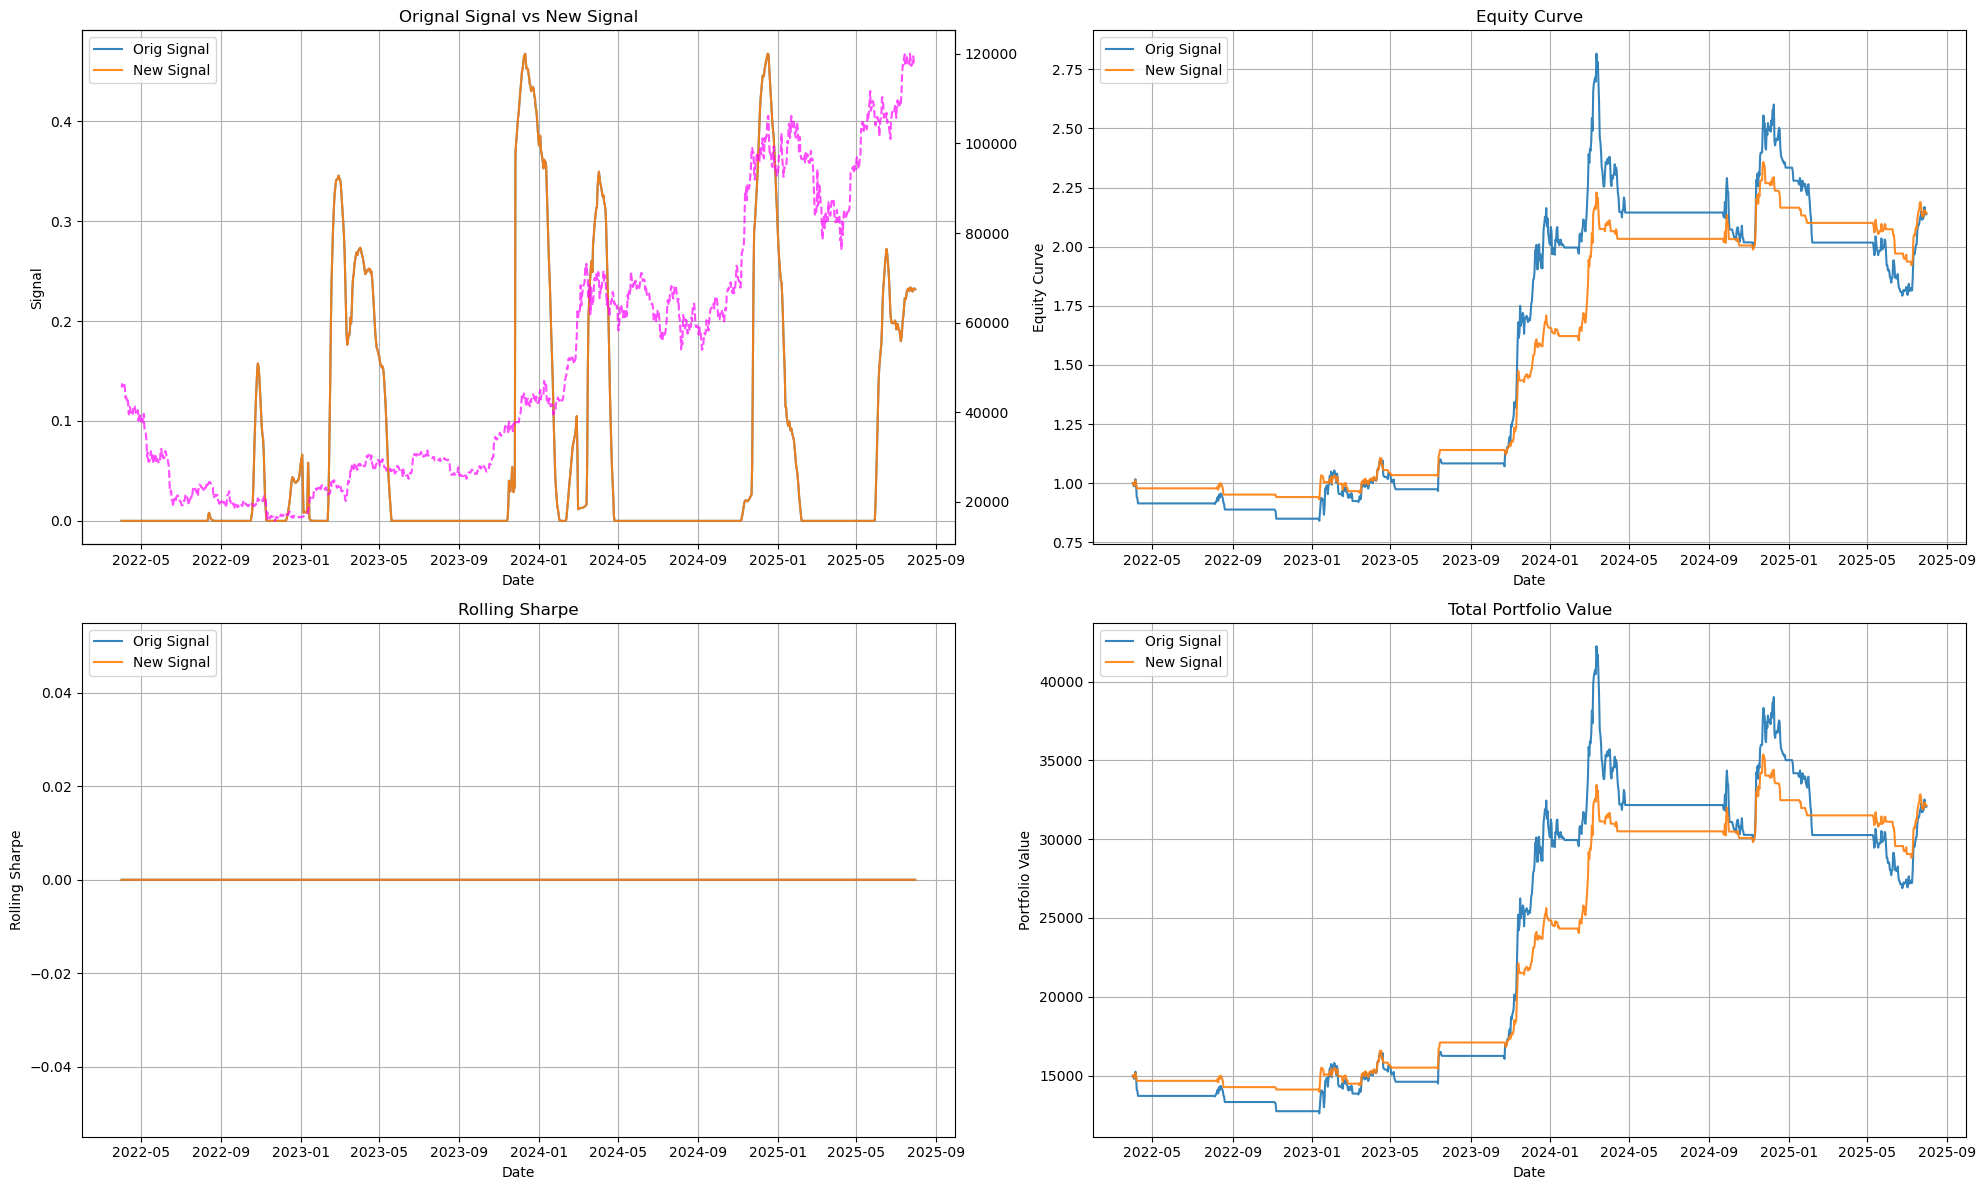

In [676]:
plot_signal_performance(df_final_orig_config, df_final_new_config, ticker='BTC-USD')

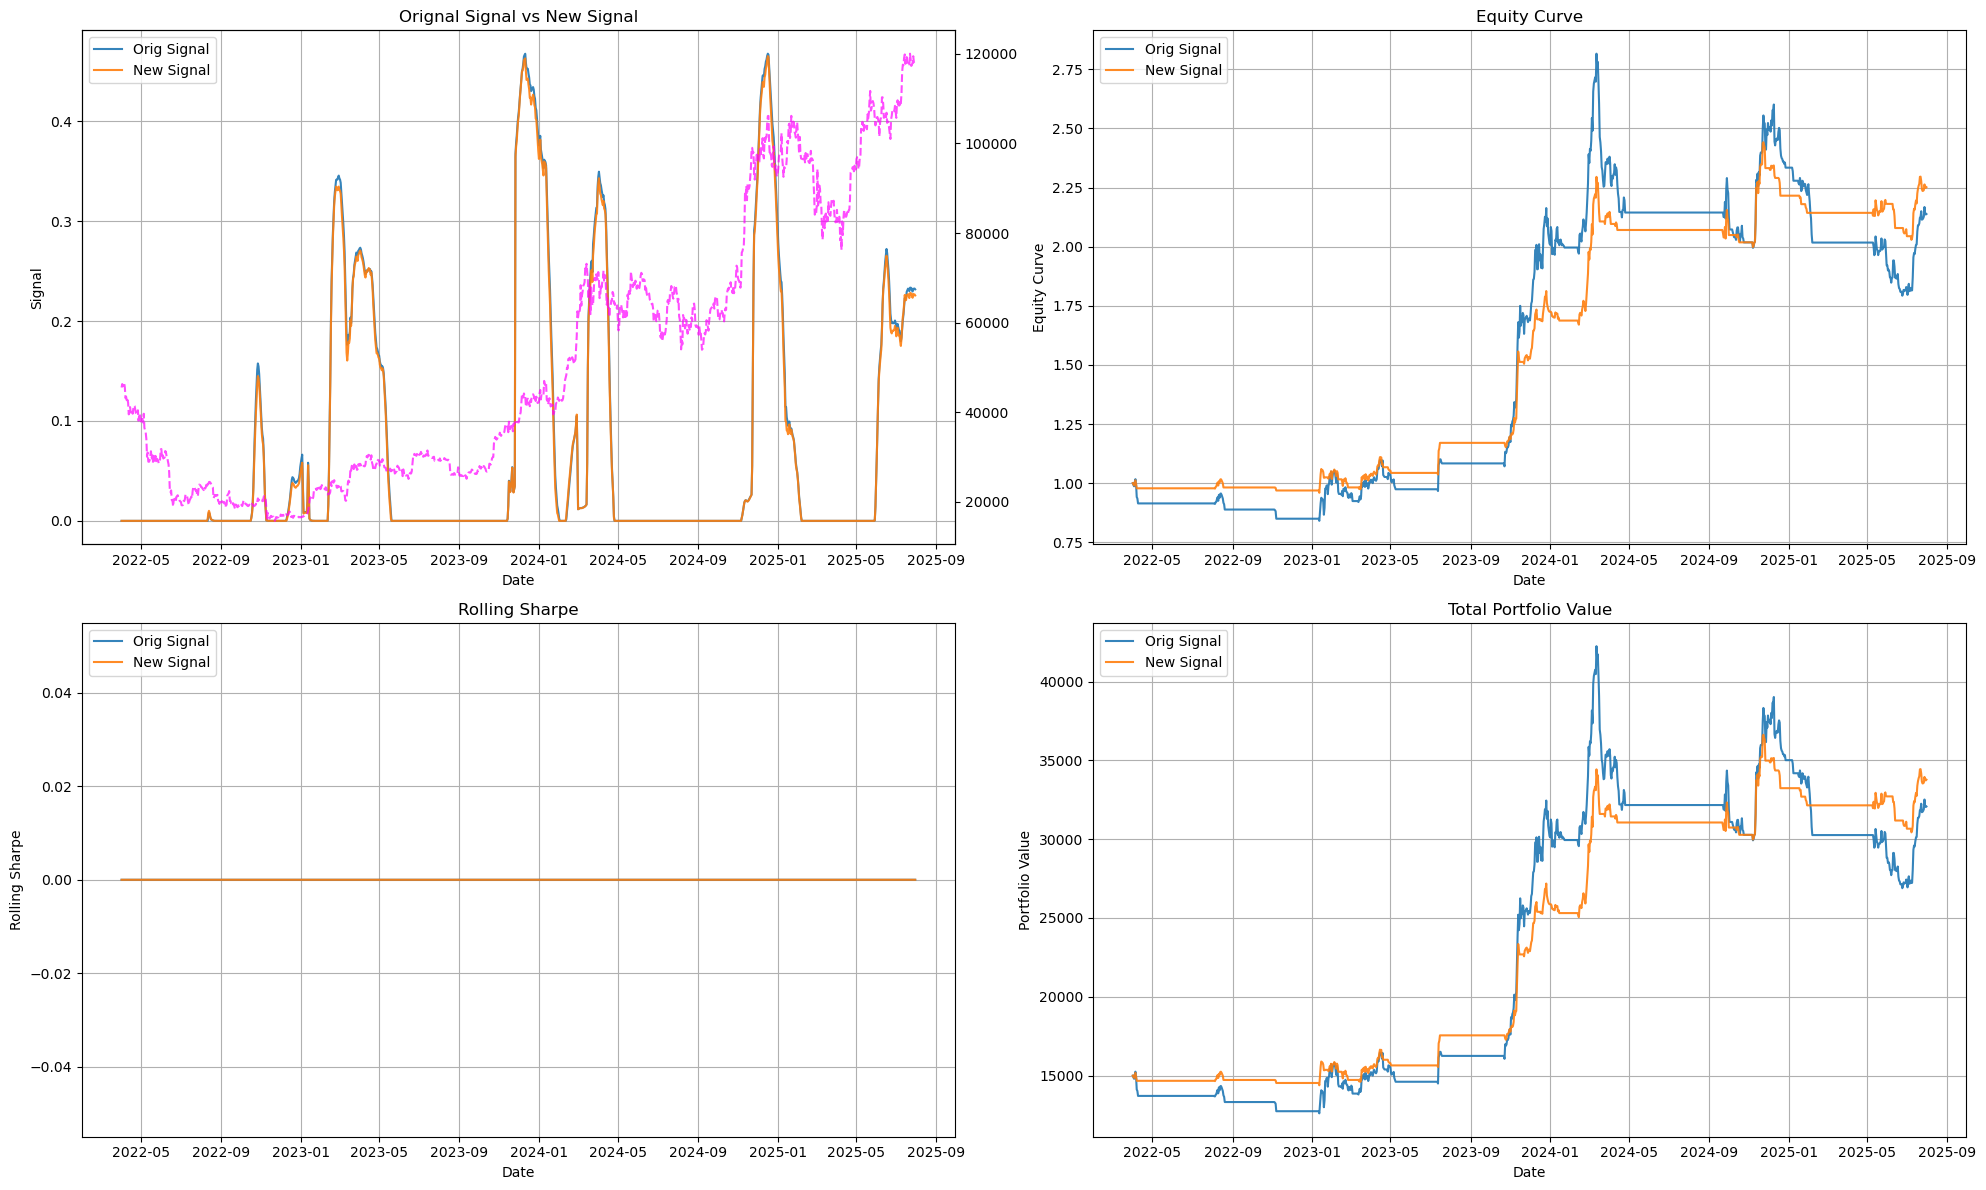

In [680]:
plot_signal_performance(df_final_orig_config, df_final_prod_config, ticker='BTC-USD')

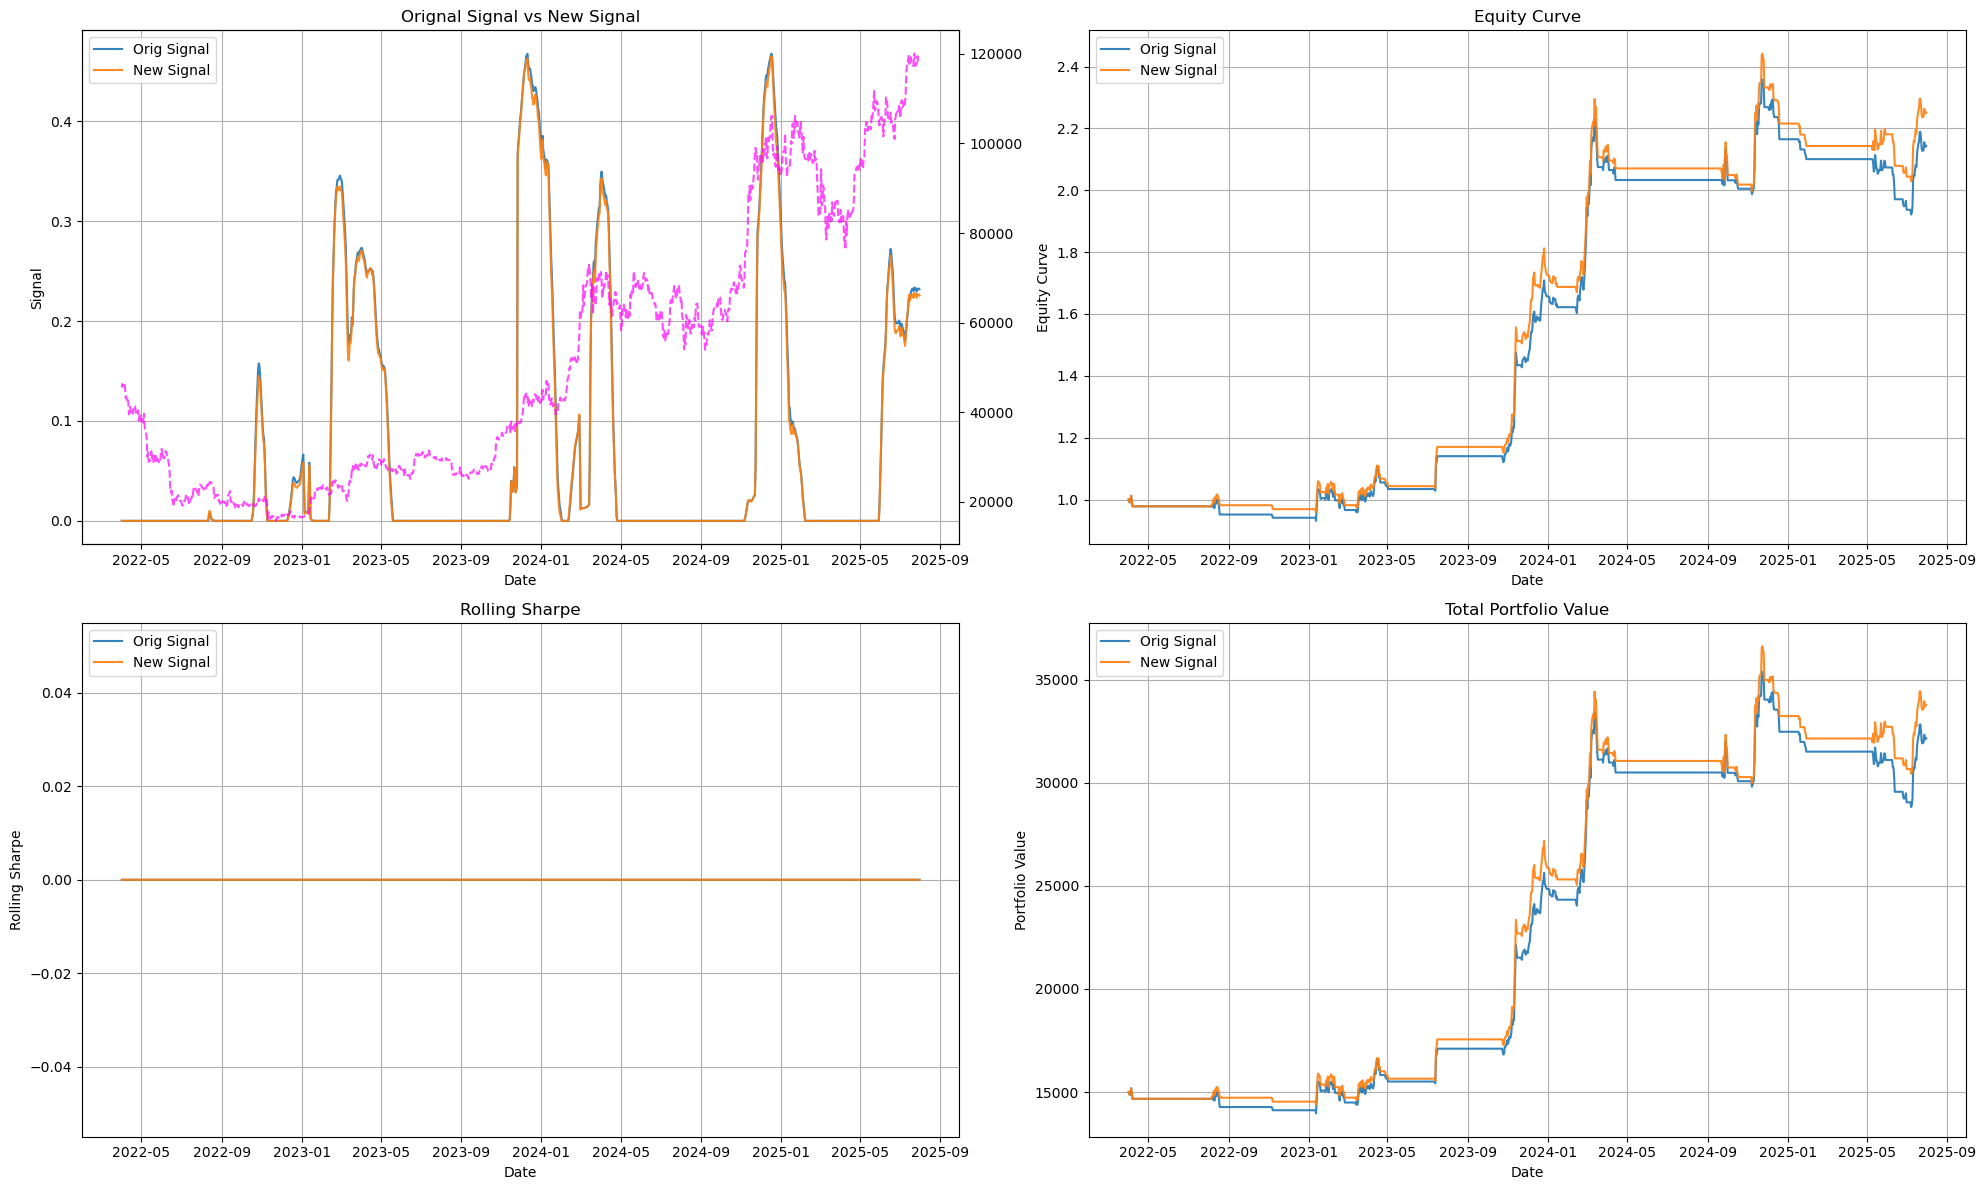

In [678]:
plot_signal_performance(df_final_new_config, df_final_prod_config, ticker='BTC-USD')